In [2]:
# Load modules 
%matplotlib inline

import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp
from scipy.signal import hilbert
import networkx as nx
from IPython.display import HTML

# import nest_asyncio
# nest_asyncio.apply()
import datalad.api as dl

In [3]:
# dir for neural 
story_dir = '/mnt/c/Users/since/Dropbox/Lab/Projects/CJY/_DATA'
May_dir = '/mnt/c/Users/since/Desktop/KdramaMay/'

# directory for behav
story_dir = '/mnt/c/Users/since/Dropbox/Lab/Projects/CJY/_DATA'
base_dir = '/mnt/c/Users/since/Desktop/KdramaMay/'

#Load brain mask
mask_dir = '/mnt/c/Users/since/Desktop/KdramaMay/analysis/roi_masks/BN_atlas_sub_hipp/DMN_HIPP_mask.nii.gz'
mask = Brain_Data(mask_dir)
mask_x = expand_mask(mask)
#mask.plot()

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/image/resampling.py:616: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)


In [4]:
subjects_va = [ '2', '3','4','5','6','7','8','10',
               '11','12','13','14','15','16','17','18','19','20',
               '21','22','23','24','25','27','28','29','30',
               '31','32','33']

subjects_av = ['34','35','38','39','40',
               '42','43','44','45','46','48','49',
               '51','52','53','54','55','58','59',
               '64','65','66','67','68','70',
               '71','72','73','74','75','76']

subjects = np.concatenate([subjects_va, subjects_av])
subjects

array(['2', '3', '4', '5', '6', '7', '8', '10', '11', '12', '13', '14',
       '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '27', '28', '29', '30', '31', '32', '33', '34', '35', '38', '39',
       '40', '42', '43', '44', '45', '46', '48', '49', '51', '52', '53',
       '54', '55', '58', '59', '64', '65', '66', '67', '68', '70', '71',
       '72', '73', '74', '75', '76'], dtype='<U2')

In [5]:
sub_timeseries = {}
for sub in subjects:
    run_timeseries = {} 
    for run in [1,2]: 
        run_timeseries[run] = pd.read_csv(os.path.join(May_dir, 'denoised','bn_subregion_masked', f'sub-{sub}_task-encoding_run-{run}_Average_ROI_BN_n28.csv'))
    sub_timeseries[sub] = run_timeseries

In [31]:
# LH와 RH 대응되는 ROI 쌍 매칭 리스트
roi_pairs = [
    (0, 14), (1, 15), (2, 16), (3, 13), (4, 17), (5, 18), (6, 19), (8, 20),
    (9, 21), (11, 22), (12, 23), (24, 25), (26, 27)]
roi_idx = [0,1,2,3,4,5,6,8,9,11,12,24,26]
roi_name=['MTG_1','MTG_2','MTG_3', 'AG', 'IFG_1', 'IFG_2','VMPFC','DMPFC', 
          'SFG_1','SFG_2','PMC','RSC', 'AHC','PHC']
          
# 첫 번째 실행 예시 데이터
concat_timeseries={}
for sub in subjects:
    run_concat_timeseries={}
    for run in [1,2]: 
        data = sub_timeseries[sub][run]
        avg_data = pd.DataFrame()
        
        for (lh_idx, rh_idx) in roi_pairs:
            # ROI 번호는 1부터 시작하므로 인덱스에 -1을 합니다.
            lh_column = data.iloc[:, lh_idx]
            rh_column = data.iloc[:, rh_idx]
            
            # 좌우 반구 평균을 구해서 새로운 데이터프레임에 추가
            avg_data[lh_idx] = (lh_column + rh_column) / 2
        
        # 평균이 적용된 새로운 데이터프레임을 출력 또는 저장
        run_concat_timeseries[run]=avg_data
    concat_timeseries[sub]=run_concat_timeseries

In [32]:
# load story sequence 
import scipy.io as sio

all_story = {}
# Load May Data
for sub in subjects:
    #print(sub)
    mat = sio.loadmat(glob.glob(os.path.join(story_dir, 'fMRItdsgn', f'sub-{sub}_*.mat'))[0])
    story = []
    for i in np.arange(0,4):
        temp = mat['subj'][0][0][7][0][i][0]
        if temp == 'Blind Date':
            temp = 'BlindDate'
        elif temp == 'Runningman':
            temp = 'RunningMan'
        elif temp == 'Way To School':
            temp = 'WayToSchool'
        elif temp == 'Business Lunch':
            temp = 'BusinessLunch'
        elif temp == 'neighbors':
            temp = 'Neighbors'
        story = np.append(story, temp)
    #all_story[str(int(sub)+8)] = story
    all_story[sub] = story
#Fix story sequence
story_sequece = all_story['2']
story_sequece

array(['Neighbors', 'Dream', 'BlindDate', 'RunningMan'], dtype='<U32')

In [33]:
# Data Load & Trimming 
onset = {'Dream1' : [0, 110, 230, 350], 'Dream2' : [0, 120, 230, 350], 'Dream3' : [0, 120, 240, 350], 'Dream4' : [0, 120, 240, 360]}
offset = {'Dream1' : [119, 239, 359, 477], 'Dream2' : [129, 239, 359, 477], 'Dream3' : [129, 249, 359, 477], 'Dream4' : [129, 249, 369, 477]} 

# May는 Dream의 위치에 따라 Trimming이 달라져야함.. ;D
storyName = {'RunningMan': 'run', 'BlindDate': 'blind', 'Dream':'dream', 'Neighbors':'nei'}

sub_story_timeseries = {}
for sub in subjects:
    story = {} 
    sequence = np.where(all_story[sub]=='Dream')[0][0]
    cond = 'Dream'+str(int(sequence)+1)
    if int(sub) < 34: 
        for i in np.arange(0,4):
            story[storyName[all_story[sub][i]]] = {'visual' : concat_timeseries[sub][1].iloc[onset[cond][i]:offset[cond][i]], 'audio' : concat_timeseries[sub][2].iloc[onset[cond][i]:offset[cond][i]]}
    else:
        for i in np.arange(0,4):
            story[storyName[all_story[sub][i]]] = {'audio' : concat_timeseries[sub][1].iloc[onset[cond][i]:offset[cond][i]], 'visual' : concat_timeseries[sub][2].iloc[onset[cond][i]:offset[cond][i]]}
    sub_story_timeseries[sub] = story

In [34]:
import numpy as np
from scipy.stats import zscore

def safe_zscore(data, axis=None):
    std_dev = np.nanstd(data, axis=axis)
    if np.all(std_dev == 0) or np.isnan(data).any():
        return np.zeros_like(data)  # 분산이 0인 경우 0으로 반환
    else:
        return zscore(data, axis=axis, nan_policy='omit')  # 특정 축에 대해 zscore를 계산하고, NaN은 무시
    
# 가우시안 필터를 사용한 스무딩
from scipy.ndimage import gaussian_filter1d


def gaussian_smoothing(data, sigma=1):
    return gaussian_filter1d(data, sigma=sigma)

In [271]:
from_onset = 10
from_offset = 10

es_story_series = np.zeros((31,2, 31, 4, 2, 5, 2*from_onset)) #subject_list, subjects, story, modality, max_events(idx), timeseries
#audio_story_series = np.zeros((2, 31, 4, 2, 5,16))
    
for roi in roi_idx:
    for sl, subject_list in enumerate([subjects_va, subjects_av]):  
        if subject_list == 'subjects_va':
            story_EB_visual = {'run' : [28,44,57,98], 'nei': [22,74,94], 'dream': [28], 'blind': [104]}
            story_EB_audio = {'run' : [26,49,57,98], 'nei': [43,72,94], 'dream': [17,27,66,89], 'blind': [36,88,104]}
        else: 
            story_EB_visual = {'run' : [28,98], 'nei': [22,74,94], 'dream': [27,88], 'blind': [36,104]}
            story_EB_audio = {'run' : [26,49,56], 'nei': [43], 'dream': [27,88], 'blind': [104]} 


        for st, story in enumerate(['run', 'dream', 'nei', 'blind']):
            for s, sub in enumerate(subject_list): 
                for idx, num in enumerate(story_EB_visual[story]):
                    onset = num - from_onset
                    offset = num + from_offset
                    data = sub_story_timeseries[sub][story]['visual'][roi].reset_index(drop=True)
                    es_story_series[roi, sl,s, st, 0, idx,:] = safe_zscore(data[onset:offset])

                for idx, num in enumerate(story_EB_audio[story]):
                    onset = num - from_onset 
                    offset = num + from_offset
                    data = sub_story_timeseries[sub][story]['audio'][roi].reset_index(drop=True)
                    es_story_series[roi, sl,s, st, 1, idx,:] = safe_zscore(data[onset:offset])
es_story_series_mean = np.nanmean(es_story_series, axis=(3,5))  # Average over story & events axes
print(es_story_series_mean.shape) # (2,30,16) 

(31, 2, 31, 2, 20)


In [277]:
es_story_series_mean[30,:,:,:,:] = (es_story_series_mean[24,:,:,:,:] +es_story_series_mean[26,:,:,:,:])/2 

In [273]:
from_onset = 10
from_offset = 10

ss_story_series = np.zeros((31,2, 31, 4, 2, 5, 2*from_onset)) #roi, subject_list, subjects, story, modality, max_events(idx), timeseries
#audio_story_series = np.zeros((2, 31, 4, 2, 5,16))
    
for roi in roi_idx:
    for sl, subject_list in enumerate([subjects_va, subjects_av]):  

        if subject_list == 'subjects_va':
            story_EB_visual = {'run' : [10], 'nei': [10], 'dream': [10], 'blind': [10]}
            story_EB_audio = {'run' : [10], 'nei': [10], 'dream': [10], 'blind': [10]}
        else: 
            story_EB_visual = {'run' : [10], 'nei': [10], 'dream': [10], 'blind': [10]}
            story_EB_audio = {'run' : [10], 'nei': [10], 'dream': [10], 'blind': [10]}  

        for st, story in enumerate(['run', 'dream', 'nei', 'blind']):
            for s, sub in enumerate(subject_list): 
                for idx, num in enumerate(story_EB_visual[story]):
                    onset = num - from_onset
                    offset = num + from_offset
                    data = sub_story_timeseries[sub][story]['visual'][roi].reset_index(drop=True)
                    ss_story_series[roi, sl,s, st, 0, idx,:] = safe_zscore(data[onset:offset])

                for idx, num in enumerate(story_EB_audio[story]):
                    onset = num - from_onset 
                    offset = num + from_offset
                    data = sub_story_timeseries[sub][story]['audio'][roi].reset_index(drop=True)
                    ss_story_series[roi, sl,s, st, 1, idx,:] = safe_zscore(data[onset:offset])

# zscored_story_series = zscore(story_series, axis=5, nan_policy='omit')

ss_story_series_mean = np.nanmean(ss_story_series, axis=(3,5))  # Average over story & events axes

In [276]:
ss_story_series_mean[30,:,:,:,:] = (ss_story_series_mean[24,:,:,:,:] +ss_story_series_mean[26,:,:,:,:])/2

In [37]:
from_onset = 10
from_offset = 10

sf_story_series = np.zeros((28,2, 31, 4, 2, 5, 2*from_onset)) #subject_list, subjects, story, modality, max_events(idx), timeseries
#audio_story_series = np.zeros((2, 31, 4, 2, 5,16))
    
for roi in roi_idx:
    for sl, subject_list in enumerate([subjects_va, subjects_av]):  

        if subject_list == 'subjects_va':
            story_EB_visual = {'run' : [98], 'nei': [94], 'dream': [88], 'blind': [104]}
            story_EB_audio = {'run' : [98], 'nei': [94], 'dream': [88], 'blind': [104]}
        else: 
            story_EB_visual = {'run' : [98], 'nei': [94], 'dream': [88], 'blind': [104]}
            story_EB_audio = {'run' : [98], 'nei': [94], 'dream': [88], 'blind': [104]}  

        for st, story in enumerate(['run', 'dream', 'nei', 'blind']):
            for s, sub in enumerate(subject_list): 
                for idx, num in enumerate(story_EB_visual[story]):
                    onset = num - from_onset
                    offset = num + from_offset
                    data = sub_story_timeseries[sub][story]['visual'][roi].reset_index(drop=True)
                    sf_story_series[roi, sl,s, st, 0, idx,:] = safe_zscore(data[onset:offset])

                for idx, num in enumerate(story_EB_audio[story]):
                    onset = num - from_onset 
                    offset = num + from_offset
                    data = sub_story_timeseries[sub][story]['audio'][roi].reset_index(drop=True)
                    sf_story_series[roi, sl,s, st, 1, idx,:] = safe_zscore(data[onset:offset])

# zscored_story_series = zscore(story_series, axis=5, nan_policy='omit')

sf_story_series_mean = np.nanmean(sf_story_series, axis=(3,5))  # Average over story & events axes
sf_story_series_mean.shape

(28, 2, 31, 2, 20)

In [260]:
es_series1_concat,es_series2_concat,ss_series1_concat,ss_series2_concat = {},{},{},{}
roi_idx = [0,1,2,3,4,5,6,8,9,11,12,24,26]

for roi in roi_idx:  
    es_series1_concat[roi] = np.concatenate((es_story_series_mean[roi][0,:30,0,:],es_story_series_mean[roi][1,:,1,:]), axis=0)
    ss_series1_concat[roi] = np.concatenate((ss_story_series_mean[roi][0,:30,0,:],ss_story_series_mean[roi][1,:,1,:]), axis=0)
    es_series2_concat[roi] = np.concatenate((es_story_series_mean[roi][0,:30,1,:],es_story_series_mean[roi][1,:,0,:]), axis=0)
    ss_series2_concat[roi] = np.concatenate((ss_story_series_mean[roi][0,:30,1,:],ss_story_series_mean[roi][1,:,0,:]), axis=0)
es_series1_concat[30] = np.concatenate((es_story_series_mean[24][0,:30,0,:],es_story_series_mean[26][1,:,1,:]), axis=0)
ss_series1_concat[30] = np.concatenate((ss_story_series_mean[24][0,:30,0,:],ss_story_series_mean[26][1,:,1,:]), axis=0)
es_series2_concat[30] = np.concatenate((es_story_series_mean[24][0,:30,1,:],es_story_series_mean[26][1,:,0,:]), axis=0)
ss_series2_concat[30] = np.concatenate((ss_story_series_mean[24][0,:30,1,:],ss_story_series_mean[26][1,:,0,:]), axis=0)

In [263]:
expand_roi_idx = [0,1,2,3,4,5,6,8,9,11,12,24,26,30]
es_mean_1.shape[0]

20

In [265]:
import numpy as np
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# ROI 데이터 (예시)
for roi in expand_roi_idx: 
    # New Event 부분
    print(f"--- ROI {roi} ---")

#     es_mean_1 = gaussian_smoothing(np.nanmean(es_story_series_concat[roi], axis=0)[0], sigma=1)
#     es_mean_2 = gaussian_smoothing(np.nanmean(es_story_series_concat[roi], axis=0)[1], sigma=1)
    event_timepoints = 20  # Time points for new events

    # 시점별 데이터 저장
    all_timepoints_data_t1 = []
    all_timepoints_data_t2 = []

    # 각 시점에서의 데이터 수집 (새로운 이벤트)
    for time in range(event_timepoints):
        es_t1_samples = es_series1_concat[roi][:,time]  # t1 샘플
        es_t2_samples = es_series2_concat[roi][:,time]  # t2 샘플

        all_timepoints_data_t1.append(es_t1_samples)
        all_timepoints_data_t2.append(es_t2_samples)

    # 시점별로 대응표본 t-검정 수행 및 p-value 저장
    post_hoc_p_values = []
    for t in range(event_timepoints):
        t_stat, post_hoc_p = ttest_rel(all_timepoints_data_t1[t], all_timepoints_data_t2[t])
        post_hoc_p_values.append(post_hoc_p)

    # FDR 보정 수행 (다중 비교 문제 해결을 위해)
    corrected_p_values = multipletests(post_hoc_p_values, alpha=0.05, method='fdr_bh')[1]

    # 유의미한 시점 찾기 (과학적 표기법을 소수점 형식으로 변환 후 비교)
    significant_times = np.where(corrected_p_values < 0.05)[0]

    # 소수점 표기법으로 변환하여 p-values 출력
    formatted_p_values = [f"{p_value:.10f}" for p_value in corrected_p_values]
    #print(formatted_p_values)

    # 유의미한 시점 출력
    if len(significant_times) > 0:
        print(f"Significant time points after new event: {significant_times}")#, Corrected p-values: {formatted_p_values}")
    else:
        print("No significant time points found after new event.")

    # New Story 부분
    story_timepoints = event_timepoints  # New Story와 New Event의 시간포인트는 동일하게 설정
    # 시점별 데이터 저장
    all_timepoints_data_t1 = []
    all_timepoints_data_t2 = []

    # 각 시점에서의 데이터 수집 (새로운 이야기)
    for time in range(story_timepoints):
        es_t1_samples = ss_series1_concat[roi][:, time]  # t1 샘플
        es_t2_samples = ss_series2_concat[roi][:, time]  # t2 샘플

        all_timepoints_data_t1.append(es_t1_samples)
        all_timepoints_data_t2.append(es_t2_samples)

    # 시점별로 대응표본 t-검정 수행 및 p-value 저장
    post_hoc_p_values = []
    for t in range(story_timepoints):
        t_stat, post_hoc_p = ttest_rel(all_timepoints_data_t1[t], all_timepoints_data_t2[t])
        post_hoc_p_values.append(post_hoc_p)

    # FDR 보정 수행 (다중 비교 문제 해결을 위해)
    corrected_p_values = multipletests(post_hoc_p_values, alpha=0.05, method='fdr_bh')[1]

    # 유의미한 시점 찾기
    significant_times = np.where(corrected_p_values < 0.05)[0]

    # 소수점 표기법으로 변환하여 p-values 출력
    formatted_p_values = [f"{p_value:.10f}" for p_value in corrected_p_values]

    # 유의미한 시점 출력
    if len(significant_times) > 0:
        print(f"Significant time points after new story: {significant_times}")#, Corrected p-values: {formatted_p_values}")
    else:
        print("No significant time points found after new story.")


--- ROI 0 ---
No significant time points found after new event.
No significant time points found after new story.
--- ROI 1 ---
No significant time points found after new event.
No significant time points found after new story.
--- ROI 2 ---
No significant time points found after new event.
No significant time points found after new story.
--- ROI 3 ---
Significant time points after new event: [ 3  4 14 16]
No significant time points found after new story.
--- ROI 4 ---
No significant time points found after new event.
Significant time points after new story: [ 5 11]
--- ROI 5 ---
No significant time points found after new event.
No significant time points found after new story.
--- ROI 6 ---
Significant time points after new event: [ 3  4 18]
Significant time points after new story: [11 12 16 17 18]
--- ROI 8 ---
Significant time points after new event: [4]
No significant time points found after new story.
--- ROI 9 ---
No significant time points found after new event.
No significant 

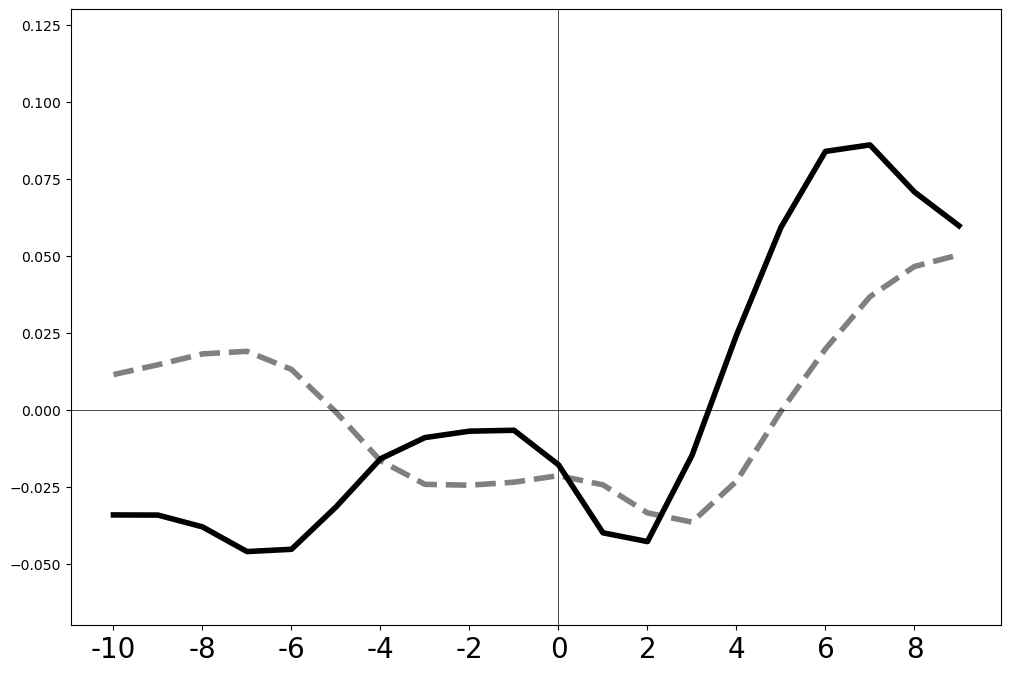

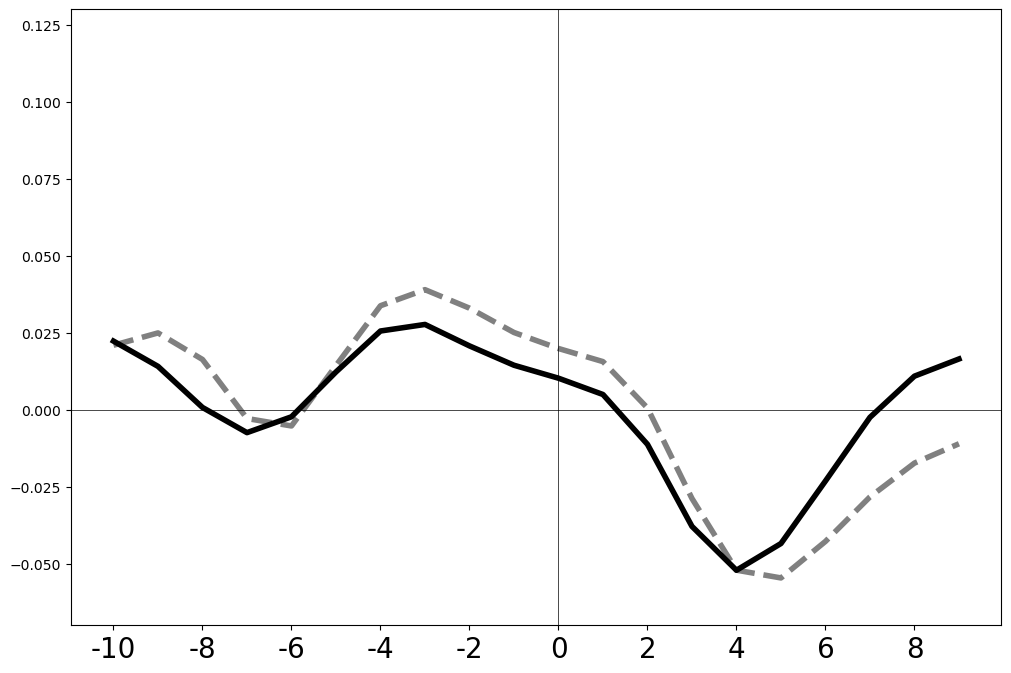

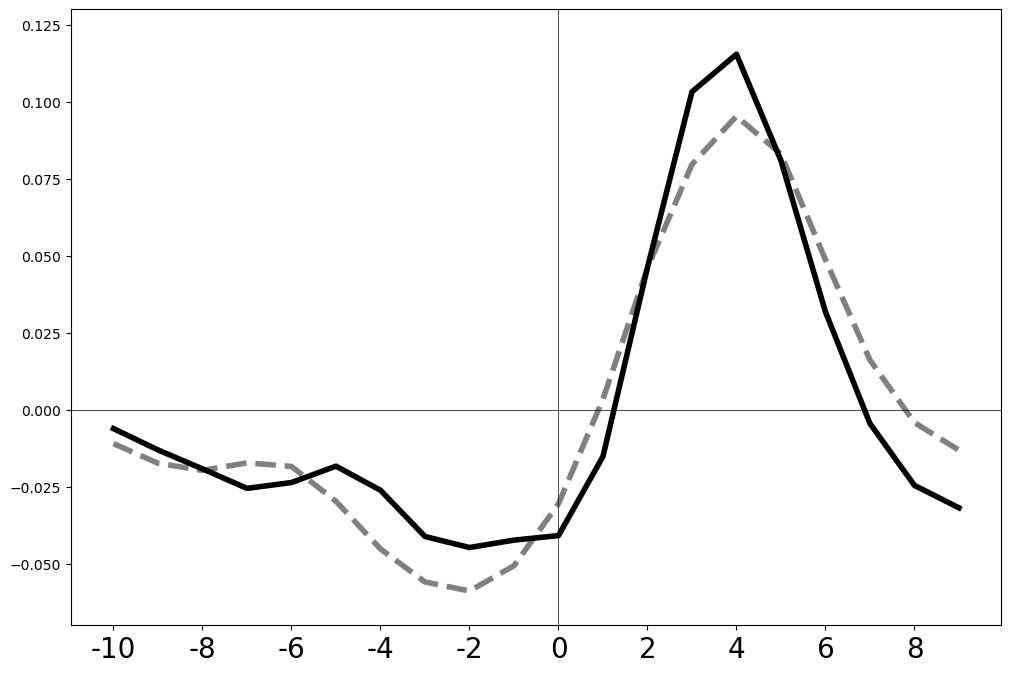

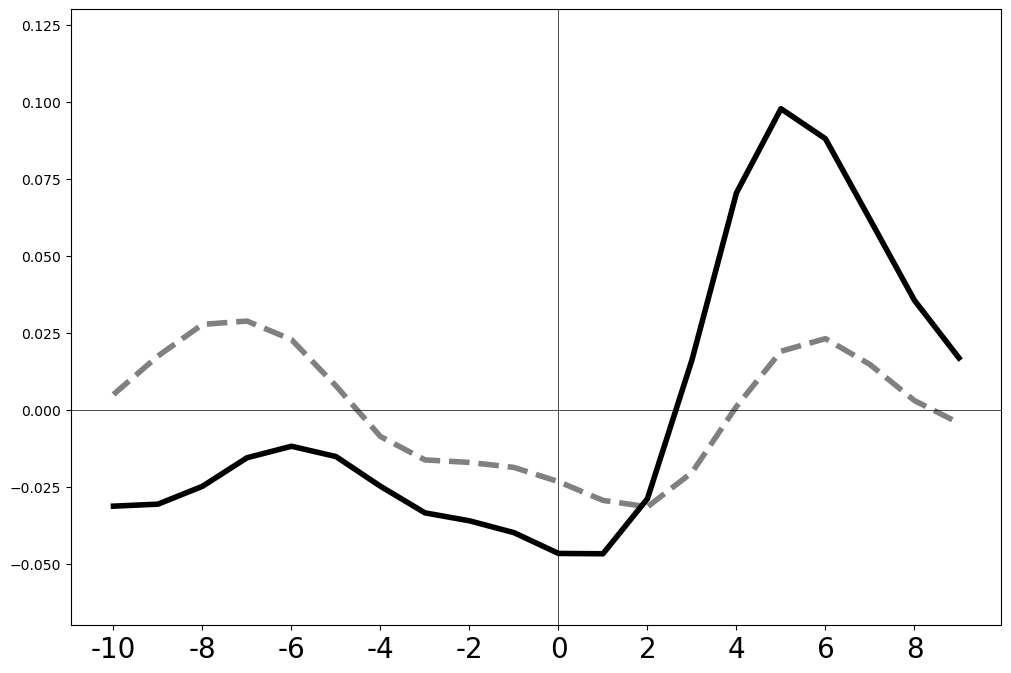

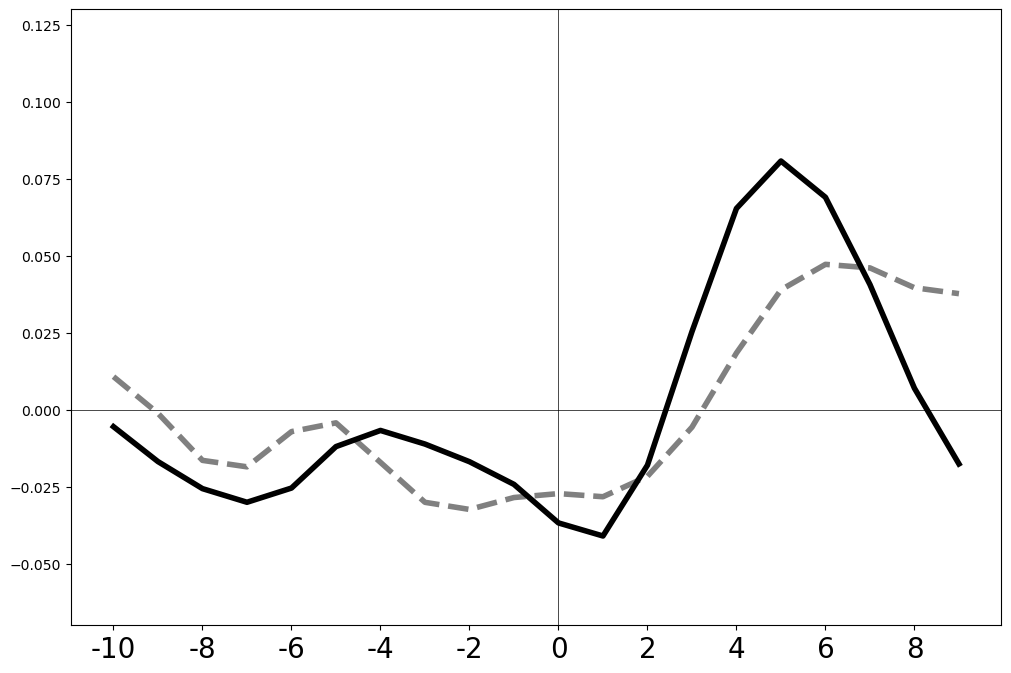

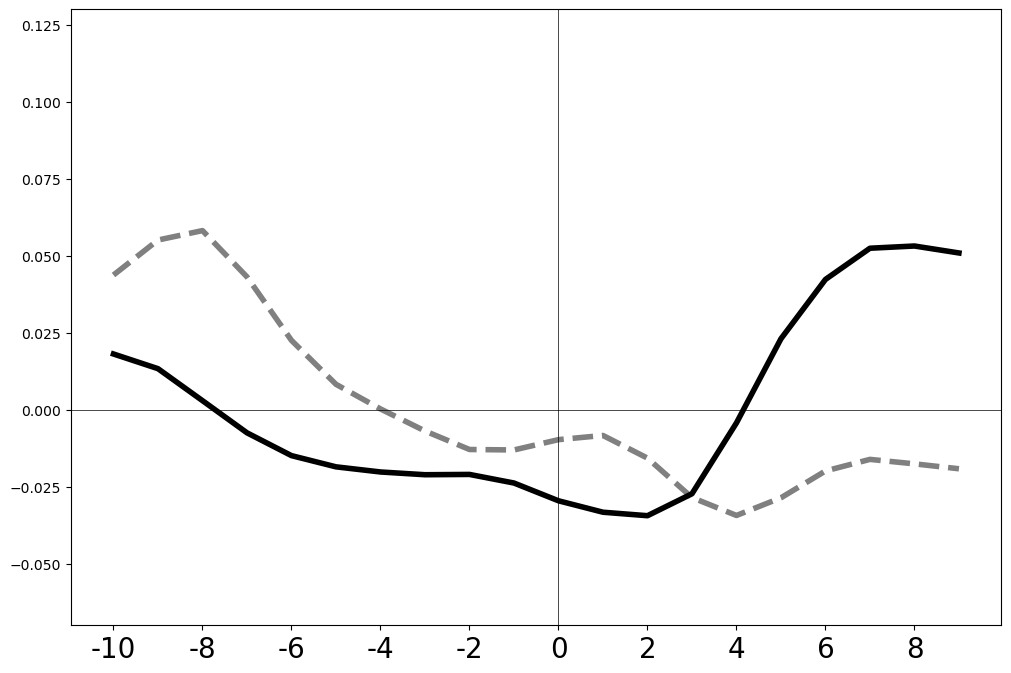

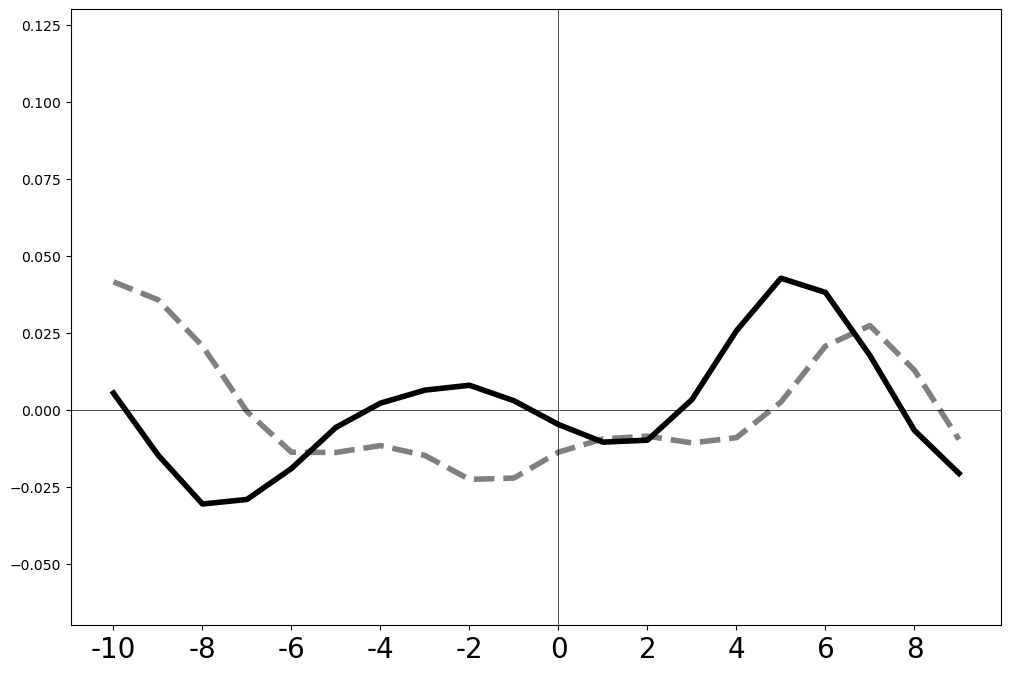

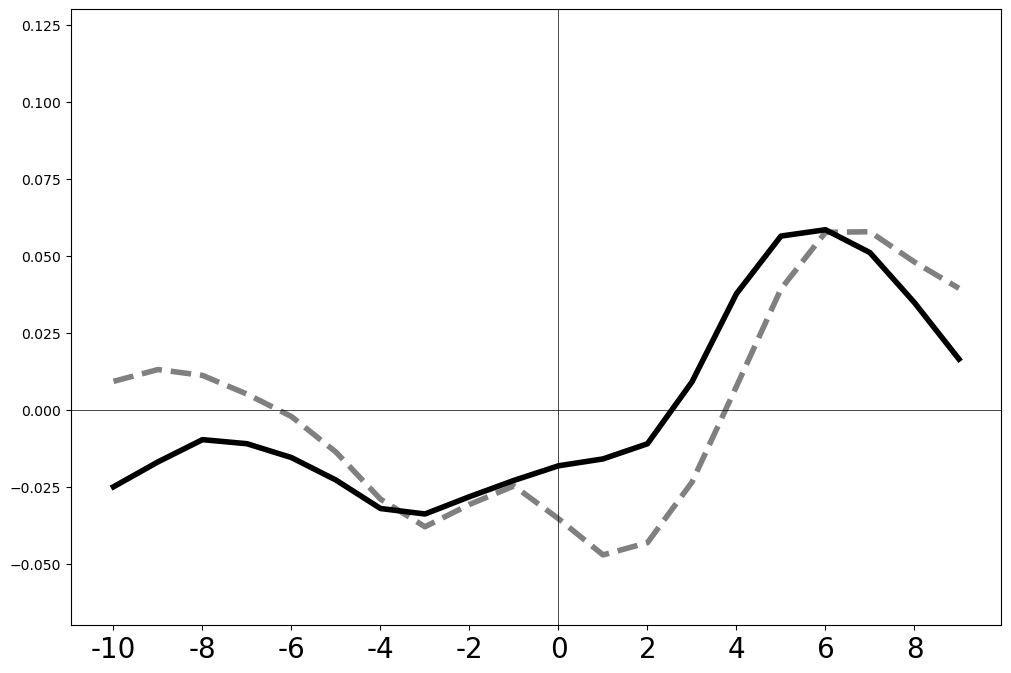

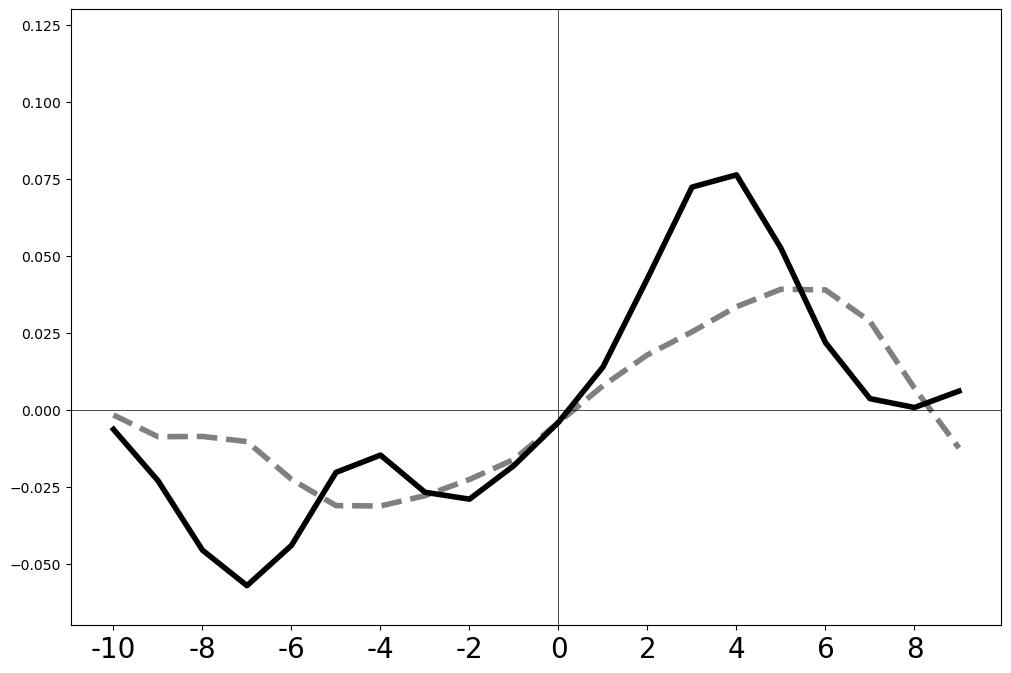

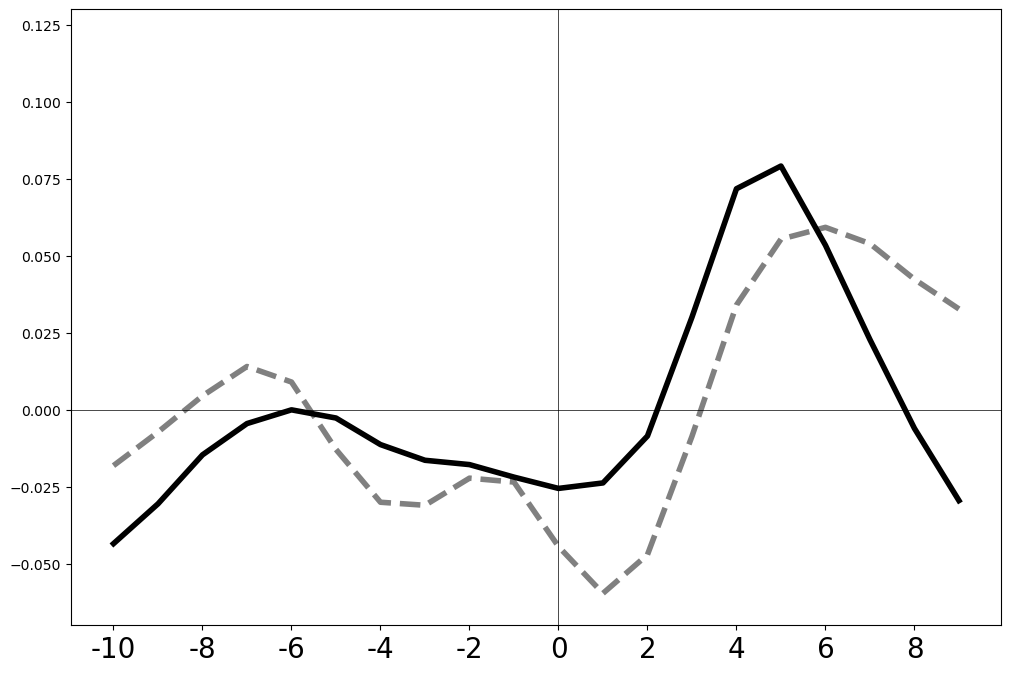

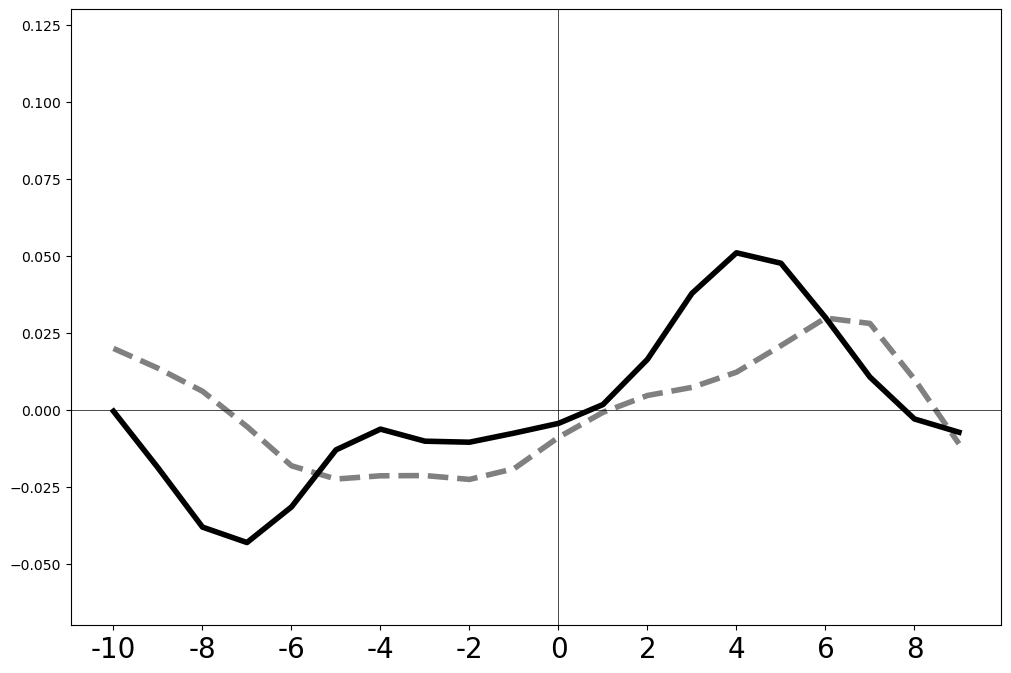

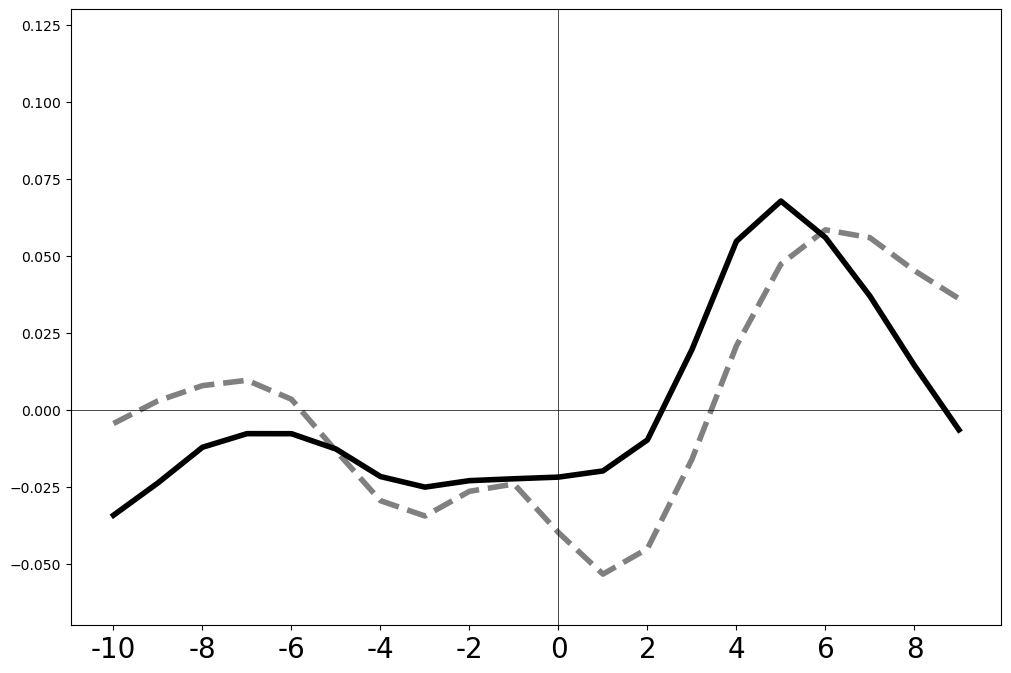

In [322]:
for roi in [3,11,12,24,26,30]:  #subject_list, subjects, modality,timeseries
    es_mean_1 =gaussian_smoothing((np.nanmean(es_story_series_mean[roi][0,:,0,:], axis=0) + np.nanmean(es_story_series_mean[roi][1,:,1,:], axis=0))/2 ,sigma=1) #First encoding
    es_mean_2 =gaussian_smoothing((np.nanmean(es_story_series_mean[roi][0,:,1,:], axis=0) + np.nanmean(es_story_series_mean[roi][1,:,0,:], axis=0))/2 ,sigma=1) #Second encoding
    es_mean_3 =gaussian_smoothing((np.nanmean(ss_story_series_mean[roi][0,:,0,:], axis=0) + np.nanmean(ss_story_series_mean[roi][1,:,1,:], axis=0))/2 ,sigma=1) #First encoding
    es_mean_4 =gaussian_smoothing((np.nanmean(ss_story_series_mean[roi][0,:,1,:], axis=0) + np.nanmean(ss_story_series_mean[roi][1,:,0,:], axis=0))/2 ,sigma=1) #Second encoding
    
    # # 첫 번째 그래프 (es_timeseries1, es_timeseries2s
    f, a = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

    #plt.errorbar(range(es_mean_1.shape[0]),  es_mean_1, yerr=es_timeseries1_std, linewidth=3, color='gray', linestyle='-', label='ES  t1')
    plt.plot(es_mean_1, linewidth=4, color = 'gray', linestyle='--')
    plt.plot(es_mean_2, linewidth=4, color = 'black')


    # 축과 제목 설정
    plt.axvline(x=from_onset, linewidth=0.5, color='black')
    plt.axhline(y=0, linewidth=0.5, color='black')
    plt.ylim([-0.07, 0.13])
    plt.xticks(np.arange(0, 20, 2),  labels=[-10,-8,-6,-4,-2,0,+2,+4,+6,+8],fontsize = 20)
    plt.savefig(f"ES_{roi}.jpg")


    # 두 번째 그래프 (ss_timeseries)
    f, a = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    #plt.errorbar(range(es_mean_1.shape[0]),  ss_mean_1, yerr=ss_timeseries1_std, linewidth=3, color='gray', linestyle='-', label='ES  t1')
    plt.plot(es_mean_3, linewidth=4, color = 'gray', linestyle='--')
    plt.plot(es_mean_4, linewidth=4, color = 'black')


    # 축과 제목 설정
    plt.axvline(x=from_onset, linewidth=0.5, color='black')
    plt.axhline(y=0, linewidth=0.5, color='black')
    plt.ylim([-0.07, 0.13])
    plt.xticks(np.arange(0, 20, 2),  labels=[-10,-8,-6,-4,-2,0,+2,+4,+6,+8],fontsize = 20)
    plt.savefig(f"SS_{roi}.jpg")




In [280]:
import numpy as np
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# ROI 데이터 (예시)
for roi in expand_roi_idx: 
    # New Event 부분
    print(f"--- ROI {roi} ---")
    
    # 새로운 이벤트 시점 분석
    es_mean_1 =gaussian_smoothing((np.nanmean(es_story_series_mean[roi][0,:,0,:], axis=0)),sigma=1)
    event_timepoints = es_mean_1.shape[0]  # Time points for new events

    # 시점별 데이터 저장
    all_timepoints_data_t1 = []
    all_timepoints_data_t2 = []

    # 각 시점에서의 데이터 수집 (새로운 이벤트)
    for time in range(event_timepoints):
        es_t1_samples = es_story_series_mean[roi][0,:30,0,time]  # t1 샘플
        es_t2_samples = es_story_series_mean[roi][1,:30,0,time]  # t2 샘플

        all_timepoints_data_t1.append(es_t1_samples)
        all_timepoints_data_t2.append(es_t2_samples)

    # 시점별로 대응표본 t-검정 수행 및 p-value 저장
    post_hoc_p_values = []
    for t in range(event_timepoints):
        t_stat, post_hoc_p = ttest_rel(all_timepoints_data_t1[t], all_timepoints_data_t2[t])
        post_hoc_p_values.append(post_hoc_p)

    # FDR 보정 수행 (다중 비교 문제 해결을 위해)
    corrected_p_values = multipletests(post_hoc_p_values, alpha=0.05, method='fdr_bh')[1]

    # 유의미한 시점 찾기 (과학적 표기법을 소수점 형식으로 변환 후 비교)
    significant_times = np.where(corrected_p_values < 0.05)[0]

    # 소수점 표기법으로 변환하여 p-values 출력
    formatted_p_values = [f"{p_value:.10f}" for p_value in corrected_p_values]
    #print(formatted_p_values)

    # 유의미한 시점 출력
    if len(significant_times) > 0:
        print(f"Significant time points after new event: {significant_times}")#, Corrected p-values: {formatted_p_values}")
    else:
        print("No significant time points found after new event.")

    # New Story 부분
    story_timepoints = event_timepoints  # New Story와 New Event의 시간포인트는 동일하게 설정

    # 시점별 데이터 저장
    all_timepoints_data_t1 = []
    all_timepoints_data_t2 = []

    # 각 시점에서의 데이터 수집 (새로운 이야기)
    for time in range(story_timepoints):
        es_t1_samples = ss_story_series_mean[roi][0,:30,0,time]  # t1 샘플
        es_t2_samples = ss_story_series_mean[roi][1,:30,0,time]  # t2 샘플

        all_timepoints_data_t1.append(es_t1_samples)
        all_timepoints_data_t2.append(es_t2_samples)

    # 시점별로 대응표본 t-검정 수행 및 p-value 저장
    post_hoc_p_values = []
    for t in range(story_timepoints):
        t_stat, post_hoc_p = ttest_rel(all_timepoints_data_t1[t], all_timepoints_data_t2[t])
        post_hoc_p_values.append(post_hoc_p)

    # FDR 보정 수행 (다중 비교 문제 해결을 위해)
    corrected_p_values = multipletests(post_hoc_p_values, alpha=0.05, method='fdr_bh')[1]

    # 유의미한 시점 찾기
    significant_times = np.where(corrected_p_values < 0.05)[0]

    # 소수점 표기법으로 변환하여 p-values 출력
    formatted_p_values = [f"{p_value:.10f}" for p_value in corrected_p_values]

    # 유의미한 시점 출력
    if len(significant_times) > 0:
        print(f"Significant time points after new story: {significant_times}")#, Corrected p-values: {formatted_p_values}")
    else:
        print("No significant time points found after new story.")


--- ROI 0 ---
No significant time points found after new event.
No significant time points found after new story.
--- ROI 1 ---
Significant time points after new event: [ 7 15 18]
No significant time points found after new story.
--- ROI 2 ---
Significant time points after new event: [14 15]
No significant time points found after new story.
--- ROI 3 ---
No significant time points found after new event.
No significant time points found after new story.
--- ROI 4 ---
No significant time points found after new event.
No significant time points found after new story.
--- ROI 5 ---
No significant time points found after new event.
No significant time points found after new story.
--- ROI 6 ---
Significant time points after new event: [18]
Significant time points after new story: [12]
--- ROI 8 ---
No significant time points found after new event.
No significant time points found after new story.
--- ROI 9 ---
No significant time points found after new event.
No significant time points foun

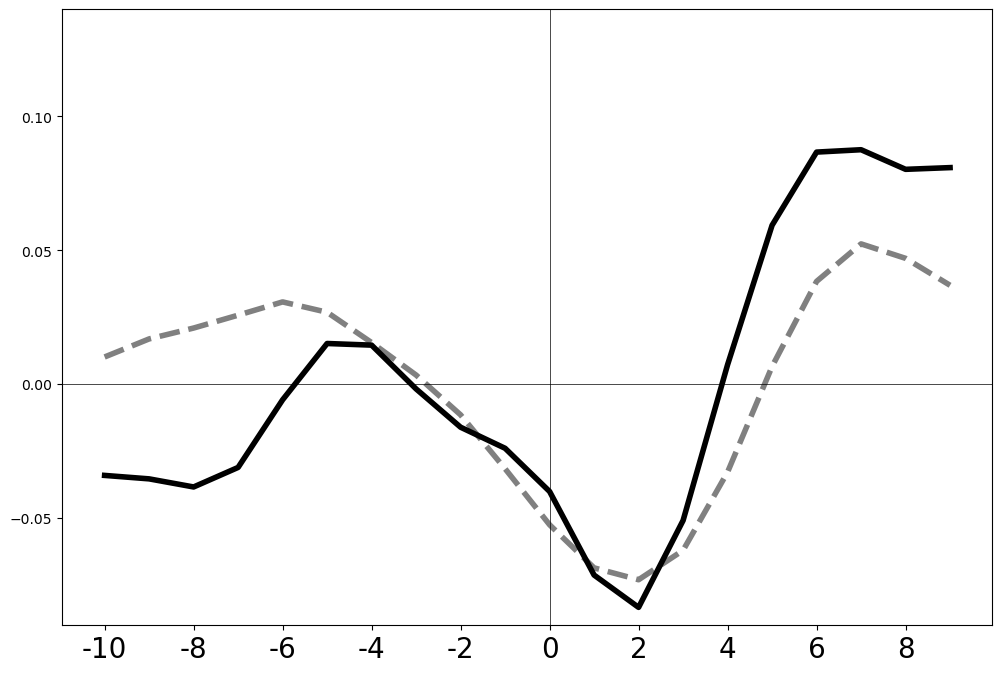

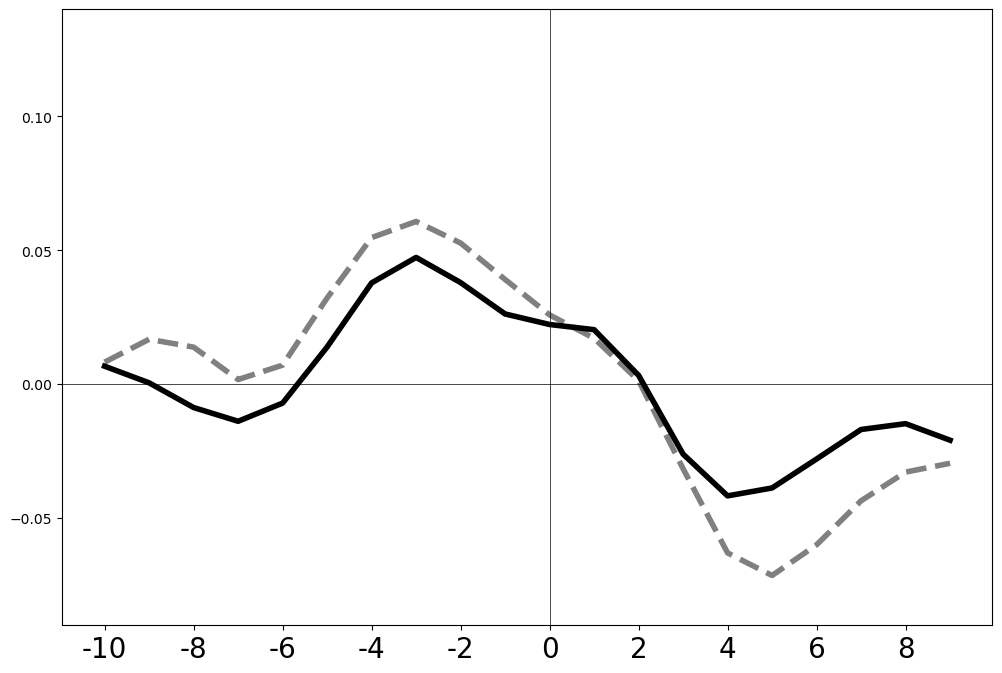

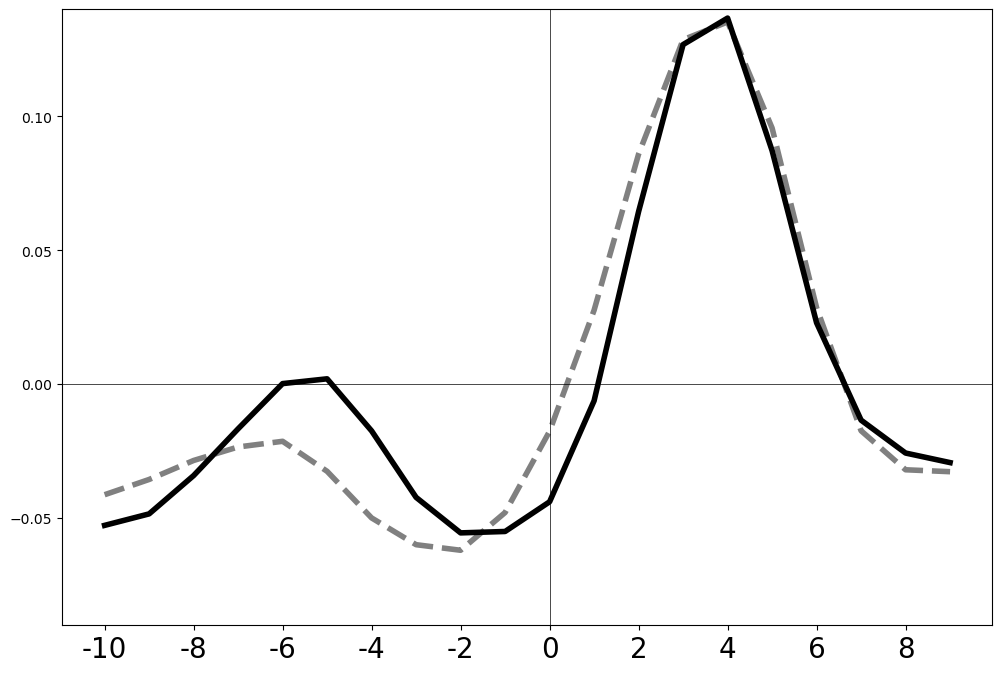

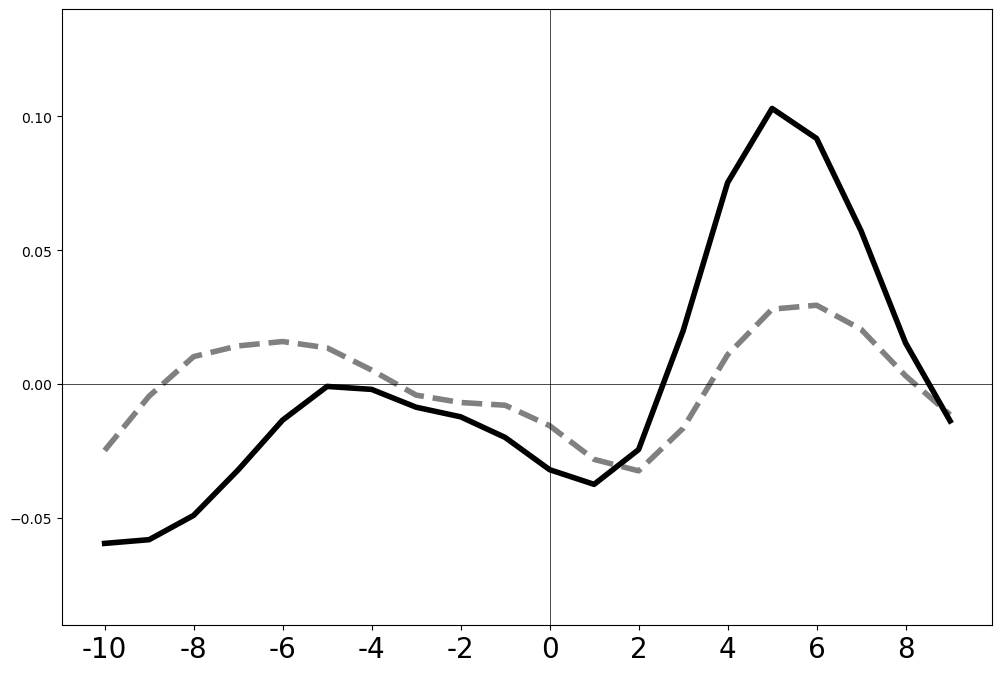

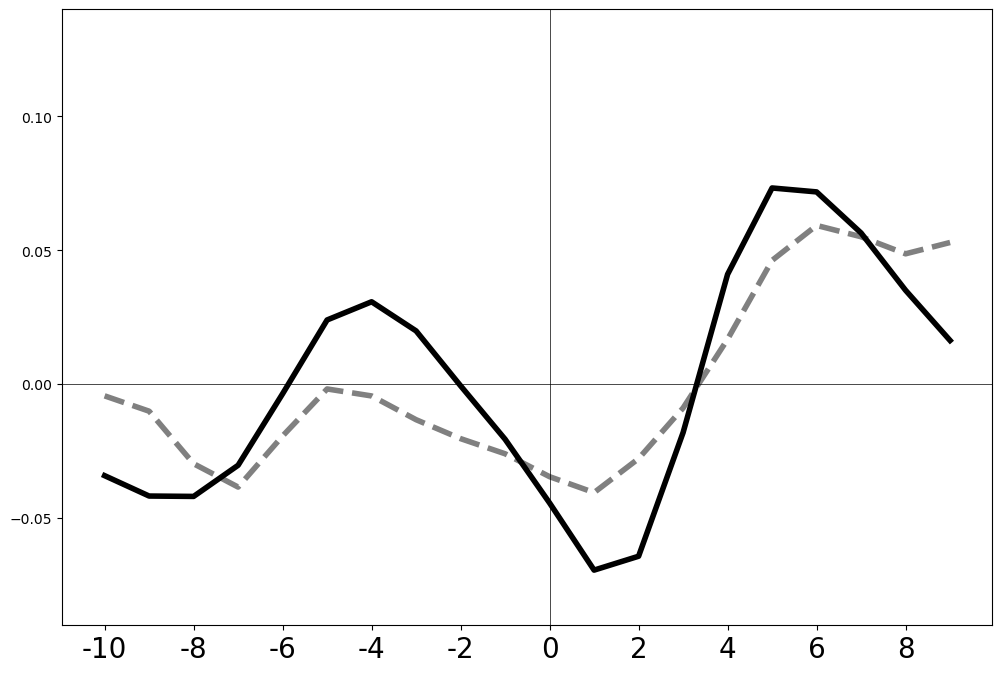

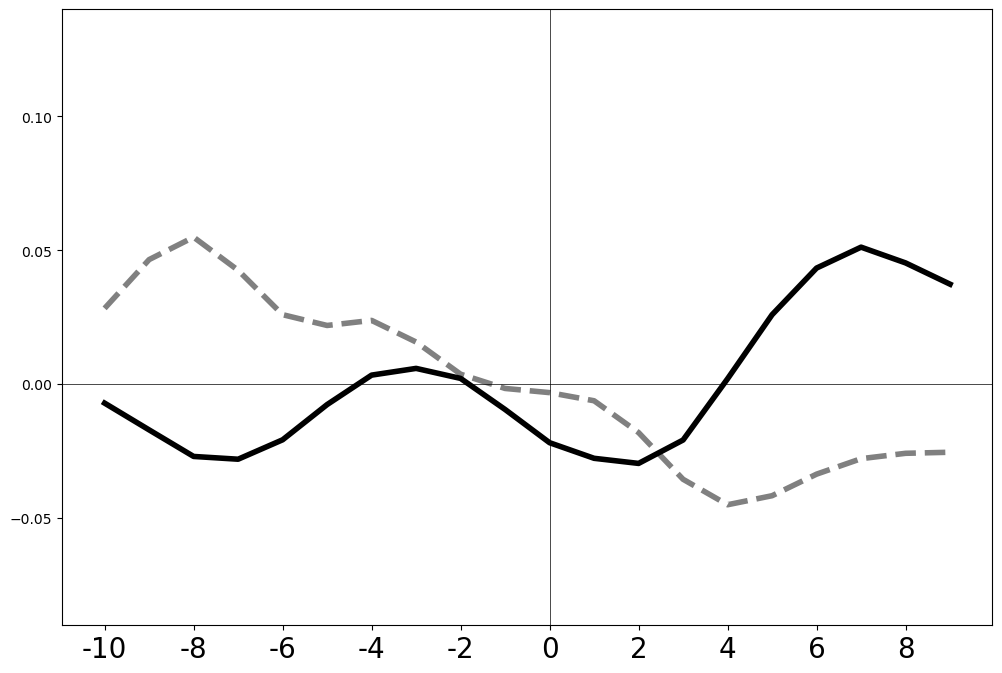

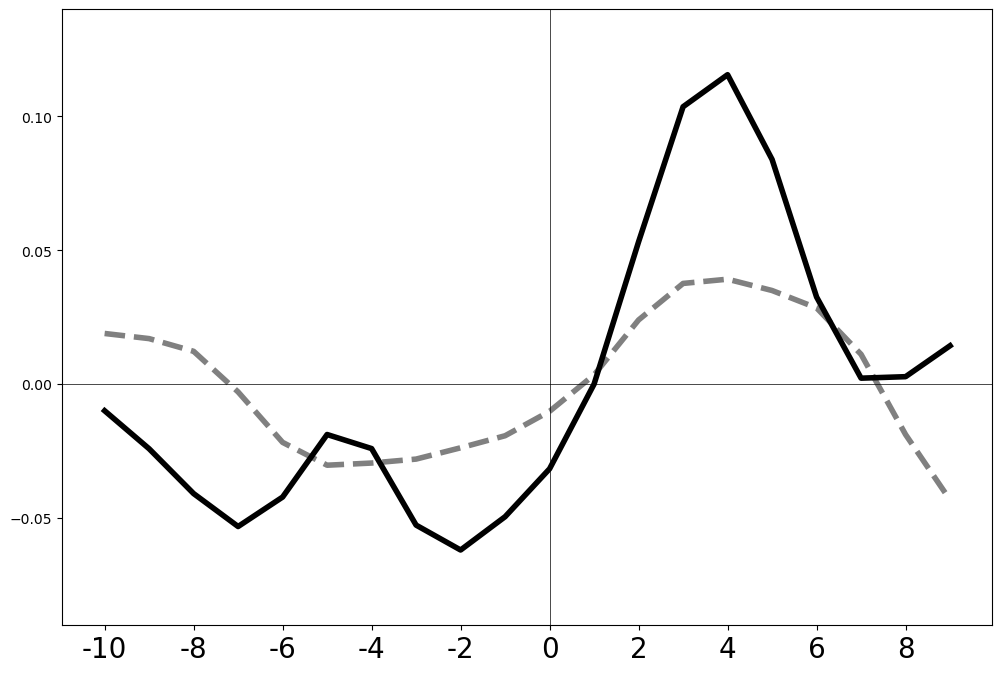

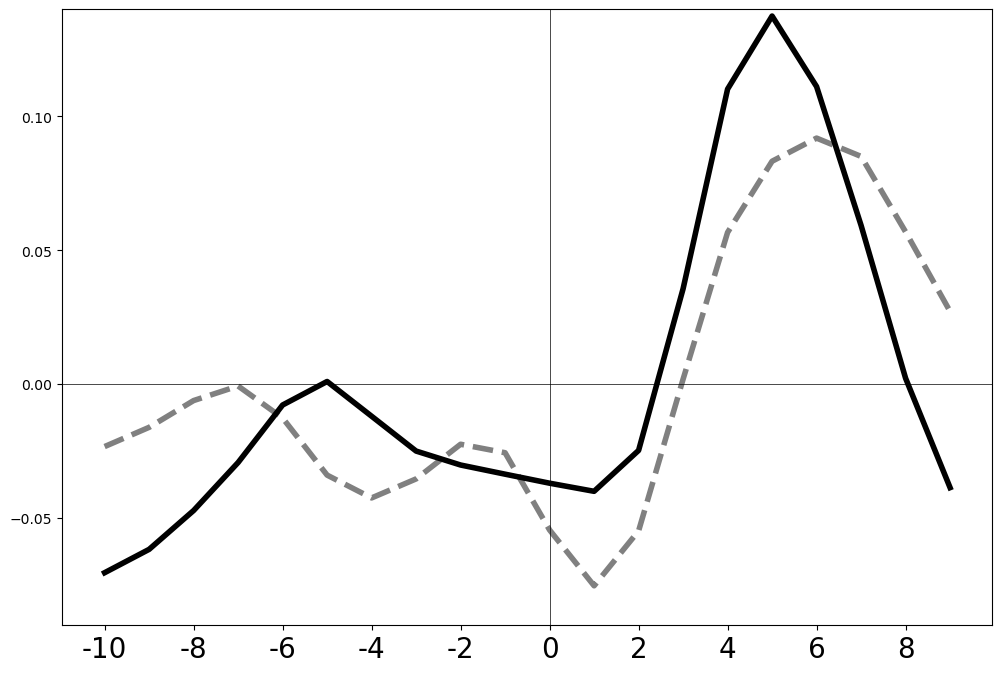

In [385]:
for roi in [3,11,12,26]:
    es_mean_1 =gaussian_smoothing((np.nanmean(es_story_series_mean[roi][0,:,0,:], axis=0)) ,sigma=1)
    es_mean_2 =gaussian_smoothing((np.nanmean(es_story_series_mean[roi][1,:,0,:], axis=0)) ,sigma=1)
    es_mean_3 =gaussian_smoothing((np.nanmean(ss_story_series_mean[roi][0,:,0,:], axis=0)) ,sigma=1)
    es_mean_4 =gaussian_smoothing((np.nanmean(ss_story_series_mean[roi][1,:,0,:], axis=0)) ,sigma=1)    
    
    # # 첫 번째 그래프 (es_timeseries1, es_timeseries2s
    f, a = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

    #plt.errorbar(range(es_mean_1.shape[0]),  es_mean_1, yerr=es_timeseries1_std, linewidth=3, color='gray', linestyle='-', label='ES  t1')
    plt.plot(es_mean_1, linewidth=4, color = 'gray', linestyle='--')
    plt.plot(es_mean_2, linewidth=4, color = 'black')


    # 축과 제목 설정
    plt.axvline(x=from_onset, linewidth=0.5, color='black')
    plt.axhline(y=0, linewidth=0.5, color='black')
    plt.ylim([-0.09, 0.14])
    plt.xticks(np.arange(0, 20, 2),  labels=[-10,-8,-6,-4,-2,0,+2,+4,+6,+8],fontsize = 20)
    plt.savefig(f"ES_{roi}.jpg")


    # 두 번째 그래프 (ss_timeseries)
    f, a = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    #plt.errorbar(range(es_mean_1.shape[0]),  ss_mean_1, yerr=ss_timeseries1_std, linewidth=3, color='gray', linestyle='-', label='ES  t1')
    plt.plot(es_mean_3, linewidth=4, color = 'gray', linestyle='--')
    plt.plot(es_mean_4, linewidth=4, color = 'black')


    # 축과 제목 설정
    plt.axvline(x=from_onset, linewidth=0.5, color='black')
    plt.axhline(y=0, linewidth=0.5, color='black')
    plt.ylim([-0.09, 0.14])
    plt.xticks(np.arange(0, 20, 2),  labels=[-10,-8,-6,-4,-2,0,+2,+4,+6,+8],fontsize = 20)
    plt.savefig(f"SS_{roi}.jpg")




In [169]:
import numpy as np
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# ROI 데이터 (예시)
for roi in roi_idx: 
    # New Event 부분
    print(f"--- ROI {roi} ---")
    
    # 새로운 이벤트 시점 분석
    es_mean_1 =gaussian_smoothing((np.nanmean(es_story_series_mean[roi][0,:,1,:], axis=0)),sigma=1)
    event_timepoints = es_mean_1.shape[0]  # Time points for new events

    # 시점별 데이터 저장
    all_timepoints_data_t1 = []
    all_timepoints_data_t2 = []

    # 각 시점에서의 데이터 수집 (새로운 이벤트)
    for time in range(event_timepoints):
        es_t1_samples = es_story_series_mean[roi][0,:30,1,time]  # t1 샘플
        es_t2_samples = es_story_series_mean[roi][1,:30,1,time]  # t2 샘플

        all_timepoints_data_t1.append(es_t1_samples)
        all_timepoints_data_t2.append(es_t2_samples)

    # 시점별로 대응표본 t-검정 수행 및 p-value 저장
    post_hoc_p_values = []
    for t in range(event_timepoints):
        t_stat, post_hoc_p = ttest_rel(all_timepoints_data_t1[t], all_timepoints_data_t2[t])
        post_hoc_p_values.append(post_hoc_p)

    # FDR 보정 수행 (다중 비교 문제 해결을 위해)
    corrected_p_values = multipletests(post_hoc_p_values, alpha=0.05, method='fdr_bh')[1]

    # 유의미한 시점 찾기 (과학적 표기법을 소수점 형식으로 변환 후 비교)
    significant_times = np.where(corrected_p_values < 0.05)[0]

    # 소수점 표기법으로 변환하여 p-values 출력
    formatted_p_values = [f"{p_value:.10f}" for p_value in corrected_p_values]
    #print(formatted_p_values)

    # 유의미한 시점 출력
    if len(significant_times) > 0:
        print(f"Significant time points after new event: {significant_times}")#, Corrected p-values: {formatted_p_values}")
    else:
        print("No significant time points found after new event.")

    # New Story 부분
    story_timepoints = event_timepoints  # New Story와 New Event의 시간포인트는 동일하게 설정

    # 시점별 데이터 저장
    all_timepoints_data_t1 = []
    all_timepoints_data_t2 = []

    # 각 시점에서의 데이터 수집 (새로운 이야기)
    for time in range(story_timepoints):
        es_t1_samples = ss_story_series_mean[roi][0,:30,1,time]  # t1 샘플
        es_t2_samples = ss_story_series_mean[roi][1,:30,1,time]  # t2 샘플

        all_timepoints_data_t1.append(es_t1_samples)
        all_timepoints_data_t2.append(es_t2_samples)

    # 시점별로 대응표본 t-검정 수행 및 p-value 저장
    post_hoc_p_values = []
    for t in range(story_timepoints):
        t_stat, post_hoc_p = ttest_rel(all_timepoints_data_t1[t], all_timepoints_data_t2[t])
        post_hoc_p_values.append(post_hoc_p)

    # FDR 보정 수행 (다중 비교 문제 해결을 위해)
    corrected_p_values = multipletests(post_hoc_p_values, alpha=0.05, method='fdr_bh')[1]

    # 유의미한 시점 찾기
    significant_times = np.where(corrected_p_values < 0.05)[0]

    # 소수점 표기법으로 변환하여 p-values 출력
    formatted_p_values = [f"{p_value:.10f}" for p_value in corrected_p_values]

    # 유의미한 시점 출력
    if len(significant_times) > 0:
        print(f"Significant time points after new story: {significant_times}")#, Corrected p-values: {formatted_p_values}")
    else:
        print("No significant time points found after new story.")


--- ROI 0 ---
No significant time points found after new event.
No significant time points found after new story.
--- ROI 1 ---
Significant time points after new event: [16]
No significant time points found after new story.
--- ROI 2 ---
No significant time points found after new event.
No significant time points found after new story.
--- ROI 3 ---
Significant time points after new event: [ 4 11 14 16 17]
No significant time points found after new story.
--- ROI 4 ---
No significant time points found after new event.
No significant time points found after new story.
--- ROI 5 ---
Significant time points after new event: [15]
No significant time points found after new story.
--- ROI 6 ---
Significant time points after new event: [4]
No significant time points found after new story.
--- ROI 8 ---
Significant time points after new event: [4]
No significant time points found after new story.
--- ROI 9 ---
Significant time points after new event: [ 4 13]
No significant time points found af

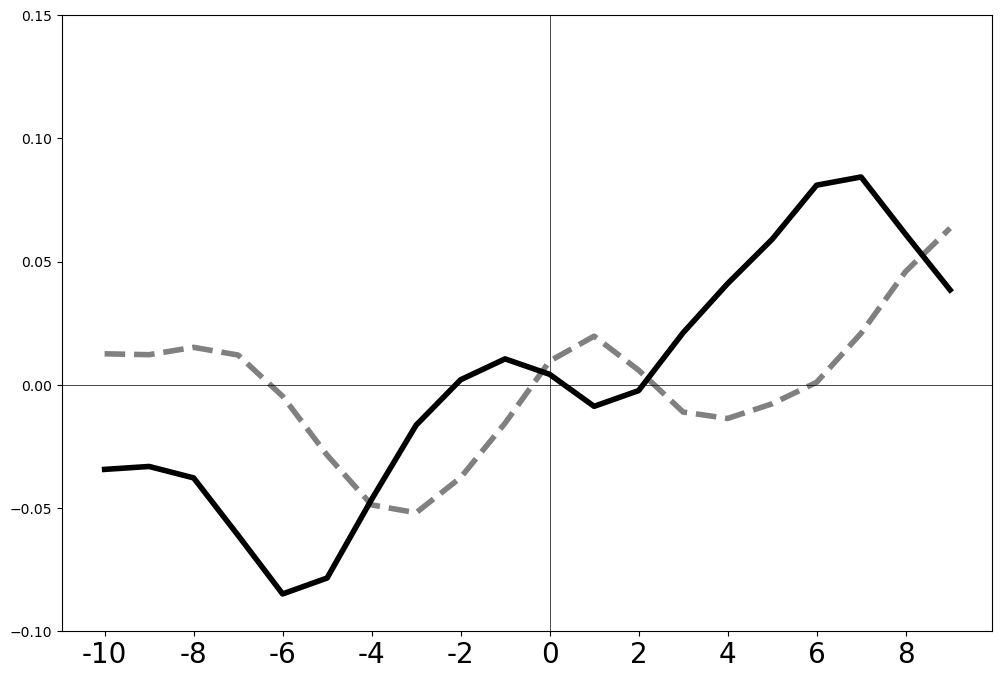

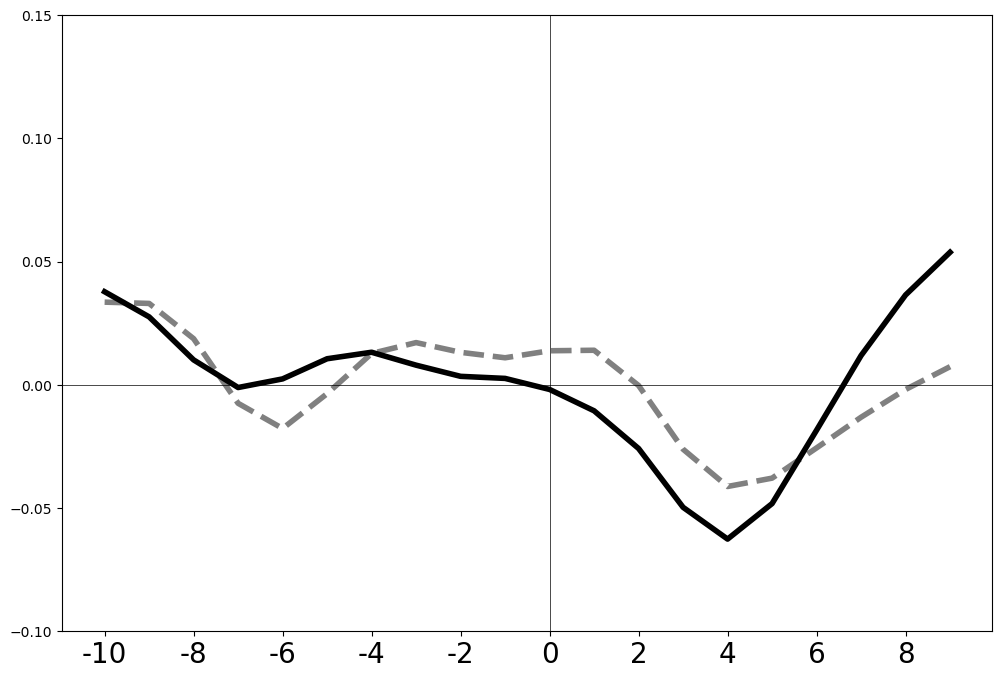

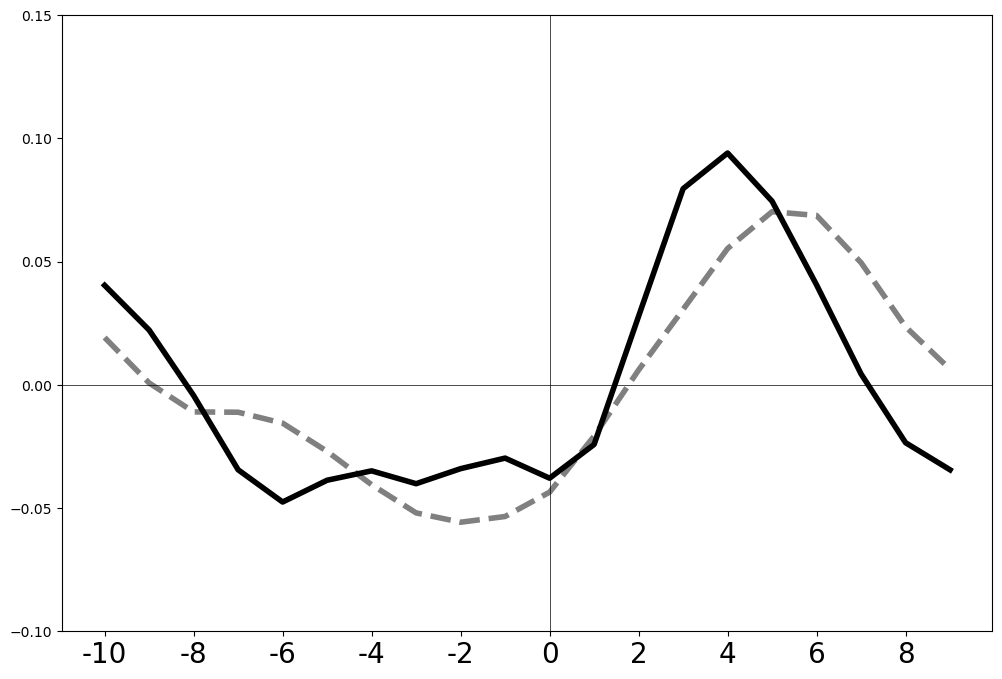

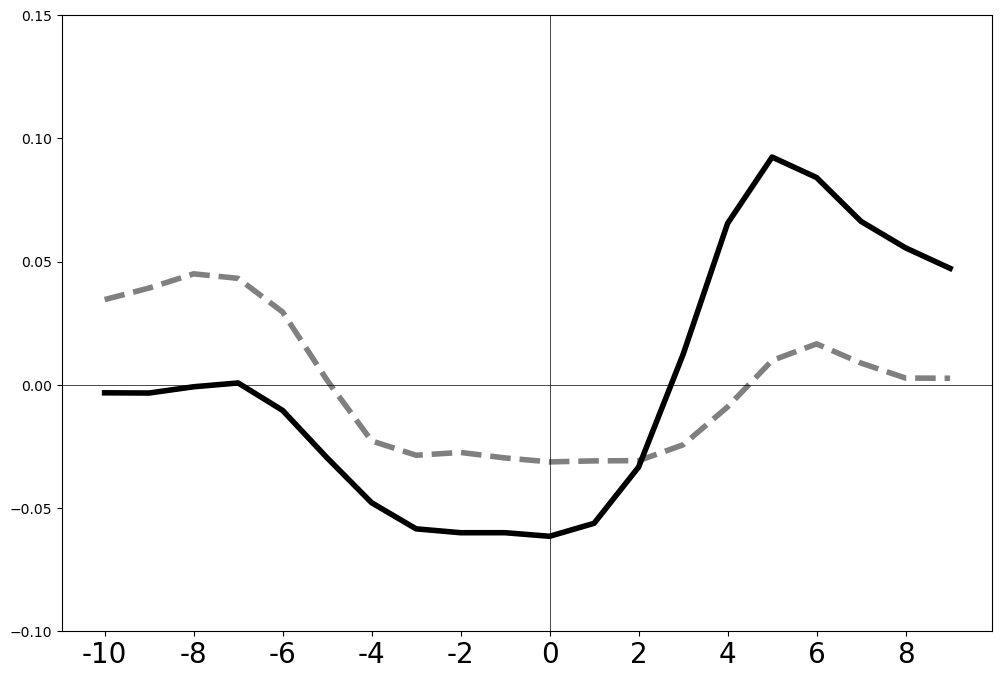

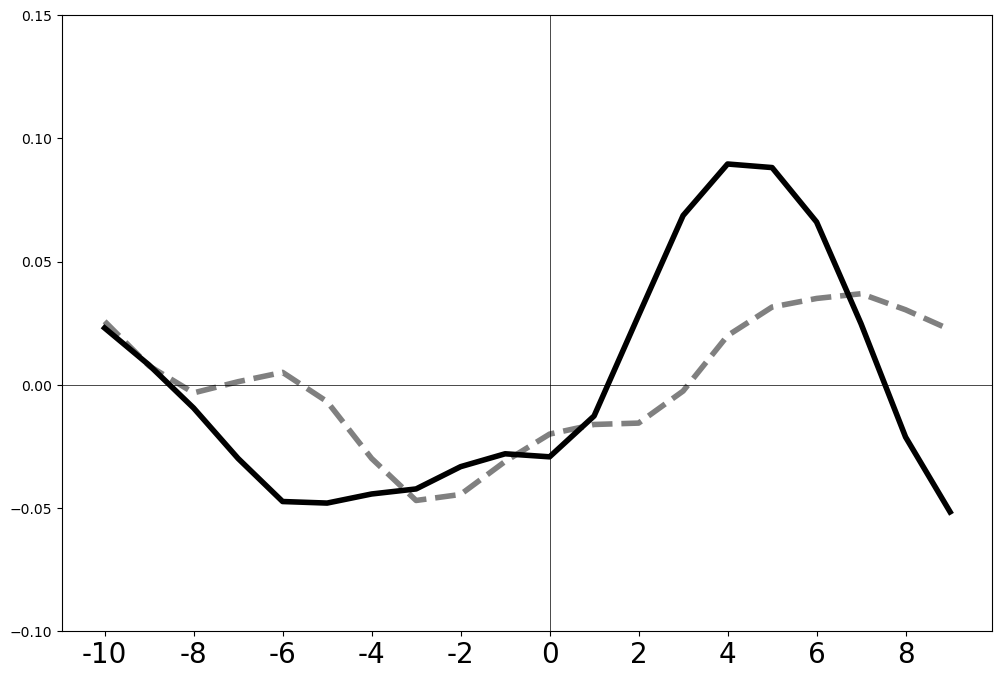

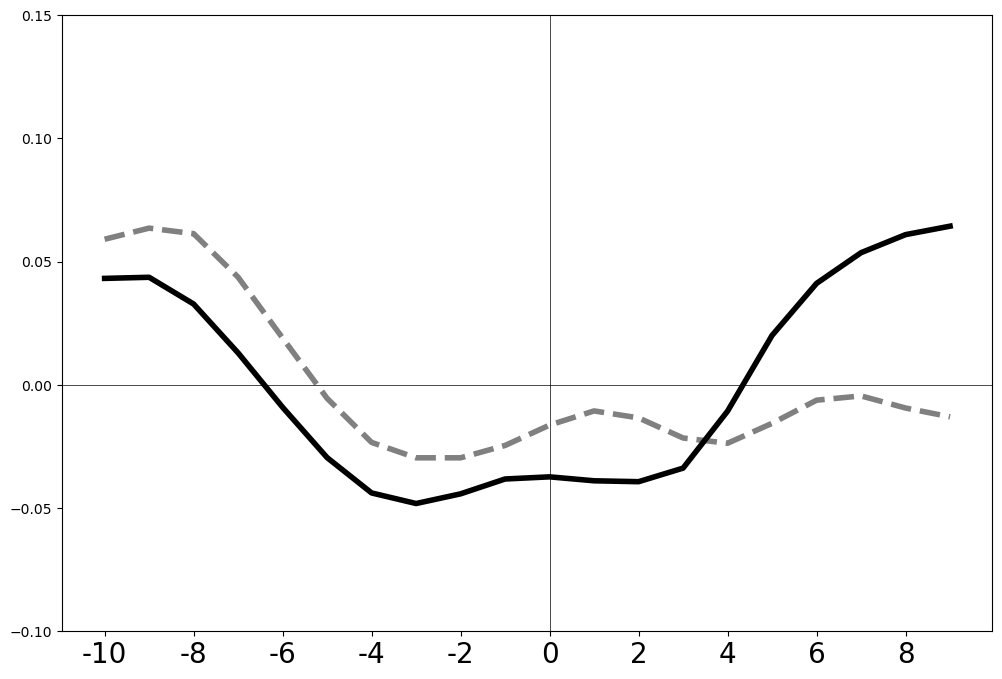

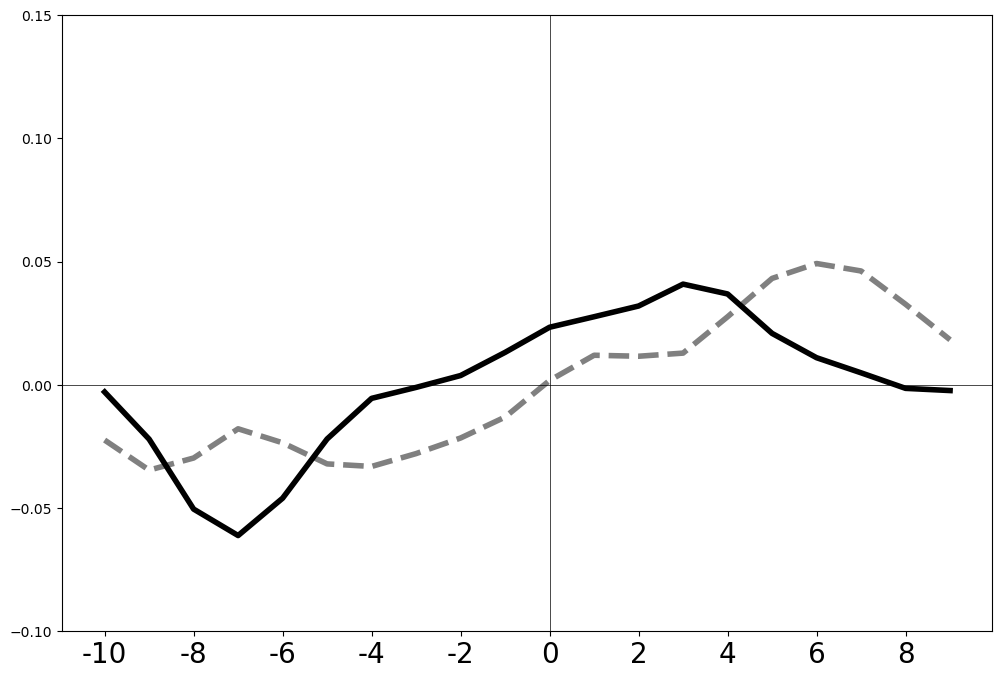

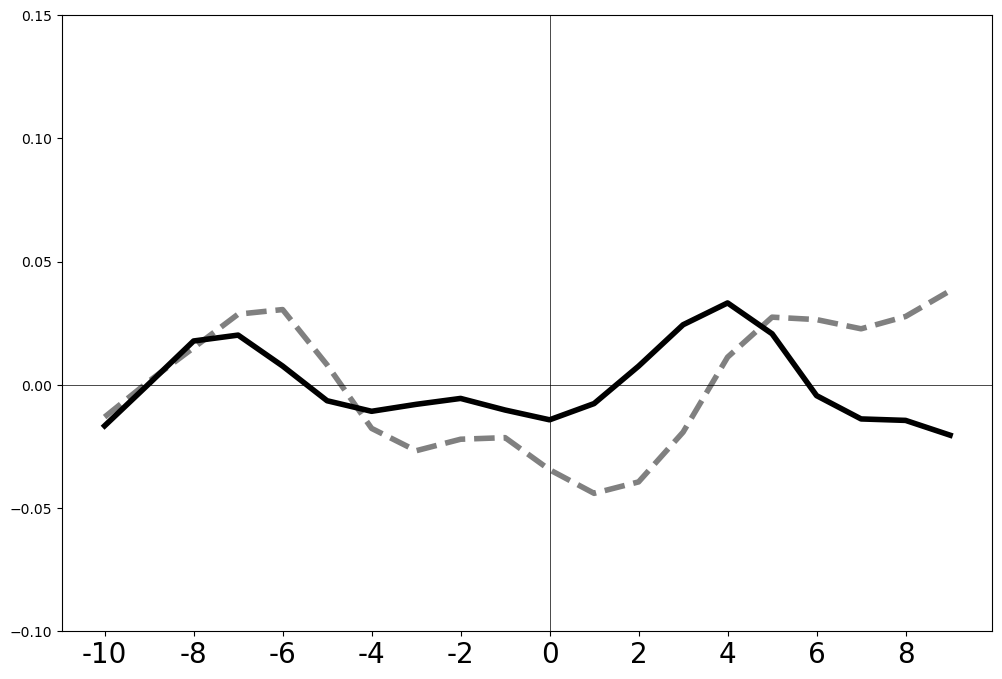

In [387]:
for roi in [3,11,12,26]:
    es_mean_1 =gaussian_smoothing((np.nanmean(es_story_series_mean[roi][0,:,1,:], axis=0)) ,sigma=1)
    es_mean_2 =gaussian_smoothing((np.nanmean(es_story_series_mean[roi][1,:,1,:], axis=0)) ,sigma=1)
    es_mean_3 =gaussian_smoothing((np.nanmean(ss_story_series_mean[roi][0,:,1,:], axis=0)) ,sigma=1)
    es_mean_4 =gaussian_smoothing((np.nanmean(ss_story_series_mean[roi][1,:,1,:], axis=0)) ,sigma=1)    
    
    # # 첫 번째 그래프 (es_timeseries1, es_timeseries2s
    f, a = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

    #plt.errorbar(range(es_mean_1.shape[0]),  es_mean_1, yerr=es_timeseries1_std, linewidth=3, color='gray', linestyle='-', label='ES  t1')
    plt.plot(es_mean_2, linewidth=4, color = 'gray', linestyle='--')
    plt.plot(es_mean_1, linewidth=4, color = 'black')


    # 축과 제목 설정
    plt.axvline(x=from_onset, linewidth=0.5, color='black')
    plt.axhline(y=0, linewidth=0.5, color='black')
    plt.ylim([-0.1, 0.15])
    plt.xticks(np.arange(0, 20, 2),  labels=[-10,-8,-6,-4,-2,0,+2,+4,+6,+8],fontsize = 20)
    plt.savefig(f"ES_{roi}.jpg")


    # 두 번째 그래프 (ss_timeseries)
    f, a = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
    #plt.errorbar(range(es_mean_1.shape[0]),  ss_mean_1, yerr=ss_timeseries1_std, linewidth=3, color='gray', linestyle='-', label='ES  t1')
    plt.plot(es_mean_4, linewidth=4, color = 'gray', linestyle='--')
    plt.plot(es_mean_3, linewidth=4, color = 'black')


    # 축과 제목 설정
    plt.axvline(x=from_onset, linewidth=0.5, color='black')
    plt.axhline(y=0, linewidth=0.5, color='black')
    plt.ylim([-0.1, 0.15])
    plt.xticks(np.arange(0, 20, 2),  labels=[-10,-8,-6,-4,-2,0,+2,+4,+6,+8],fontsize = 20)
    plt.savefig(f"SS_{roi}.jpg")




In [416]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

es_cos = np.zeros(4)
ss_cos = np.zeros(4)
for idx, roi in enumerate([3,11,12,26]):
    audio_es =gaussian_smoothing((np.nanmean(es_story_series_mean[roi][1,:,0,:], axis=0)) ,sigma=1)
    audio_ss =gaussian_smoothing((np.nanmean(ss_story_series_mean[roi][1,:,0,:], axis=0)) ,sigma=1)
    
    visual_es =gaussian_smoothing((np.nanmean(es_story_series_mean[roi][0,:,1,:], axis=0)) ,sigma=1)
    visual_ss =gaussian_smoothing((np.nanmean(ss_story_series_mean[roi][0,:,1,:], axis=0)) ,sigma=1)


    # 코사인 유사도 계산
    print(roi)
    cosine_sim = cosine_similarity(audio_es.reshape(1, -1), visual_es.reshape(1, -1))[0, 0]
    print(f"ES Cosine Similarity: {cosine_sim:.4f}")
    es_cos[idx] = cosine_sim
    cosine_sim = cosine_similarity(audio_ss.reshape(1, -1), visual_ss.reshape(1, -1))[0, 0]
    print(f"SS Cosine Similarity: {cosine_sim:.4f}")
    ss_cos[idx] = cosine_sim


    # 피어슨 상관 계수 계산
    corr, p_value = pearsonr(audio_es, visual_es)
    print(f"ES Pearson Correlation: {corr:.4f}, p-value: {p_value:.4f}")
    corr, p_value = pearsonr(audio_ss, visual_ss)
    print(f"SS Pearson Correlation: {corr:.4f}, p-value: {p_value:.4f}")

3
ES Cosine Similarity: 0.5862
SS Cosine Similarity: 0.3716
ES Pearson Correlation: 0.5862, p-value: 0.0066
SS Pearson Correlation: 0.3716, p-value: 0.1067
11
ES Cosine Similarity: 0.7687
SS Cosine Similarity: 0.7293
ES Pearson Correlation: 0.7687, p-value: 0.0001
SS Pearson Correlation: 0.7293, p-value: 0.0003
12
ES Cosine Similarity: 0.2923
SS Cosine Similarity: 0.5678
ES Pearson Correlation: 0.2923, p-value: 0.2111
SS Pearson Correlation: 0.5678, p-value: 0.0090
26
ES Cosine Similarity: 0.6632
SS Cosine Similarity: 0.4451
ES Pearson Correlation: 0.6632, p-value: 0.0014
SS Pearson Correlation: 0.4451, p-value: 0.0492


In [417]:
es_cos= np.append(es_cos,es_cos.mean())
ss_cos= np.append(ss_cos,ss_cos.mean())
print(es_cos)
print(ss_cos)

[0.58621621 0.76872051 0.29231433 0.66318874 0.57760995]
[0.37161647 0.72930492 0.56781157 0.44514325 0.52846905]


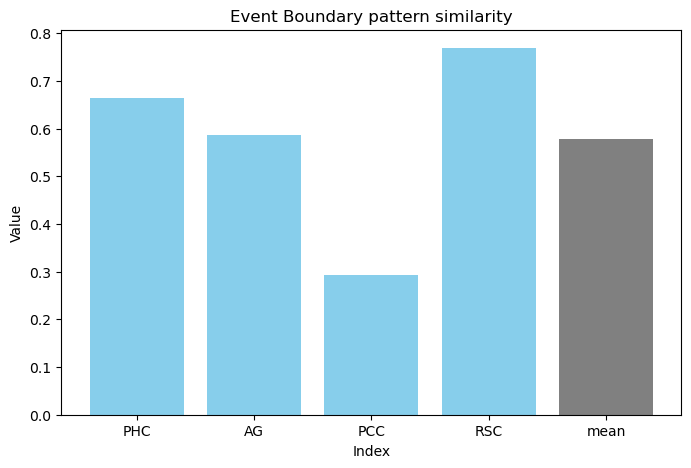

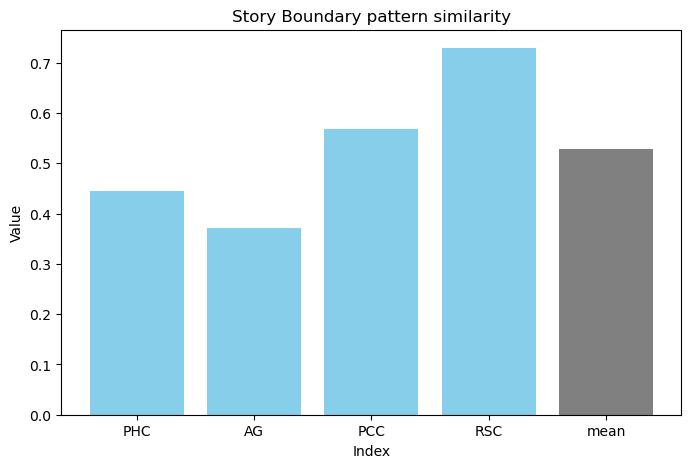

In [419]:
import numpy as np
import matplotlib.pyplot as plt

es_cos = [ 0.66318874, 0.58621621, 0.29231433,0.76872051 , 0.57760995]
ss_cos = [0.44514325, 0.37161647, 0.56781157,0.72930492, 0.52846905]
# 배열 생성
# 막대 그래프 그리기
plt.figure(figsize=(8, 5))
plt.bar(range(len(es_cos)), es_cos, color=['skyblue','skyblue','skyblue','skyblue','gray'])
plt.title("Event Boundary pattern similarity")
plt.xticks(ticks=range(len(es_cos)), labels=['PHC', 'AG', 'PCC', 'RSC','mean'])
plt.xlabel("Index")
plt.ylabel("Value")
plt.savefig(f"ES_cos.jpg")

plt.figure(figsize=(8, 5))
plt.bar(range(len(ss_cos)), ss_cos, color=['skyblue','skyblue','skyblue','skyblue','gray'])
plt.title("Story Boundary pattern similarity")
plt.xticks(ticks=range(len(ss_cos)), labels=['PHC', 'AG', 'PCC', 'RSC','mean'])
plt.xlabel("Index")
plt.ylabel("Value")
plt.savefig(f"SS_cos.jpg")
plt.show()



In [328]:
import numpy as np
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# ROI 데이터 (예시)
for roi in roi_idx: 
    # New Event 부분
    print(f"--- ROI {roi} ---")
    
    # 새로운 이벤트 시점 분석
    es_mean_1 =gaussian_smoothing((np.nanmean(es_story_series_mean[roi][0,:,0,:], axis=0)),sigma=1)
    es_mean_2 =gaussian_smoothing((np.nanmean(es_story_series_mean[roi][0,:,1,:], axis=0)),sigma=1)
    event_timepoints = es_mean_1.shape[0]  # Time points for new events

    # 시점별 데이터 저장
    all_timepoints_data_t1 = []
    all_timepoints_data_t2 = []

    # 각 시점에서의 데이터 수집 (새로운 이벤트)
    for time in range(event_timepoints):
        es_t1_samples = es_story_series_mean[roi][0,:30,0,time]  # t1 샘플
        es_t2_samples = es_story_series_mean[roi][0,:30,1,time]  # t2 샘플

        all_timepoints_data_t1.append(es_t1_samples)
        all_timepoints_data_t2.append(es_t2_samples)

    # 시점별로 대응표본 t-검정 수행 및 p-value 저장
    post_hoc_p_values = []
    for t in range(event_timepoints):
        t_stat, post_hoc_p = ttest_rel(all_timepoints_data_t1[t], all_timepoints_data_t2[t])
        post_hoc_p_values.append(post_hoc_p)

    # FDR 보정 수행 (다중 비교 문제 해결을 위해)
    corrected_p_values = multipletests(post_hoc_p_values, alpha=0.05, method='fdr_bh')[1]

    # 유의미한 시점 찾기 (과학적 표기법을 소수점 형식으로 변환 후 비교)
    significant_times = np.where(corrected_p_values < 0.05)[0]

    # 소수점 표기법으로 변환하여 p-values 출력
    formatted_p_values = [f"{p_value:.10f}" for p_value in corrected_p_values]
    #print(formatted_p_values)

    # 유의미한 시점 출력
    if len(significant_times) > 0:
        print(f"Significant time points after new event: {significant_times}")#, Corrected p-values: {formatted_p_values}")
    else:
        print("No significant time points found after new event.")

    # New Story 부분
    story_timepoints = event_timepoints  # New Story와 New Event의 시간포인트는 동일하게 설정

    # 새로운 이야기 시점 분석
    es_mean_1 =gaussian_smoothing((np.nanmean(ss_story_series_mean[roi][0,:,0,:], axis=0)) ,sigma=1)
    es_mean_2 =gaussian_smoothing((np.nanmean(ss_story_series_mean[roi][0,:,1,:], axis=0)) ,sigma=1)

    # 시점별 데이터 저장
    all_timepoints_data_t1 = []
    all_timepoints_data_t2 = []

    # 각 시점에서의 데이터 수집 (새로운 이야기)
    for time in range(story_timepoints):
        es_t1_samples = ss_story_series_mean[roi][0,:30,0,time]  # t1 샘플
        es_t2_samples = ss_story_series_mean[roi][0,:30,1,time]  # t2 샘플

        all_timepoints_data_t1.append(es_t1_samples)
        all_timepoints_data_t2.append(es_t2_samples)

    # 시점별로 대응표본 t-검정 수행 및 p-value 저장
    post_hoc_p_values = []
    for t in range(story_timepoints):
        t_stat, post_hoc_p = ttest_rel(all_timepoints_data_t1[t], all_timepoints_data_t2[t])
        post_hoc_p_values.append(post_hoc_p)

    # FDR 보정 수행 (다중 비교 문제 해결을 위해)
    corrected_p_values = multipletests(post_hoc_p_values, alpha=0.05, method='fdr_bh')[1]

    # 유의미한 시점 찾기
    significant_times = np.where(corrected_p_values < 0.05)[0]

    # 소수점 표기법으로 변환하여 p-values 출력
    formatted_p_values = [f"{p_value:.10f}" for p_value in corrected_p_values]

    # 유의미한 시점 출력
    if len(significant_times) > 0:
        print(f"Significant time points after new story: {significant_times}")#, Corrected p-values: {formatted_p_values}")
    else:
        print("No significant time points found after new story.")


--- ROI 0 ---
No significant time points found after new event.
Significant time points after new story: [ 7  9 16 18 19]
--- ROI 1 ---
Significant time points after new event: [ 9 18 19]
Significant time points after new story: [ 2  3  4  5  7  8  9 11 15 16 17 18 19]
--- ROI 2 ---
Significant time points after new event: [ 0  5  9 18 19]
Significant time points after new story: [ 1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19]
--- ROI 3 ---
Significant time points after new event: [ 4  5 13 14]
Significant time points after new story: [ 8 19]
--- ROI 4 ---
Significant time points after new event: [14]
No significant time points found after new story.
--- ROI 5 ---
Significant time points after new event: [ 4  5  6 14 15]
Significant time points after new story: [14]
--- ROI 6 ---
Significant time points after new event: [ 4  5 13 18]
No significant time points found after new story.
--- ROI 8 ---
Significant time points after new event: [4]
No significant time points found afte

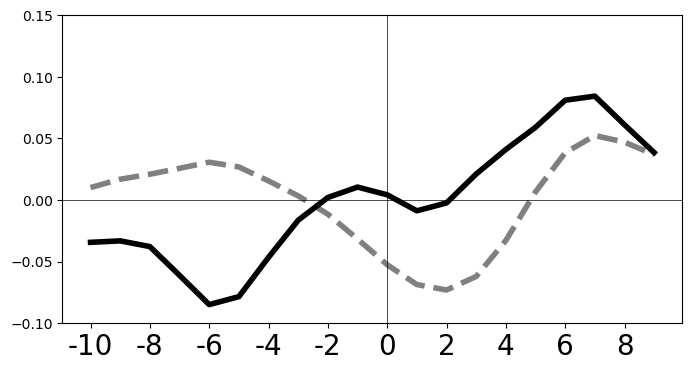

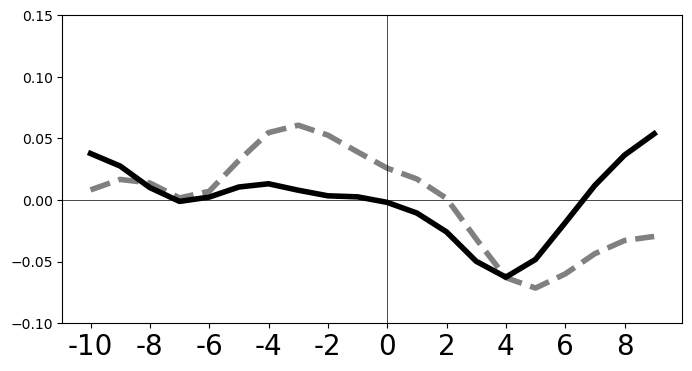

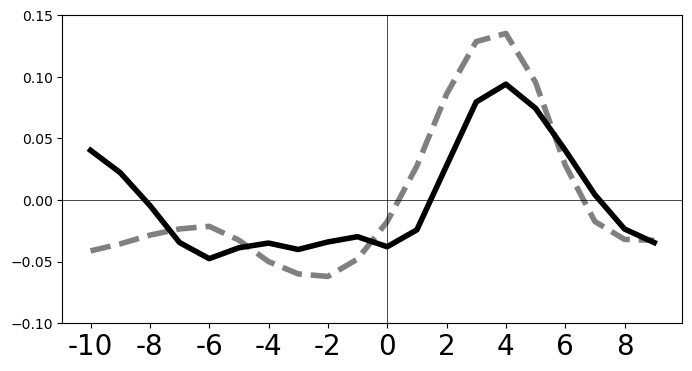

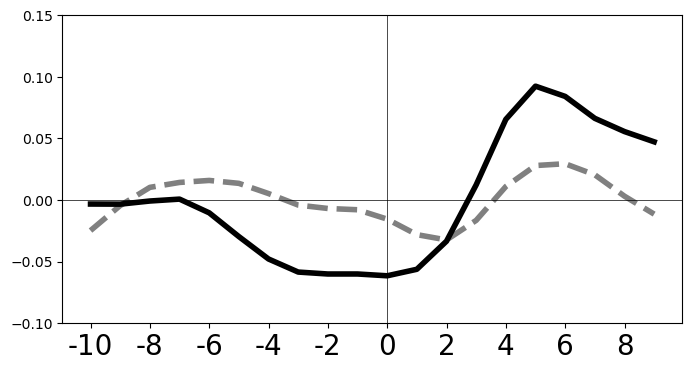

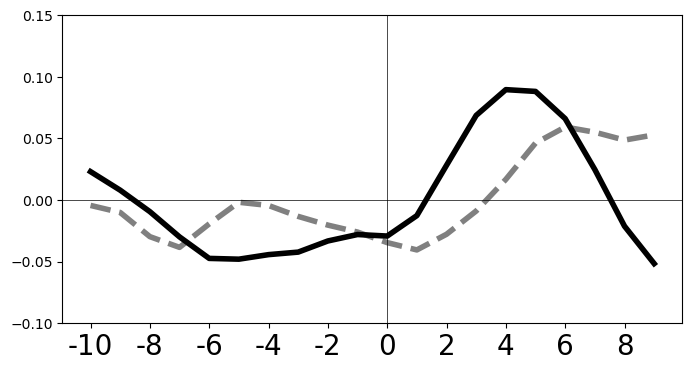

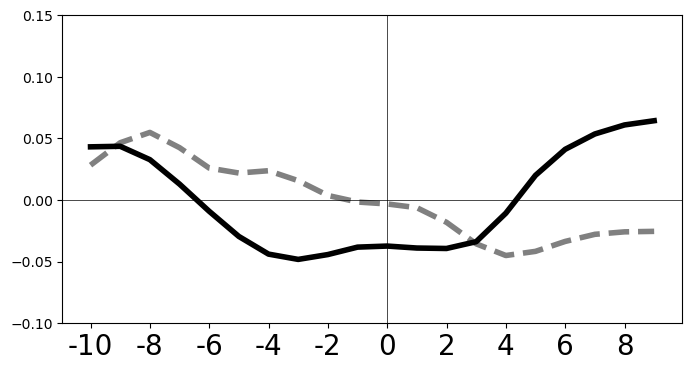

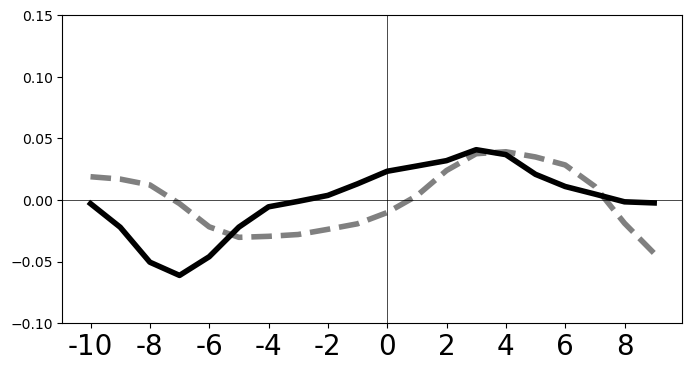

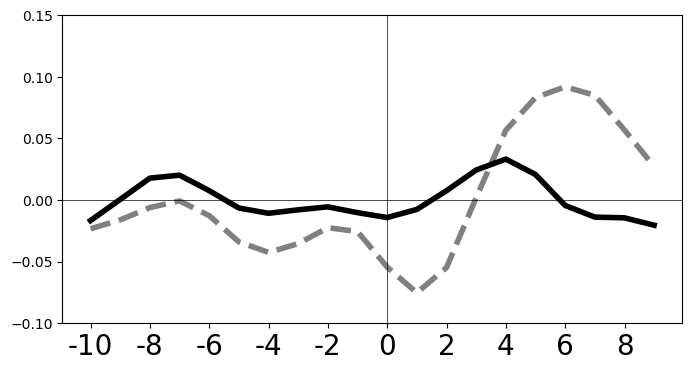

In [382]:
for roi in [3,11,12,26]:
    es_mean_1 =gaussian_smoothing((np.nanmean(es_story_series_mean[roi][0,:,0,:], axis=0)) ,sigma=1) #visual 
    es_mean_2 =gaussian_smoothing((np.nanmean(es_story_series_mean[roi][0,:,1,:], axis=0)) ,sigma=1)
    es_mean_3 =gaussian_smoothing((np.nanmean(ss_story_series_mean[roi][0,:,0,:], axis=0)) ,sigma=1)
    es_mean_4 =gaussian_smoothing((np.nanmean(ss_story_series_mean[roi][0,:,1,:], axis=0)) ,sigma=1)    
    
    # # 첫 번째 그래프 (es_timeseries1, es_timeseries2s
    f, a = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

    #plt.errorbar(range(es_mean_1.shape[0]),  es_mean_1, yerr=es_timeseries1_std, linewidth=3, color='gray', linestyle='-', label='ES  t1')
    plt.plot(es_mean_1, linewidth=4, color = 'gray', linestyle='--')
    plt.plot(es_mean_2, linewidth=4, color = 'black')


    # 축과 제목 설정
    plt.axvline(x=from_onset, linewidth=0.5, color='black')
    plt.axhline(y=0, linewidth=0.5, color='black')
    plt.ylim([-0.1, 0.15])
    plt.xticks(np.arange(0, 20, 2),  labels=[-10,-8,-6,-4,-2,0,+2,+4,+6,+8],fontsize = 20)
    #plt.savefig(f"ES_{roi}.jpg")


    # 두 번째 그래프 (ss_timeseries)
    f, a = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
    #plt.errorbar(range(es_mean_1.shape[0]),  ss_mean_1, yerr=ss_timeseries1_std, linewidth=3, color='gray', linestyle='-', label='ES  t1')
    plt.plot(es_mean_3, linewidth=4, color = 'gray', linestyle='--')
    plt.plot(es_mean_4, linewidth=4, color = 'black')


    # 축과 제목 설정
    plt.axvline(x=from_onset, linewidth=0.5, color='black')
    plt.axhline(y=0, linewidth=0.5, color='black')
    plt.ylim([-0.1, 0.15])
    plt.xticks(np.arange(0, 20, 2),  labels=[-10,-8,-6,-4,-2,0,+2,+4,+6,+8],fontsize = 20)
    #plt.savefig(f"SS_{roi}.jpg")




# Correlation with Behavior scores

In [41]:
import numpy as np
content_score_matrix_va = np.load('/home/sincerely/jupyterlab/3. Behav/VCNL/results/all_story_content_score_matrix_va2.npy')
content_score_matrix_av = np.load('/home/sincerely/jupyterlab/3. Behav/VCNL/results/all_story_content_score_matrix_av2.npy')

mean_content_score_matrix_va = content_score_matrix_va.mean(axis=(0,1)) # subj * task 
mean_content_score_matrix_av = content_score_matrix_av.mean(axis=(0,1))   
mean_content_score_va  = mean_content_score_matrix_va[:,1] -mean_content_score_matrix_va[:,0]
mean_content_score_av  = mean_content_score_matrix_av[:,1] -mean_content_score_matrix_av[:,0]


# Load the data
retrieval_va = np.load('/home/sincerely/jupyterlab/3. Behav/VCNL/results/all_story_retrieval_score_matrix_va2.npy')
retrieval_av = np.load('/home/sincerely/jupyterlab/3. Behav/VCNL/results/all_story_retrieval_score_matrix_av2.npy')

mean_retrieval_va = retrieval_va.mean(axis=0)
mean_retrieval_av = retrieval_av.mean(axis=0)

mean_retrieval = np.concatenate([mean_retrieval_va, mean_retrieval_av])
mean_content = np.concatenate([mean_content_score_va, mean_content_score_av])
mean_content1 = np.concatenate([mean_content_score_matrix_va[:,0], mean_content_score_matrix_av[:,0]])
mean_content2 = np.concatenate([ mean_content_score_matrix_va[:,1], mean_content_score_matrix_av[:,1]])

11 14 0.8125502902155126
11 14 0.09284142744531487


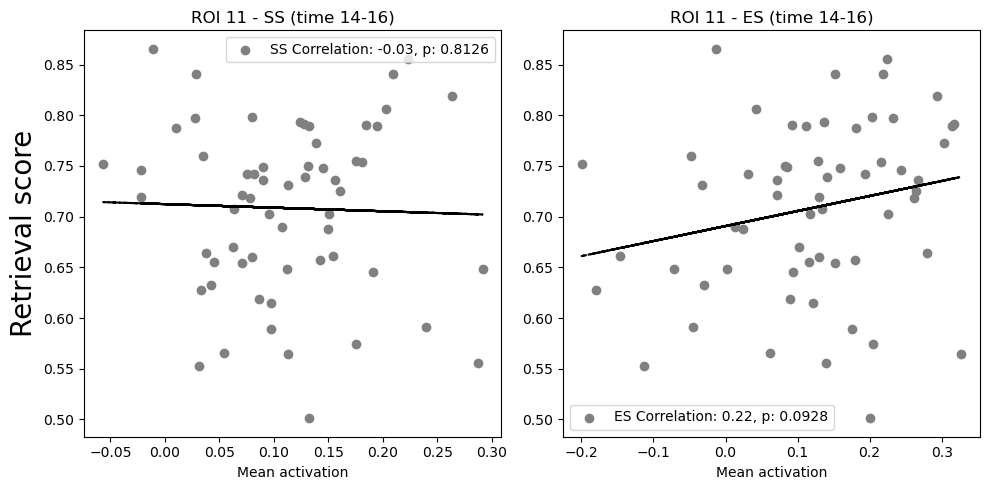

12 14 0.5609302891426141
12 14 0.895782009016058


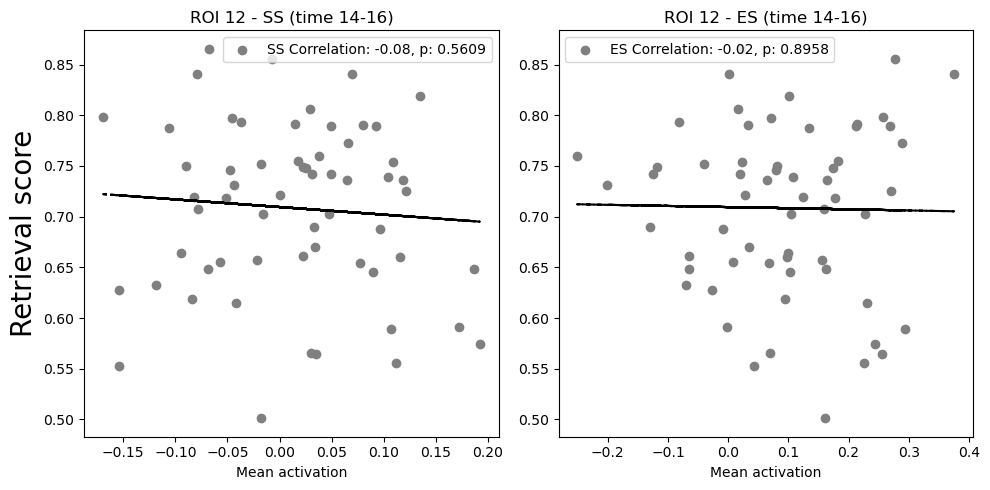

26 14 0.14634432407329373
26 14 0.1571623648688998


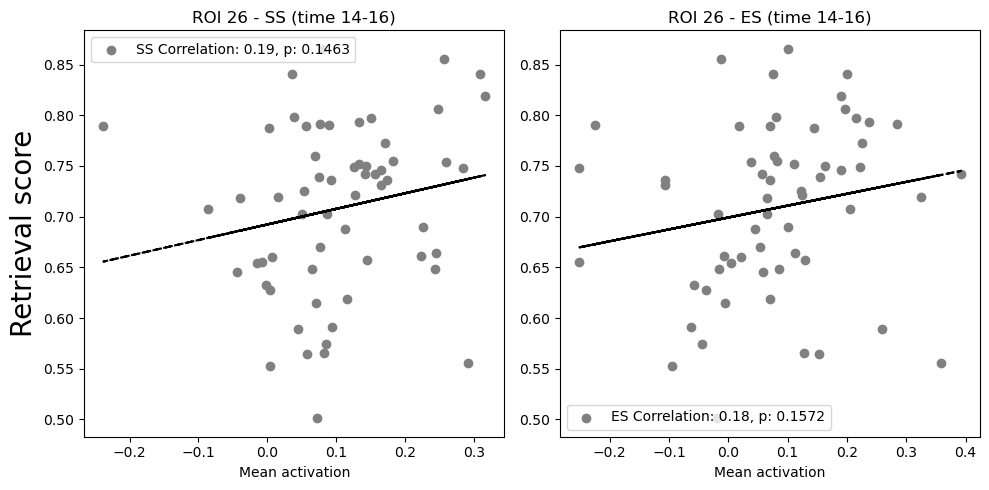

In [602]:
import numpy as np
from scipy.stats import pearsonr, linregress
import matplotlib.pyplot as plt

# 아웃라이어 제거 함수: SS와 ES 모두에서 아웃라이어가 있는 참가자를 제거
def remove_outliers(x, y, threshold=4):
    mean_x, std_x = np.mean(x), np.std(x)
    mean_y, std_y = np.mean(y), np.std(y)
    
    # x 또는 y에서 아웃라이어가 발생하면 해당 참가자를 제거
    valid_indices = (np.abs(x - mean_x) < threshold * std_x) & (np.abs(y - mean_y) < threshold * std_y)
    
    return x[valid_indices], y[valid_indices], valid_indices

# timepoint 설정
timepoints = [14]
bon_p = 0.05 / 1  # Bonferroni 보정

# ROI별로 아웃라이어 제거 후 산포도 및 회귀선 그리기
for roi in [11,12,26]:
    story_ss_mean_series = np.concatenate((ss_story_series_mean[roi, 0, :30, 1, :], ss_story_series_mean[roi, 1, :31, 0, :]))
    story_es_mean_series = np.concatenate((es_story_series_mean[roi, 0, :30, 1, :], es_story_series_mean[roi, 1, :31, 0, :]))

    for s, start in enumerate(timepoints):
        end = start + 2
    

        # SS와 ES 윈도우 평균 계산
        mean_ss_window = story_ss_mean_series[:, start:end].mean(axis=1)
        mean_es_window = story_es_mean_series[:, start:end].mean(axis=1)

        # 아웃라이어 제거 (SS와 ES에서 공통적으로 아웃라이어인 참가자를 제거)
        mean_ss_window_clean, mean_retrieval_clean_ss, _ = remove_outliers(mean_ss_window, mean_retrieval)
        mean_es_window_clean, mean_retrieval_clean_es, _ = remove_outliers(mean_es_window, mean_retrieval)

        # SS 산포도 및 회귀선 그리기
        plt.figure(figsize=(10, 5))

        # SS 산포도 및 회귀선
        plt.subplot(1, 2, 1)
        corr_ss, p_ss = pearsonr(mean_ss_window_clean, mean_retrieval_clean_ss)
        print(roi, start, p_ss)
        slope_ss, intercept_ss, _, _, _ = linregress(mean_ss_window_clean, mean_retrieval_clean_ss)

        plt.scatter(mean_ss_window_clean, mean_retrieval_clean_ss, color='gray', label=f'SS Correlation: {corr_ss:.2f}, p: {p_ss:.4f}')
        plt.plot(mean_ss_window_clean, slope_ss * mean_ss_window_clean + intercept_ss, color='black', linestyle='--')
        plt.title(f'ROI {roi} - SS (time {start}-{end})')
        plt.xlabel('Mean activation')
        plt.ylabel('Retrieval score', fontsize = 20 )
        plt.legend()
        plt.grid(False)
        plt.tight_layout()
        #plt.savefig(f"{ROI}_content_es.jpg")

        # ES 산포도 및 회귀선
        plt.subplot(1, 2, 2)
        corr_es, p_es = pearsonr(mean_es_window_clean, mean_retrieval_clean_es)
        print(roi, start, p_es)
        slope_es, intercept_es, _, _, _ = linregress(mean_es_window_clean, mean_retrieval_clean_es)

        plt.scatter(mean_es_window_clean, mean_retrieval_clean_es, color='gray', label=f'ES Correlation: {corr_es:.2f}, p: {p_es:.4f}')
        plt.plot(mean_es_window_clean, slope_es * mean_es_window_clean + intercept_es, color='black', linestyle='--')
        plt.title(f'ROI {roi} - ES (time {start}-{end})')
        plt.xlabel('Mean activation')
        #plt.ylabel('Retrieval')
        plt.legend()
        plt.grid(False)

        plt.tight_layout()
        # plt.savefig(f"{roi}_content_es.jpg")
        plt.show()

3 11 0.046154426756583364
3 11 0.06205148621591687


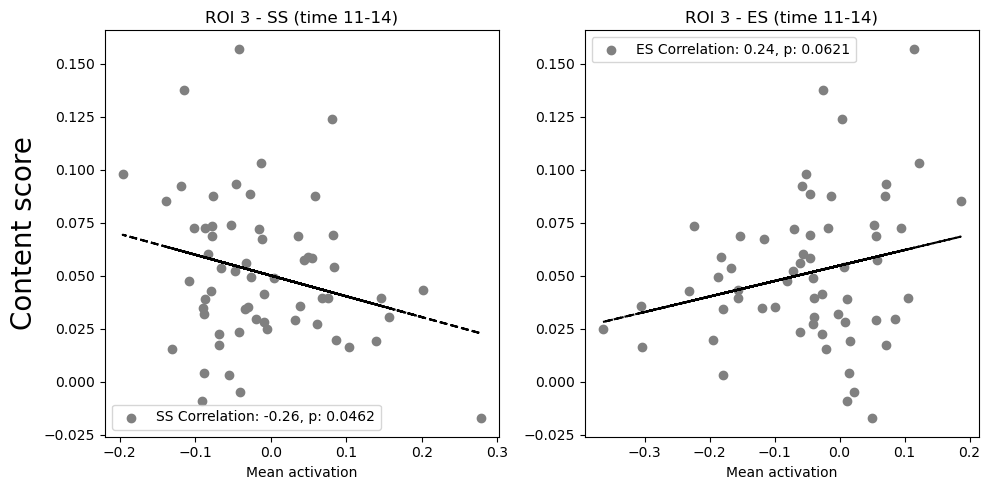

11 11 0.3284347265949303
11 11 0.955470621361143


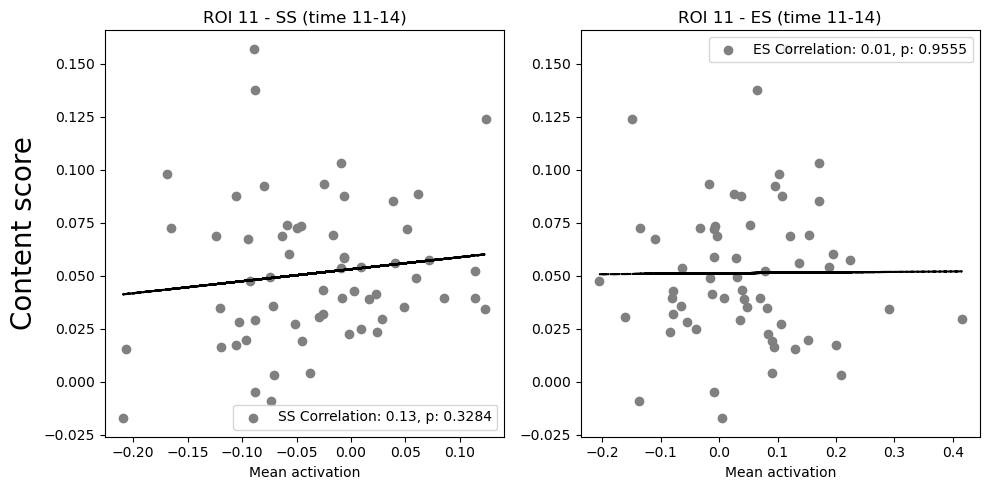

12 11 0.8111726991455278
12 11 0.04842612057206633


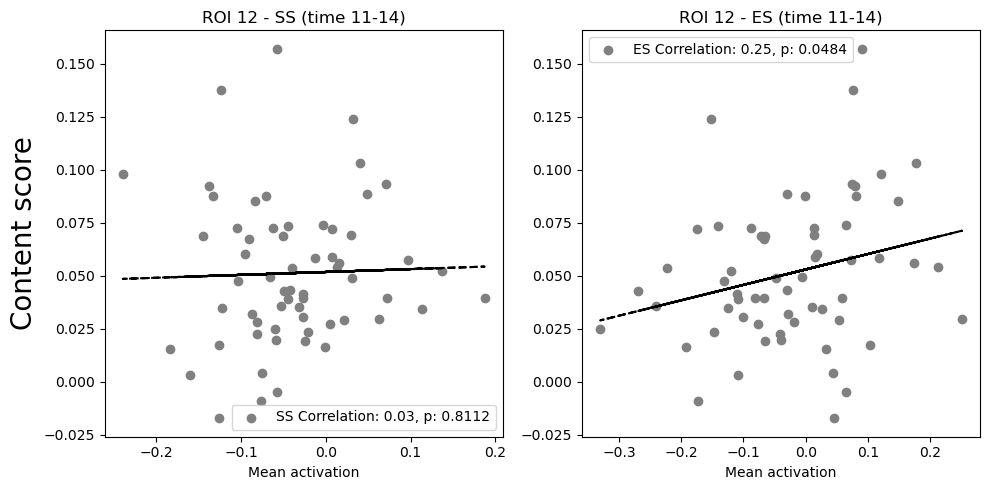

26 11 0.041087060155066385
26 11 0.47804972018119096


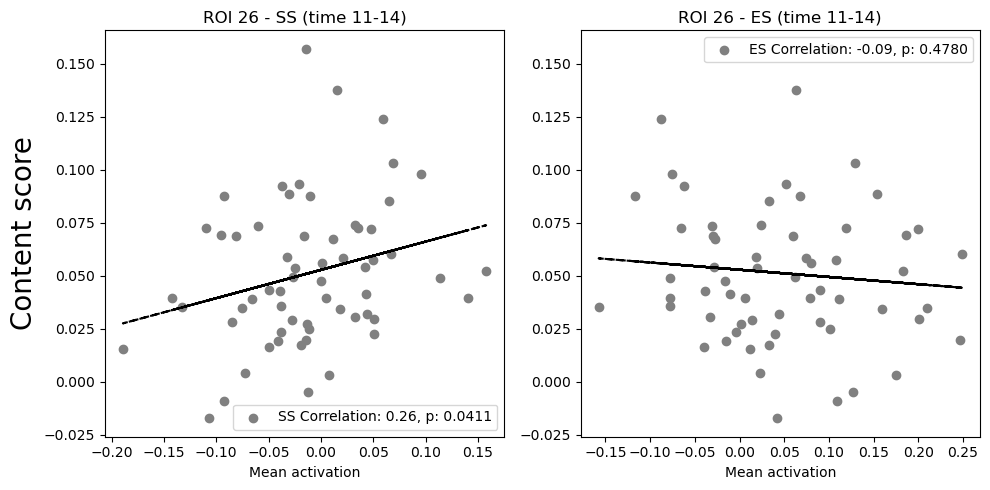

In [503]:
import numpy as np
from scipy.stats import pearsonr, linregress
import matplotlib.pyplot as plt

# 아웃라이어 제거 함수: SS와 ES 모두에서 아웃라이어가 있는 참가자를 제거
def remove_outliers(x, y, threshold=4):
    mean_x, std_x = np.mean(x), np.std(x)
    mean_y, std_y = np.mean(y), np.std(y)
    
    # x 또는 y에서 아웃라이어가 발생하면 해당 참가자를 제거
    valid_indices = (np.abs(x - mean_x) < threshold * std_x) & (np.abs(y - mean_y) < threshold * std_y)
    
    return x[valid_indices], y[valid_indices], valid_indices

# timepoint 설정
timepoints = [11]
#bon_p = 0.05 / 1  # Bonferroni 보정

# ROI별로 아웃라이어 제거 후 산포도 및 회귀선 그리기
for roi in [3,11,12,26]:
    story_ss_mean_series = np.concatenate((ss_story_series_mean[roi, 0, :30, 1, :], ss_story_series_mean[roi, 1, :31, 0, :]))
    story_es_mean_series = np.concatenate((es_story_series_mean[roi, 0, :30, 1, :], es_story_series_mean[roi, 1, :31, 0, :]))

    for s, start in enumerate(timepoints):
        end = start + 3
    

        # SS와 ES 윈도우 평균 계산
        mean_ss_window = story_ss_mean_series[:, start:end].mean(axis=1)
        mean_es_window = story_es_mean_series[:, start:end].mean(axis=1)

        # 아웃라이어 제거 (SS와 ES에서 공통적으로 아웃라이어인 참가자를 제거)
        mean_ss_window_clean, mean_retrieval_clean_ss, _ = remove_outliers(mean_ss_window, mean_content)
        mean_es_window_clean, mean_retrieval_clean_es, _ = remove_outliers(mean_es_window, mean_content)

        # SS 산포도 및 회귀선 그리기
        plt.figure(figsize=(10, 5))

        # SS 산포도 및 회귀선
        plt.subplot(1, 2, 1)
        corr_ss, p_ss = pearsonr(mean_ss_window_clean, mean_retrieval_clean_ss)
        print(roi, start, p_ss)
        slope_ss, intercept_ss, _, _, _ = linregress(mean_ss_window_clean, mean_retrieval_clean_ss)

        plt.scatter(mean_ss_window_clean, mean_retrieval_clean_ss, color='gray', label=f'SS Correlation: {corr_ss:.2f}, p: {p_ss:.4f}')
        plt.plot(mean_ss_window_clean, slope_ss * mean_ss_window_clean + intercept_ss, color='black', linestyle='--')
        plt.title(f'ROI {roi} - SS (time {start}-{end})')
        plt.xlabel('Mean activation')
        plt.ylabel('Content score', fontsize = 20 )
        plt.legend()
        plt.grid(False)
        plt.tight_layout()
        #plt.savefig(f"{ROI}_content_es.jpg")

        # ES 산포도 및 회귀선
        plt.subplot(1, 2, 2)
        corr_es, p_es = pearsonr(mean_es_window_clean, mean_retrieval_clean_es)
        print(roi, start, p_es)
        slope_es, intercept_es, _, _, _ = linregress(mean_es_window_clean, mean_retrieval_clean_es)

        plt.scatter(mean_es_window_clean, mean_retrieval_clean_es, color='gray', label=f'ES Correlation: {corr_es:.2f}, p: {p_es:.4f}')
        plt.plot(mean_es_window_clean, slope_es * mean_es_window_clean + intercept_es, color='black', linestyle='--')
        plt.title(f'ROI {roi} - ES (time {start}-{end})')
        plt.xlabel('Mean activation')
        #plt.ylabel('Retrieval')
        plt.legend()
        plt.grid(False)

        plt.tight_layout()
        # plt.savefig(f"{roi}_content_es.jpg")
        plt.show()

In [76]:
ss_story_series_mean[roi, 0, :30, 1, :].shape

(30, 20)

3 11 0.030063152384552108
3 11 0.4319108134449282


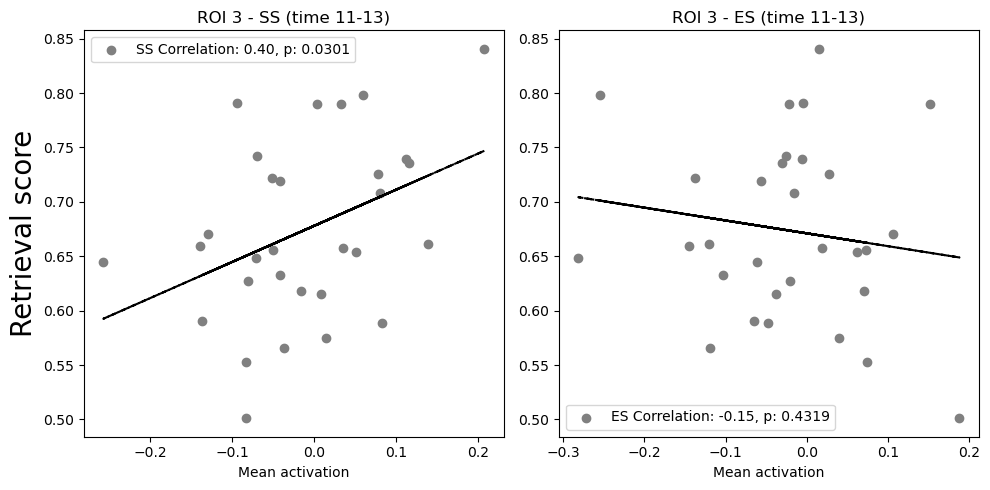

12 11 0.8527133903845204
12 11 0.32007043870999424


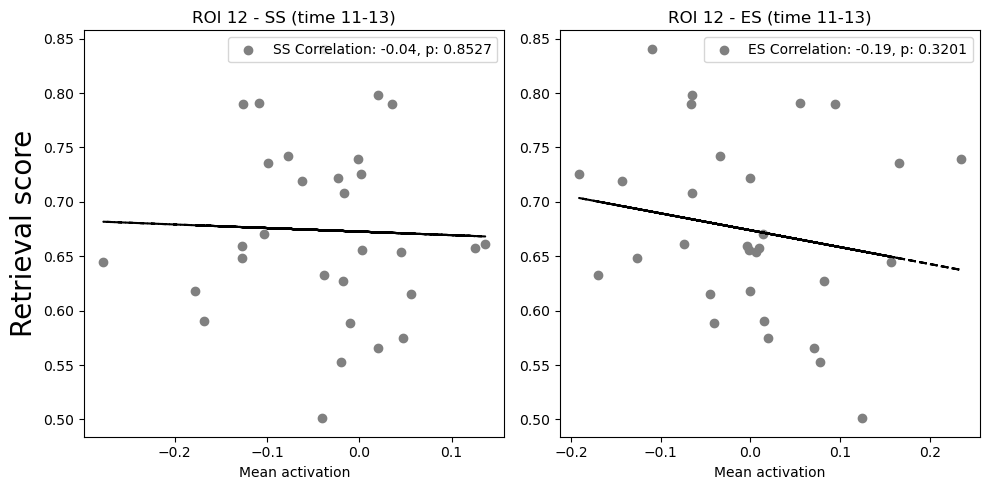

11 11 0.578649199358004
11 11 0.1822717041287141


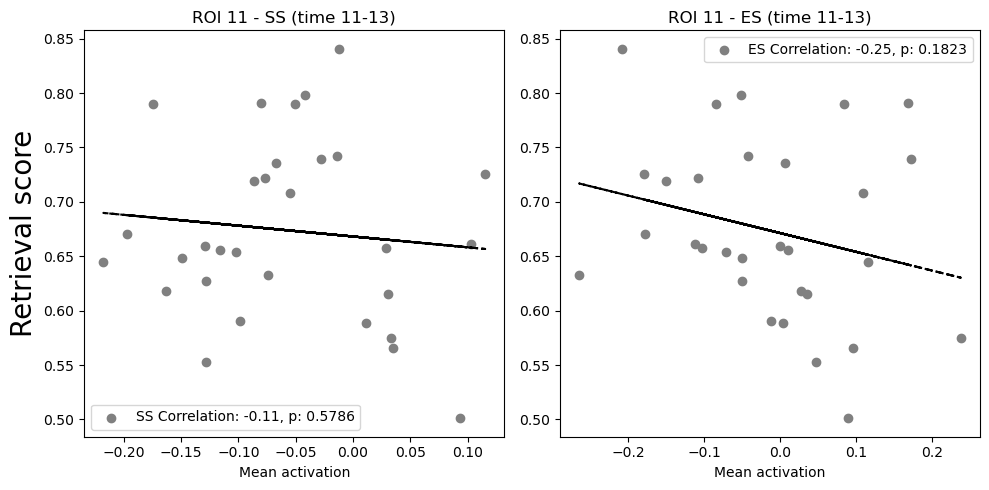

26 11 0.773827605978955
26 11 0.5663124460135939


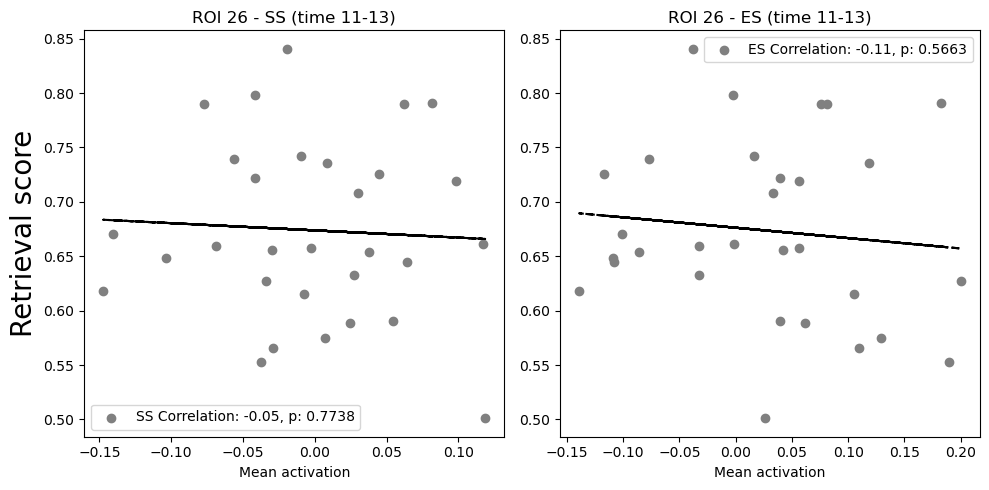

In [591]:
import numpy as np
from scipy.stats import pearsonr, linregress
import matplotlib.pyplot as plt

# 아웃라이어 제거 함수: SS와 ES 모두에서 아웃라이어가 있는 참가자를 제거
def remove_outliers(x, y, threshold=4):
    mean_x, std_x = np.mean(x), np.std(x)
    mean_y, std_y = np.mean(y), np.std(y)
    
    # x 또는 y에서 아웃라이어가 발생하면 해당 참가자를 제거
    valid_indices = (np.abs(x - mean_x) < threshold * std_x) & (np.abs(y - mean_y) < threshold * std_y)
    
    return x[valid_indices], y[valid_indices], valid_indices

# timepoint 설정
timepoints = [11]
bon_p = 0.05 / 1  # Bonferroni 보정

# ROI별로 아웃라이어 제거 후 산포도 및 회귀선 그리기
for roi in [3,12,11,26]:
    # story_ss_mean_series = np.concatenate((ss_story_series_mean[roi, 0, :30, 1, :]))#, ss_story_series_mean[roi, 1, :31, 0, :]))
    # story_es_mean_series = np.concatenate((es_story_series_mean[roi, 0, :30, 1, :]))#, es_story_series_mean[roi, 1, :31, 0, :]))

    for s, start in enumerate(timepoints):
        end = start + 2

        # SS와 ES 윈도우 평균 계산
        mean_ss_window = ss_story_series_mean[roi, 0, :30, 1, start:end].mean(axis=1)
        mean_es_window = es_story_series_mean[roi, 0, :30, 1, start:end].mean(axis=1)

        # 아웃라이어 제거 (SS와 ES에서 공통적으로 아웃라이어인 참가자를 제거)
        mean_ss_window_clean, mean_retrieval_clean_ss, _ = remove_outliers(mean_ss_window, mean_retrieval_va)
        mean_es_window_clean, mean_retrieval_clean_es, _ = remove_outliers(mean_es_window, mean_retrieval_va)

        # SS 산포도 및 회귀선 그리기
        plt.figure(figsize=(10, 5))

        # SS 산포도 및 회귀선
        plt.subplot(1, 2, 1)
        corr_ss, p_ss = pearsonr(mean_ss_window_clean, mean_retrieval_clean_ss)
        print(roi, start, p_ss)
        slope_ss, intercept_ss, _, _, _ = linregress(mean_ss_window_clean, mean_retrieval_clean_ss)

        plt.scatter(mean_ss_window_clean, mean_retrieval_clean_ss, color='gray', label=f'SS Correlation: {corr_ss:.2f}, p: {p_ss:.4f}')
        plt.plot(mean_ss_window_clean, slope_ss * mean_ss_window_clean + intercept_ss, color='black', linestyle='--')
        plt.title(f'ROI {roi} - SS (time {start}-{end})')
        plt.xlabel('Mean activation')
        plt.ylabel('Retrieval score', fontsize = 20 )
        plt.legend()
        plt.grid(False)
        plt.tight_layout()
        #plt.savefig(f"{ROI}_content_es.jpg")

        # ES 산포도 및 회귀선
        plt.subplot(1, 2, 2)
        corr_es, p_es = pearsonr(mean_es_window_clean, mean_retrieval_clean_es)
        print(roi, start, p_es)
        slope_es, intercept_es, _, _, _ = linregress(mean_es_window_clean, mean_retrieval_clean_es)

        plt.scatter(mean_es_window_clean, mean_retrieval_clean_es, color='gray', label=f'ES Correlation: {corr_es:.2f}, p: {p_es:.4f}')
        plt.plot(mean_es_window_clean, slope_es * mean_es_window_clean + intercept_es, color='black', linestyle='--')
        plt.title(f'ROI {roi} - ES (time {start}-{end})')
        plt.xlabel('Mean activation')
        #plt.ylabel('Retrieval')
        plt.legend()
        plt.grid(False)

        plt.tight_layout()
        # plt.savefig(f"{roi}_content_es.jpg")
        plt.show()

3 12 0.8573500822215265
3 12 0.5140562647484289


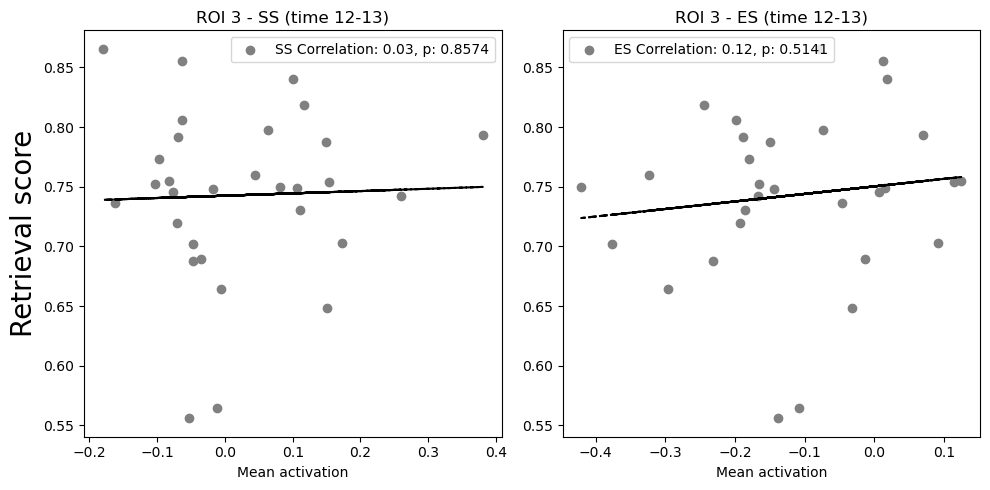

11 12 0.34877068883070295
11 12 0.031023154688932172


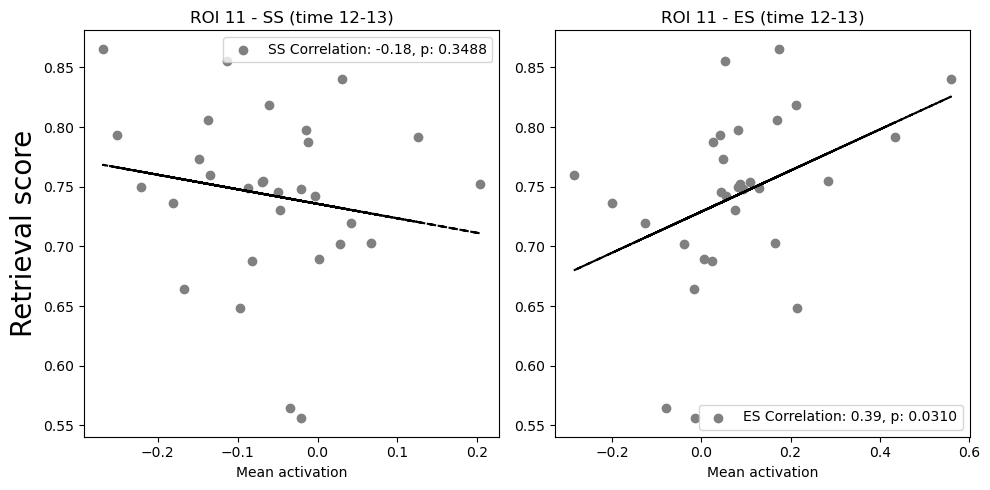

12 12 0.27193544426238886
12 12 0.019426641309913204


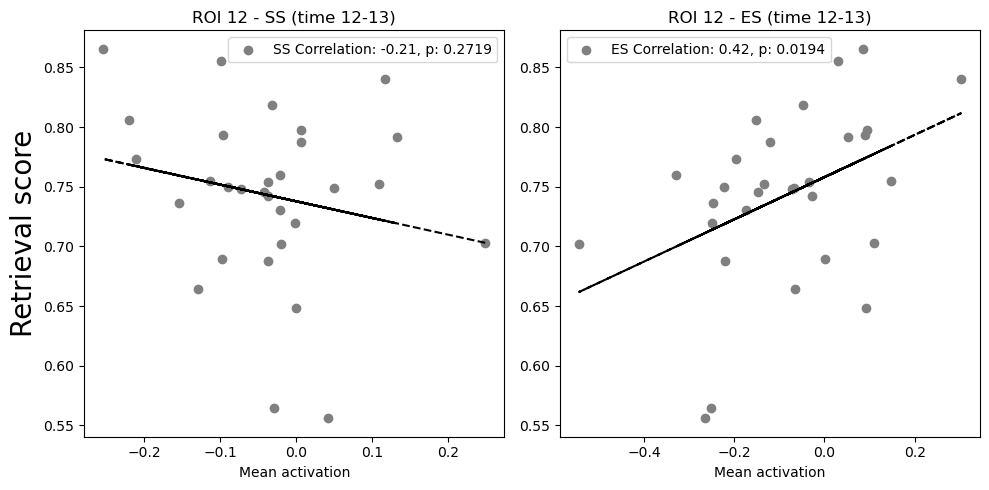

26 12 0.0738848800001425
26 12 0.1726468174019025


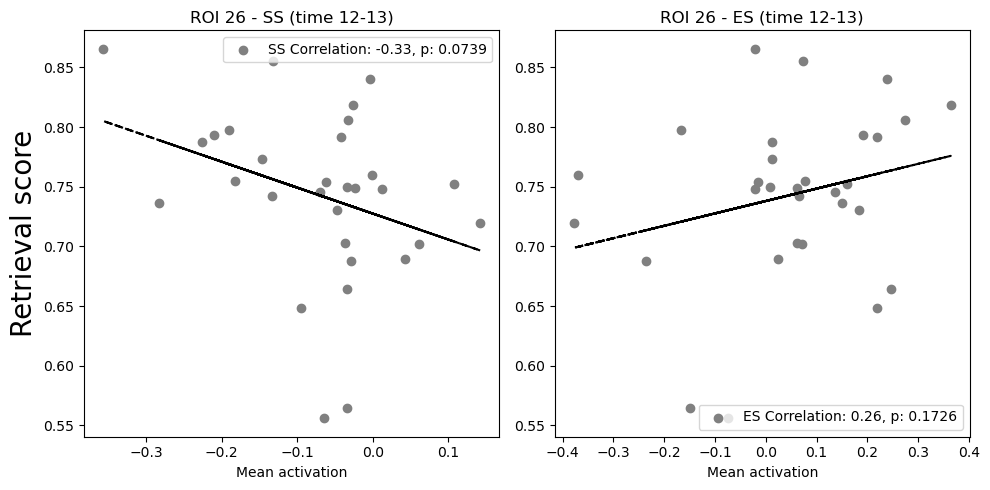

In [528]:
import numpy as np
from scipy.stats import pearsonr, linregress
import matplotlib.pyplot as plt

# 아웃라이어 제거 함수: SS와 ES 모두에서 아웃라이어가 있는 참가자를 제거
def remove_outliers(x, y, threshold=4):
    mean_x, std_x = np.mean(x), np.std(x)
    mean_y, std_y = np.mean(y), np.std(y)
    
    # x 또는 y에서 아웃라이어가 발생하면 해당 참가자를 제거
    valid_indices = (np.abs(x - mean_x) < threshold * std_x) & (np.abs(y - mean_y) < threshold * std_y)
    
    return x[valid_indices], y[valid_indices], valid_indices

# timepoint 설정
timepoints = [12]
bon_p = 0.05 / 1  # Bonferroni 보정

# ROI별로 아웃라이어 제거 후 산포도 및 회귀선 그리기
for roi in [3,11,12,26]:
    # story_ss_mean_series = np.concatenate((ss_story_series_mean[roi, 0, :30, 1, :]))#, ss_story_series_mean[roi, 1, :31, 0, :]))
    # story_es_mean_series = np.concatenate((es_story_series_mean[roi, 0, :30, 1, :]))#, es_story_series_mean[roi, 1, :31, 0, :]))

    for s, start in enumerate(timepoints):
        end = start + 1

        # SS와 ES 윈도우 평균 계산
        mean_ss_window = ss_story_series_mean[roi, 1, :31, 0, start:end].mean(axis=1)
        mean_es_window = es_story_series_mean[roi, 1, :31, 0, start:end].mean(axis=1)

        # 아웃라이어 제거 (SS와 ES에서 공통적으로 아웃라이어인 참가자를 제거)
        mean_ss_window_clean, mean_retrieval_clean_ss, _ = remove_outliers(mean_ss_window, mean_retrieval_av)
        mean_es_window_clean, mean_retrieval_clean_es, _ = remove_outliers(mean_es_window, mean_retrieval_av)

        # SS 산포도 및 회귀선 그리기
        plt.figure(figsize=(10, 5))

        # SS 산포도 및 회귀선
        plt.subplot(1, 2, 1)
        corr_ss, p_ss = pearsonr(mean_ss_window_clean, mean_retrieval_clean_ss)
        print(roi, start, p_ss)
        slope_ss, intercept_ss, _, _, _ = linregress(mean_ss_window_clean, mean_retrieval_clean_ss)

        plt.scatter(mean_ss_window_clean, mean_retrieval_clean_ss, color='gray', label=f'SS Correlation: {corr_ss:.2f}, p: {p_ss:.4f}')
        plt.plot(mean_ss_window_clean, slope_ss * mean_ss_window_clean + intercept_ss, color='black', linestyle='--')
        plt.title(f'ROI {roi} - SS (time {start}-{end})')
        plt.xlabel('Mean activation')
        plt.ylabel('Retrieval score', fontsize = 20 )
        plt.legend()
        plt.grid(False)
        plt.tight_layout()
        #plt.savefig(f"{ROI}_content_es.jpg")

        # ES 산포도 및 회귀선
        plt.subplot(1, 2, 2)
        corr_es, p_es = pearsonr(mean_es_window_clean, mean_retrieval_clean_es)
        print(roi, start, p_es)
        slope_es, intercept_es, _, _, _ = linregress(mean_es_window_clean, mean_retrieval_clean_es)

        plt.scatter(mean_es_window_clean, mean_retrieval_clean_es, color='gray', label=f'ES Correlation: {corr_es:.2f}, p: {p_es:.4f}')
        plt.plot(mean_es_window_clean, slope_es * mean_es_window_clean + intercept_es, color='black', linestyle='--')
        plt.title(f'ROI {roi} - ES (time {start}-{end})')
        plt.xlabel('Mean activation')
        #plt.ylabel('Retrieval')
        plt.legend()
        plt.grid(False)

        plt.tight_layout()
        # plt.savefig(f"{roi}_content_es.jpg")
        plt.show()

3 11 0.09209433257926307
3 11 0.3180830466153136


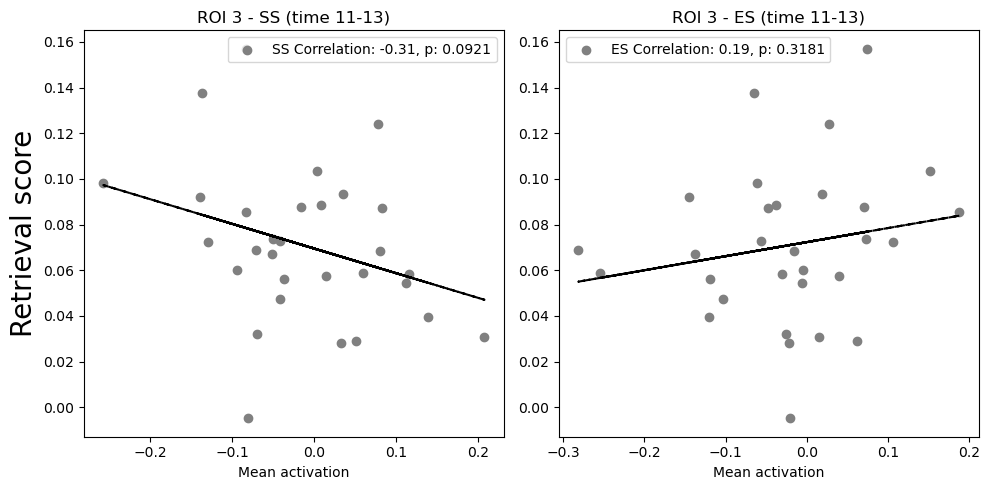

11 11 0.9662907251196406
11 11 0.3525051202379522


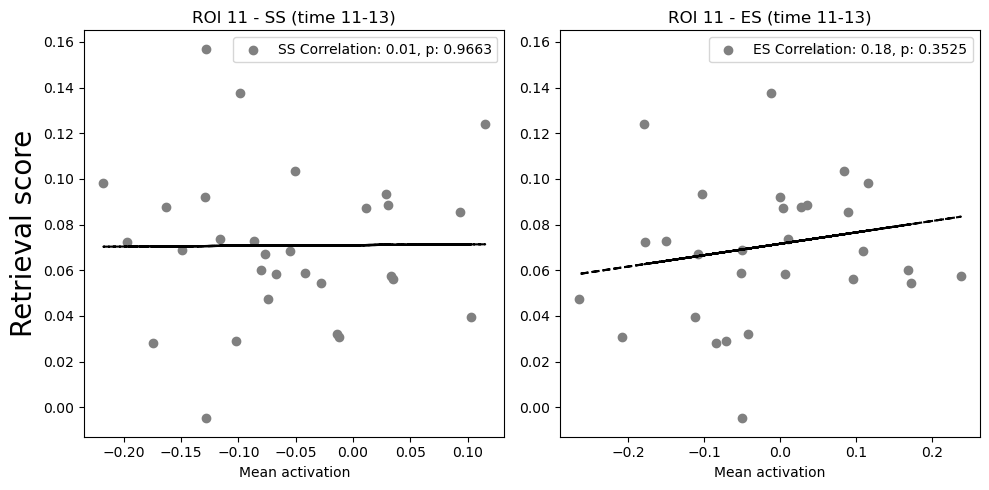

12 11 0.38109593606522935
12 11 0.7169080797855706


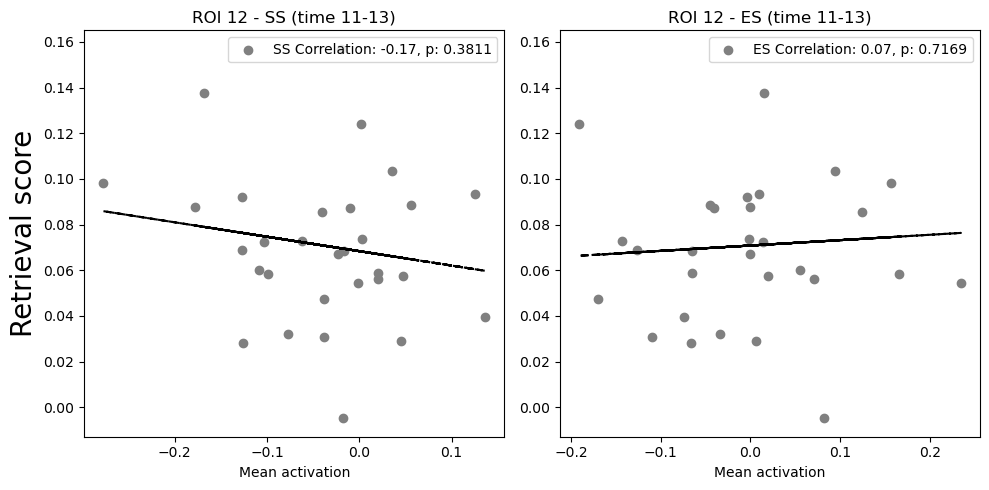

26 11 0.6055565110753437
26 11 0.7774850035950214


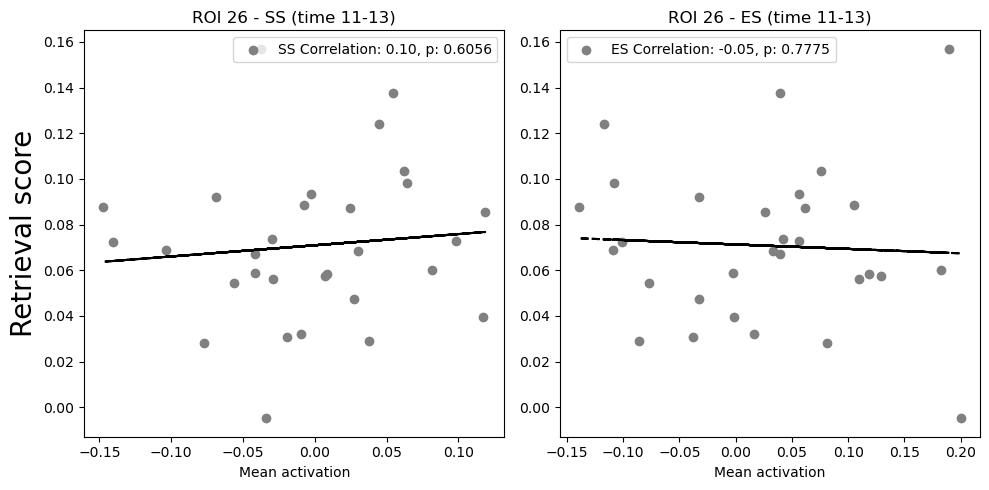

In [590]:
import numpy as np
from scipy.stats import pearsonr, linregress
import matplotlib.pyplot as plt

# 아웃라이어 제거 함수: SS와 ES 모두에서 아웃라이어가 있는 참가자를 제거
def remove_outliers(x, y, threshold=4):
    mean_x, std_x = np.mean(x), np.std(x)
    mean_y, std_y = np.mean(y), np.std(y)
    
    # x 또는 y에서 아웃라이어가 발생하면 해당 참가자를 제거
    valid_indices = (np.abs(x - mean_x) < threshold * std_x) & (np.abs(y - mean_y) < threshold * std_y)
    
    return x[valid_indices], y[valid_indices], valid_indices

# timepoint 설정
timepoints = [11]
bon_p = 0.05 / 1  # Bonferroni 보정

# ROI별로 아웃라이어 제거 후 산포도 및 회귀선 그리기
for roi in [3,11,12,26]:
    # story_ss_mean_series = np.concatenate((ss_story_series_mean[roi, 0, :30, 1, :]))#, ss_story_series_mean[roi, 1, :31, 0, :]))
    # story_es_mean_series = np.concatenate((es_story_series_mean[roi, 0, :30, 1, :]))#, es_story_series_mean[roi, 1, :31, 0, :]))

    for s, start in enumerate(timepoints):
        end = start + 2

        # SS와 ES 윈도우 평균 계산
        mean_ss_window = ss_story_series_mean[roi, 0, :30, 1, start:end].mean(axis=1)
        mean_es_window = es_story_series_mean[roi, 0, :30, 1, start:end].mean(axis=1)

        # 아웃라이어 제거 (SS와 ES에서 공통적으로 아웃라이어인 참가자를 제거)
        mean_ss_window_clean, mean_retrieval_clean_ss, _ = remove_outliers(mean_ss_window, mean_content_score_va)
        mean_es_window_clean, mean_retrieval_clean_es, _ = remove_outliers(mean_es_window, mean_content_score_va)

        # SS 산포도 및 회귀선 그리기
        plt.figure(figsize=(10, 5))

        # SS 산포도 및 회귀선
        plt.subplot(1, 2, 1)
        corr_ss, p_ss = pearsonr(mean_ss_window_clean, mean_retrieval_clean_ss)
        print(roi, start, p_ss)
        slope_ss, intercept_ss, _, _, _ = linregress(mean_ss_window_clean, mean_retrieval_clean_ss)

        plt.scatter(mean_ss_window_clean, mean_retrieval_clean_ss, color='gray', label=f'SS Correlation: {corr_ss:.2f}, p: {p_ss:.4f}')
        plt.plot(mean_ss_window_clean, slope_ss * mean_ss_window_clean + intercept_ss, color='black', linestyle='--')
        plt.title(f'ROI {roi} - SS (time {start}-{end})')
        plt.xlabel('Mean activation')
        plt.ylabel('Retrieval score', fontsize = 20 )
        plt.legend()
        plt.grid(False)
        plt.tight_layout()
        #plt.savefig(f"{ROI}_content_es.jpg")

        # ES 산포도 및 회귀선
        plt.subplot(1, 2, 2)
        corr_es, p_es = pearsonr(mean_es_window_clean, mean_retrieval_clean_es)
        print(roi, start, p_es)
        slope_es, intercept_es, _, _, _ = linregress(mean_es_window_clean, mean_retrieval_clean_es)

        plt.scatter(mean_es_window_clean, mean_retrieval_clean_es, color='gray', label=f'ES Correlation: {corr_es:.2f}, p: {p_es:.4f}')
        plt.plot(mean_es_window_clean, slope_es * mean_es_window_clean + intercept_es, color='black', linestyle='--')
        plt.title(f'ROI {roi} - ES (time {start}-{end})')
        plt.xlabel('Mean activation')
        #plt.ylabel('Retrieval')
        plt.legend()
        plt.grid(False)

        plt.tight_layout()
        # plt.savefig(f"{roi}_content_es.jpg")
        plt.show()

3 12 0.9475364452791492
3 12 0.2047115421455857


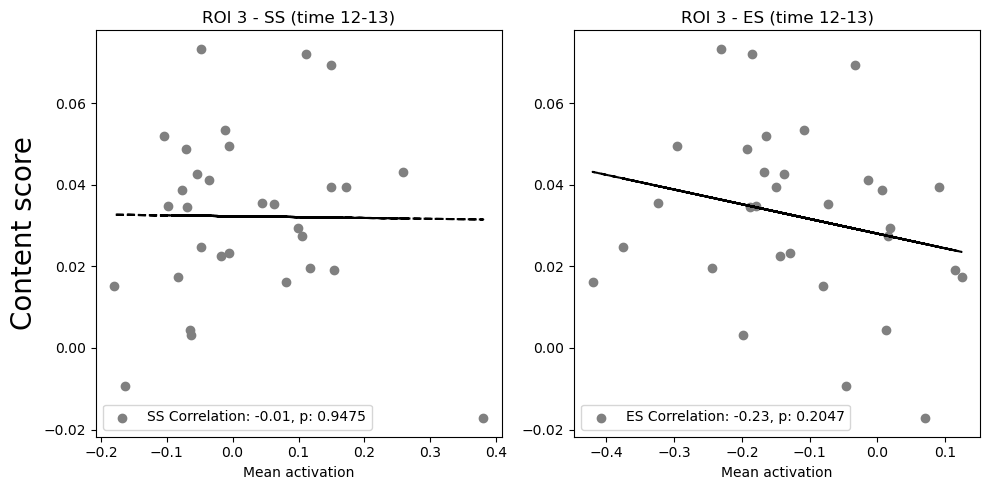

11 12 0.01354422153071304
11 12 0.8476480724595189


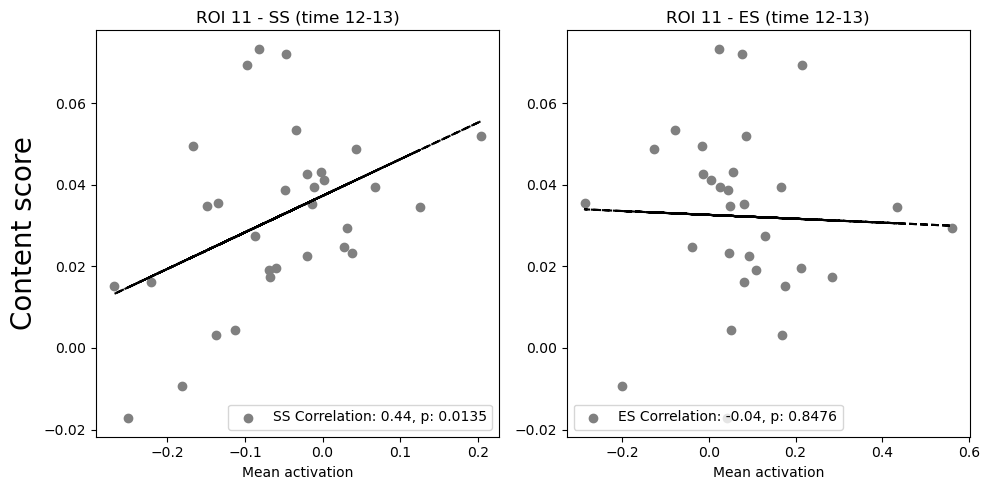

12 12 0.02931826015968158
12 12 0.467693343999014


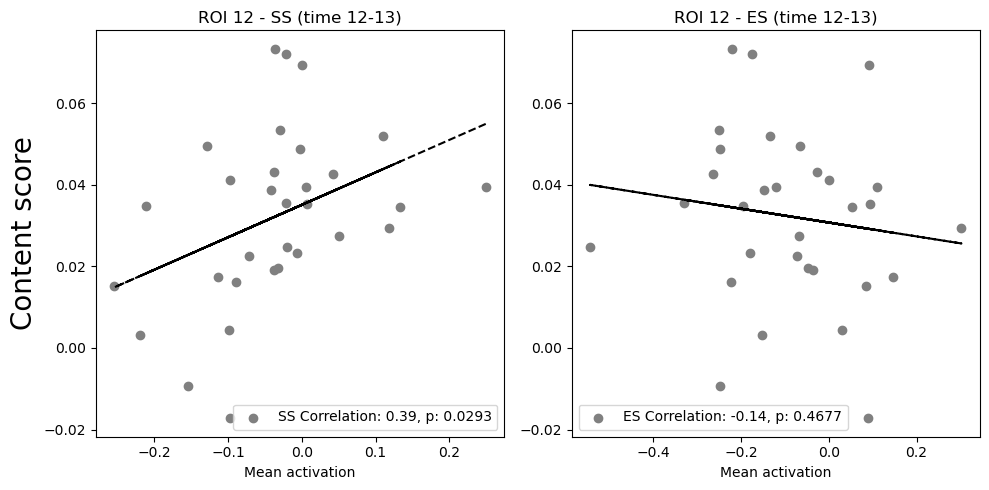

26 12 0.026194388909533916
26 12 0.17745755685554618


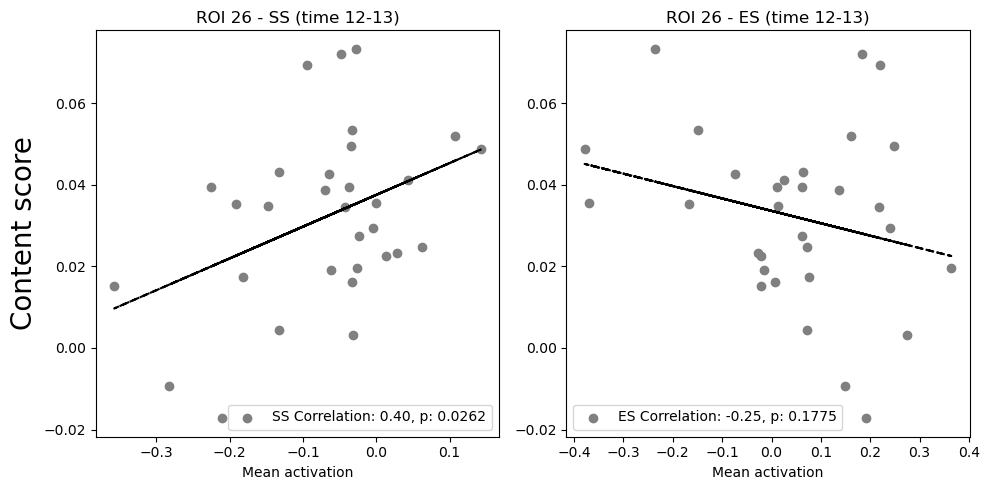

In [480]:
import numpy as np
from scipy.stats import pearsonr, linregress
import matplotlib.pyplot as plt

# 아웃라이어 제거 함수: SS와 ES 모두에서 아웃라이어가 있는 참가자를 제거
def remove_outliers(x, y, threshold=4):
    mean_x, std_x = np.mean(x), np.std(x)
    mean_y, std_y = np.mean(y), np.std(y)
    
    # x 또는 y에서 아웃라이어가 발생하면 해당 참가자를 제거
    valid_indices = (np.abs(x - mean_x) < threshold * std_x) & (np.abs(y - mean_y) < threshold * std_y)
    
    return x[valid_indices], y[valid_indices], valid_indices

# timepoint 설정
timepoints = [12]
bon_p = 0.05 / 1  # Bonferroni 보정

# ROI별로 아웃라이어 제거 후 산포도 및 회귀선 그리기
for roi in [3,11,12,26]:
    # story_ss_mean_series = np.concatenate((ss_story_series_mean[roi, 0, :30, 1, :]))#, ss_story_series_mean[roi, 1, :31, 0, :]))
    # story_es_mean_series = np.concatenate((es_story_series_mean[roi, 0, :30, 1, :]))#, es_story_series_mean[roi, 1, :31, 0, :]))

    for s, start in enumerate(timepoints):
        end = start + 1

        # SS와 ES 윈도우 평균 계산
        mean_ss_window = ss_story_series_mean[roi,1, :31, 0, start:end].mean(axis=1)
        mean_es_window = es_story_series_mean[roi,1, :31, 0, start:end].mean(axis=1)

        # 아웃라이어 제거 (SS와 ES에서 공통적으로 아웃라이어인 참가자를 제거)
        mean_ss_window_clean, mean_retrieval_clean_ss, _ = remove_outliers(mean_ss_window, mean_content_score_av)
        mean_es_window_clean, mean_retrieval_clean_es, _ = remove_outliers(mean_es_window, mean_content_score_av)

        # SS 산포도 및 회귀선 그리기
        plt.figure(figsize=(10, 5))

        # SS 산포도 및 회귀선
        plt.subplot(1, 2, 1)
        corr_ss, p_ss = pearsonr(mean_ss_window_clean, mean_retrieval_clean_ss)
        print(roi, start, p_ss)
        slope_ss, intercept_ss, _, _, _ = linregress(mean_ss_window_clean, mean_retrieval_clean_ss)

        plt.scatter(mean_ss_window_clean, mean_retrieval_clean_ss, color='gray', label=f'SS Correlation: {corr_ss:.2f}, p: {p_ss:.4f}')
        plt.plot(mean_ss_window_clean, slope_ss * mean_ss_window_clean + intercept_ss, color='black', linestyle='--')
        plt.title(f'ROI {roi} - SS (time {start}-{end})')
        plt.xlabel('Mean activation')
        plt.ylabel('Content score', fontsize = 20 )
        plt.legend()
        plt.grid(False)
        plt.tight_layout()
        #plt.savefig(f"{ROI}_content_es.jpg")

        # ES 산포도 및 회귀선
        plt.subplot(1, 2, 2)
        corr_es, p_es = pearsonr(mean_es_window_clean, mean_retrieval_clean_es)
        print(roi, start, p_es)
        slope_es, intercept_es, _, _, _ = linregress(mean_es_window_clean, mean_retrieval_clean_es)

        plt.scatter(mean_es_window_clean, mean_retrieval_clean_es, color='gray', label=f'ES Correlation: {corr_es:.2f}, p: {p_es:.4f}')
        plt.plot(mean_es_window_clean, slope_es * mean_es_window_clean + intercept_es, color='black', linestyle='--')
        plt.title(f'ROI {roi} - ES (time {start}-{end})')
        plt.xlabel('Mean activation')
        #plt.ylabel('Retrieval')
        plt.legend()
        plt.grid(False)

        plt.tight_layout()
        # plt.savefig(f"{roi}_content_es.jpg")
        plt.show()

6 11 0.25463240901278195
6 11 0.36110031200561277


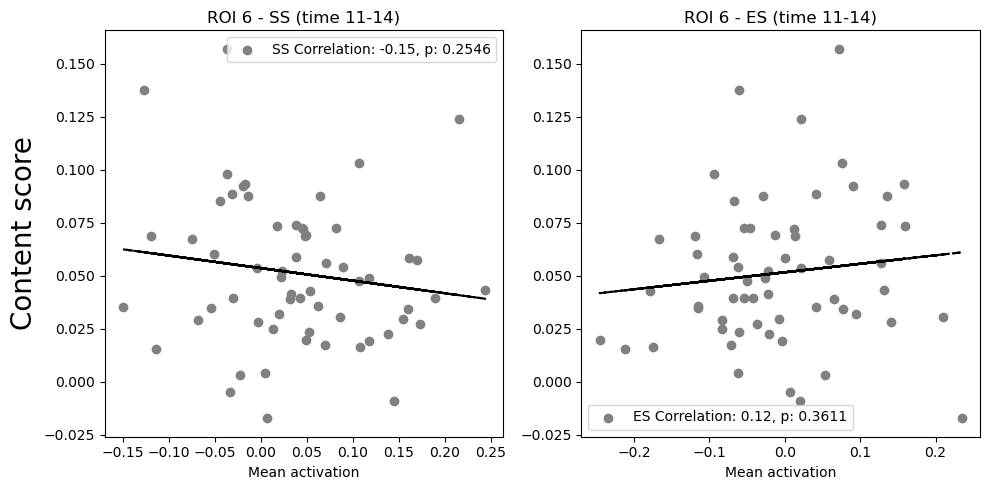

8 11 0.206015438678529
8 11 0.34940357357016527


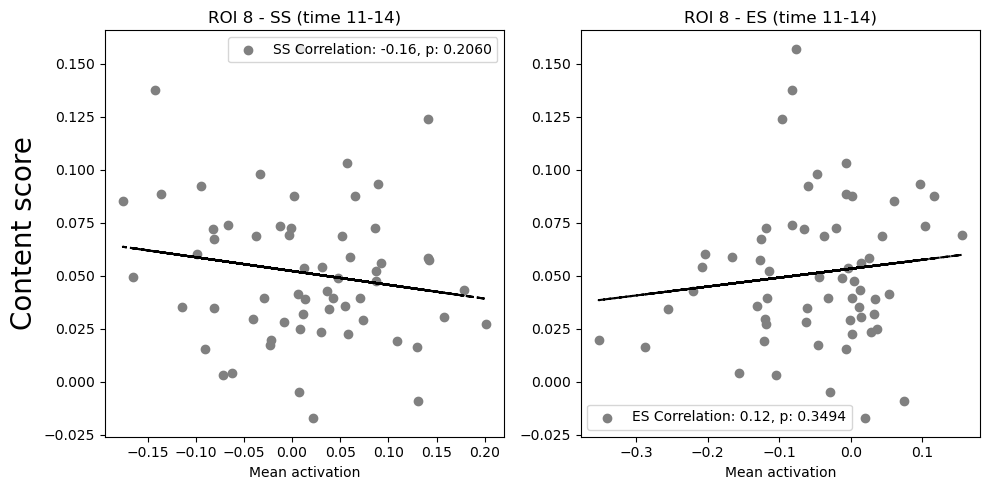

3 11 0.046154426756583364
3 11 0.06205148621591687


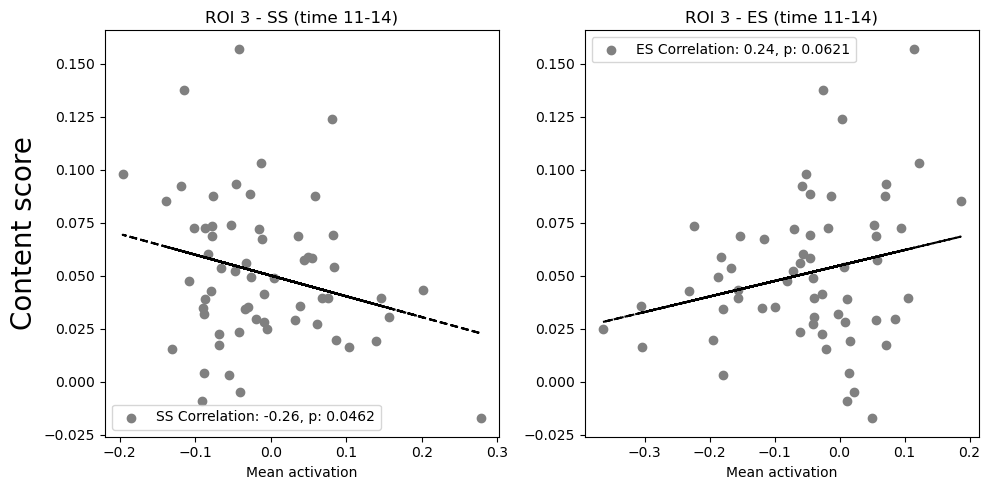

11 11 0.3284347265949303
11 11 0.955470621361143


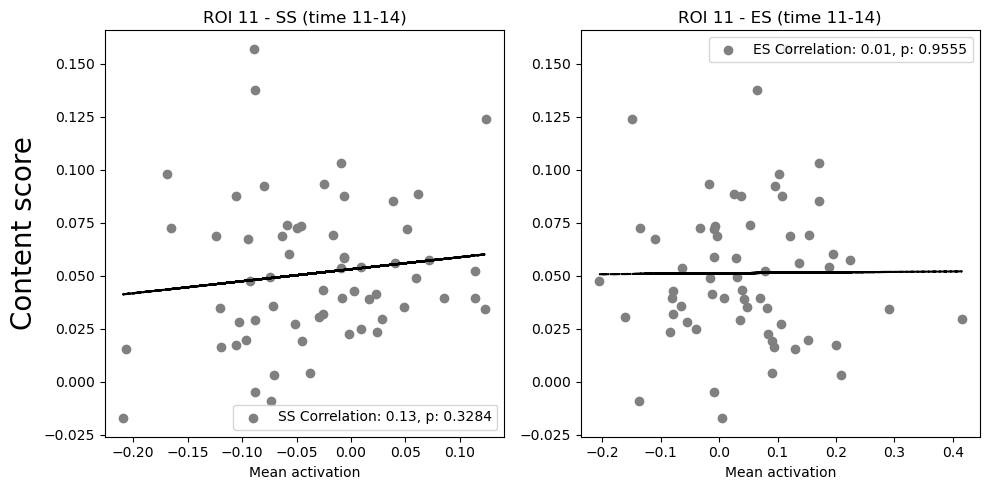

12 11 0.8111726991455278
12 11 0.04842612057206633


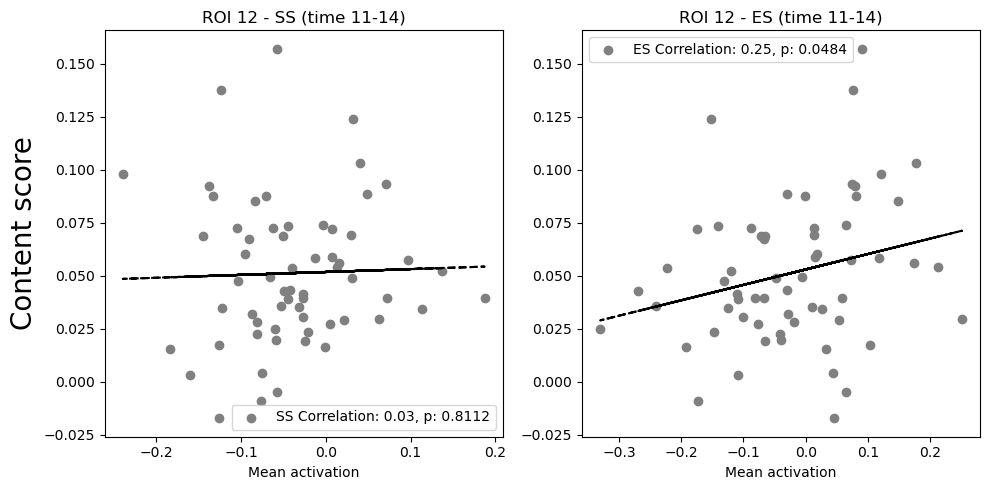

24 11 0.7847916484153148
24 11 0.461283224146186


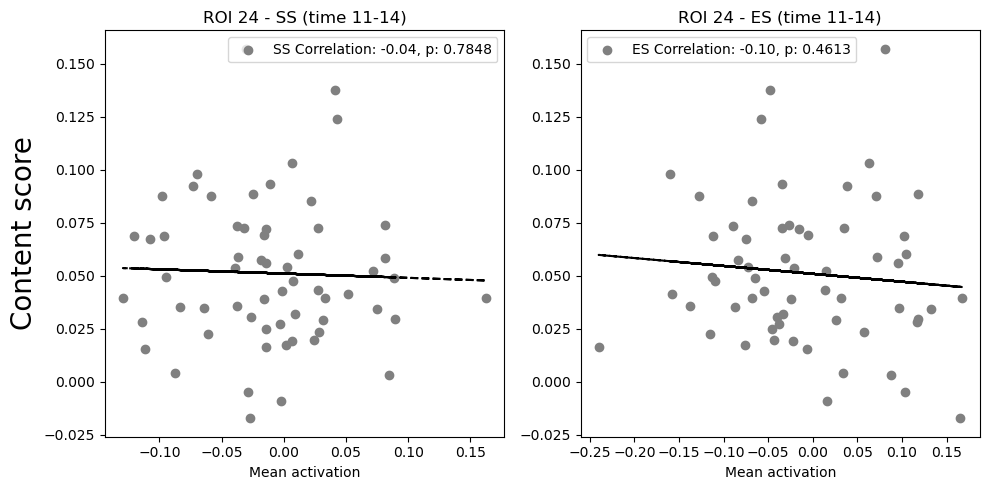

26 11 0.041087060155066385
26 11 0.47804972018119096


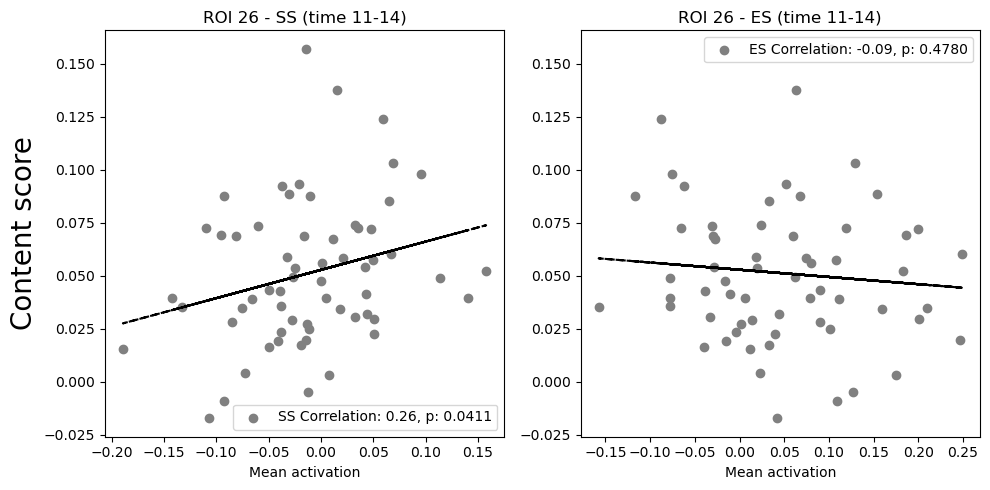

In [90]:
import numpy as np
from scipy.stats import pearsonr, linregress
import matplotlib.pyplot as plt

# 아웃라이어 제거 함수: SS와 ES 모두에서 아웃라이어가 있는 참가자를 제거
def remove_outliers(x, y, threshold=4):
    mean_x, std_x = np.mean(x), np.std(x)
    mean_y, std_y = np.mean(y), np.std(y)
    
    # x 또는 y에서 아웃라이어가 발생하면 해당 참가자를 제거
    valid_indices = (np.abs(x - mean_x) < threshold * std_x) & (np.abs(y - mean_y) < threshold * std_y)
    
    return x[valid_indices], y[valid_indices], valid_indices

# timepoint 설정
timepoints = [11]
bon_p = 0.05 / 1  # Bonferroni 보정

# ROI별로 아웃라이어 제거 후 산포도 및 회귀선 그리기
for roi in [6,8,3,11,12,24,26]:
    story_ss_mean_series = np.concatenate((ss_story_series_mean[roi, 0, :30, 1, :], ss_story_series_mean[roi, 1, :31, 0, :]))
    story_es_mean_series = np.concatenate((es_story_series_mean[roi, 0, :30, 1, :], es_story_series_mean[roi, 1, :31, 0, :]))

    for s, start in enumerate(timepoints):
        end = start + 3
    

        # SS와 ES 윈도우 평균 계산
        mean_ss_window = story_ss_mean_series[:, start:end].mean(axis=1)
        mean_es_window = story_es_mean_series[:, start:end].mean(axis=1)

        # 아웃라이어 제거 (SS와 ES에서 공통적으로 아웃라이어인 참가자를 제거)
        mean_ss_window_clean, mean_retrieval_clean_ss, _ = remove_outliers(mean_ss_window, mean_content)
        mean_es_window_clean, mean_retrieval_clean_es, _ = remove_outliers(mean_es_window, mean_content)

        # SS 산포도 및 회귀선 그리기
        plt.figure(figsize=(10, 5))

        # SS 산포도 및 회귀선
        plt.subplot(1, 2, 1)
        corr_ss, p_ss = pearsonr(mean_ss_window_clean, mean_retrieval_clean_ss)
        print(roi, start, p_ss)
        slope_ss, intercept_ss, _, _, _ = linregress(mean_ss_window_clean, mean_retrieval_clean_ss)

        plt.scatter(mean_ss_window_clean, mean_retrieval_clean_ss, color='gray', label=f'SS Correlation: {corr_ss:.2f}, p: {p_ss:.4f}')
        plt.plot(mean_ss_window_clean, slope_ss * mean_ss_window_clean + intercept_ss, color='black', linestyle='--')
        plt.title(f'ROI {roi} - SS (time {start}-{end})')
        plt.xlabel('Mean activation')
        plt.ylabel('Content score', fontsize = 20 )
        plt.legend()
        plt.grid(False)
        plt.tight_layout()
        #plt.savefig(f"{ROI}_content_es.jpg")

        # ES 산포도 및 회귀선
        plt.subplot(1, 2, 2)
        corr_es, p_es = pearsonr(mean_es_window_clean, mean_retrieval_clean_es)
        print(roi, start, p_es)
        slope_es, intercept_es, _, _, _ = linregress(mean_es_window_clean, mean_retrieval_clean_es)

        plt.scatter(mean_es_window_clean, mean_retrieval_clean_es, color='gray', label=f'ES Correlation: {corr_es:.2f}, p: {p_es:.4f}')
        plt.plot(mean_es_window_clean, slope_es * mean_es_window_clean + intercept_es, color='black', linestyle='--')
        plt.title(f'ROI {roi} - ES (time {start}-{end})')
        plt.xlabel('Mean activation')
        #plt.ylabel('Retrieval')
        plt.legend()
        plt.grid(False)

        plt.tight_layout()
        # plt.savefig(f"{roi}_content_es.jpg")
        plt.show()

In [565]:
ss_story_series_mean[roi, 1, :, 0, start:end].shape

(31, 2)

In [606]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Function to remove outliers: removes participants with outliers in both SS and ES
def remove_outliers(x, y, threshold=4):
    mean_x, std_x = np.mean(x), np.std(x)
    mean_y, std_y = np.mean(y), np.std(y)
    
    # Keep only participants without outliers in x and y
    valid_indices = (np.abs(x - mean_x) < threshold * std_x) & (np.abs(y - mean_y) < threshold * std_y)
    return x[valid_indices], y[valid_indices], valid_indices

# Define Bonferroni correction value
bon_p = 0.05 / 1  # Adjust if needed

# Loop through each ROI to perform analysis
for roi in [11, 12, 26]:
    print(f"\nROI {roi} Analysis:")

    # Total timepoints and window size for sliding (2-TR window)
    total_timepoints = 20 # Assuming a maximum of 12 timepoints as in the example
    window_size = 2

    # Arrays to store correlation values for each timepoint
    corr_ss_values = []
    corr_es_values = []

    # Perform sliding window analysis
    for start in range(total_timepoints - window_size + 1):
        end = start + window_size

        # Calculate mean activation for each window
        mean_ss_window = ss_story_series_mean[roi, 0, 30:, 1, start:end].mean(axis=1)
        mean_es_window = es_story_series_mean[roi, 0, 30:, 1, start:end].mean(axis=1)

        # Remove outliers in SS and ES windows
        mean_ss_window_clean, mean_retrieval_clean_ss, _ = remove_outliers(mean_ss_window, mean_content_score_va)
        mean_es_window_clean, mean_retrieval_clean_es, _ = remove_outliers(mean_es_window, mean_content_score_va)

        # Calculate correlation for SS and ES and store them
        corr_ss, _ = pearsonr(mean_ss_window_clean, mean_retrieval_clean_ss)
        corr_es, _ = pearsonr(mean_es_window_clean, mean_retrieval_clean_es)

        # Append correlation values
        corr_ss_values.append(corr_ss)
        corr_es_values.append(corr_es)

    # Plot correlations over time for SS and ES
    plt.figure(figsize=(5, 4))
    plt.plot(range(total_timepoints - window_size + 1), corr_ss_values, label="SS Correlation", marker='o')
    plt.plot(range(total_timepoints - window_size + 1), corr_es_values, label="ES Correlation", marker='s')
    
    plt.title(f'ROI {roi} - Correlation over Time')
    plt.xlabel('Time Window Start (TR)')
    plt.ylabel('Correlation with Behavioral Score')
    plt.legend()
    plt.ylim([-0.4,0.45])
    plt.grid(False)
    plt.tight_layout()
    plt.show()



ROI 11 Analysis:


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 30


ROI 11 Analysis:


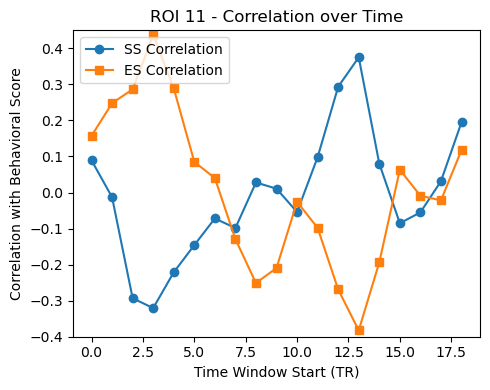


ROI 12 Analysis:


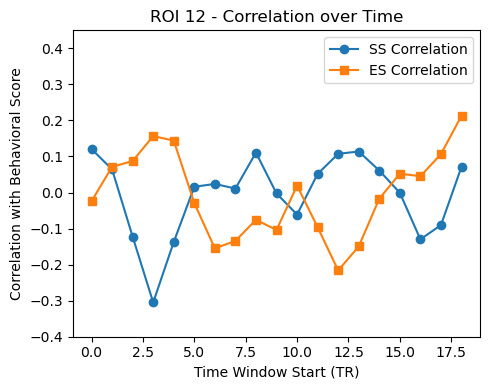


ROI 26 Analysis:


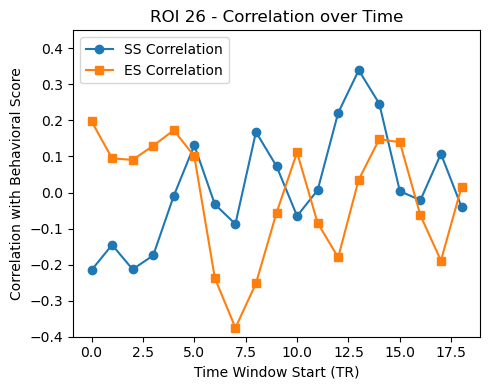

In [605]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Function to remove outliers: removes participants with outliers in both SS and ES
def remove_outliers(x, y, threshold=4):
    mean_x, std_x = np.mean(x), np.std(x)
    mean_y, std_y = np.mean(y), np.std(y)
    
    # Keep only participants without outliers in x and y
    valid_indices = (np.abs(x - mean_x) < threshold * std_x) & (np.abs(y - mean_y) < threshold * std_y)
    return x[valid_indices], y[valid_indices], valid_indices

# Define Bonferroni correction value
bon_p = 0.05 / 1  # Adjust if needed

# Loop through each ROI to perform analysis
for roi in [11, 12, 26]:
    print(f"\nROI {roi} Analysis:")

    # Total timepoints and window size for sliding (2-TR window)
    total_timepoints = 20 # Assuming a maximum of 12 timepoints as in the example
    window_size = 2

    # Arrays to store correlation values for each timepoint
    corr_ss_values = []
    corr_es_values = []

    # Perform sliding window analysis
    for start in range(total_timepoints - window_size + 1):
        end = start + window_size

        # Calculate mean activation for each window
        mean_ss_window = ss_story_series_mean[roi, 0, :31, 1, start:end].mean(axis=1)
        mean_es_window = es_story_series_mean[roi, 0, :31, 1, start:end].mean(axis=1)

        # Remove outliers in SS and ES windows
        mean_ss_window_clean, mean_retrieval_clean_ss, _ = remove_outliers(mean_ss_window, mean_content_score_av)
        mean_es_window_clean, mean_retrieval_clean_es, _ = remove_outliers(mean_es_window, mean_content_score_av)

        # Calculate correlation for SS and ES and store them
        corr_ss, _ = pearsonr(mean_ss_window_clean, mean_retrieval_clean_ss)
        corr_es, _ = pearsonr(mean_es_window_clean, mean_retrieval_clean_es)

        # Append correlation values
        corr_ss_values.append(corr_ss)
        corr_es_values.append(corr_es)

    # Plot correlations over time for SS and ES
    plt.figure(figsize=(5, 4))
    plt.plot(range(total_timepoints - window_size + 1), corr_ss_values, label="SS Correlation", marker='o')
    plt.plot(range(total_timepoints - window_size + 1), corr_es_values, label="ES Correlation", marker='s')
    
    plt.title(f'ROI {roi} - Correlation over Time')
    plt.xlabel('Time Window Start (TR)')
    plt.ylabel('Correlation with Behavioral Score')
    plt.legend()
    plt.ylim([-0.4,0.45])
    plt.grid(False)
    plt.tight_layout()
    plt.show()



ROI 3 Analysis:


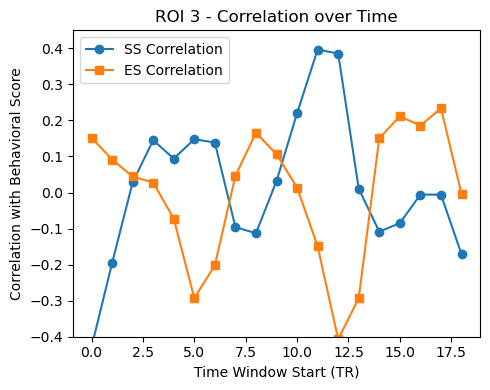


ROI 11 Analysis:


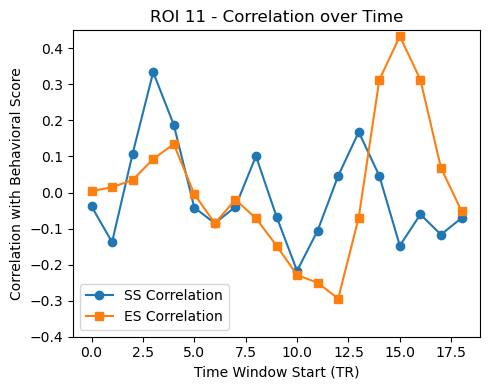


ROI 12 Analysis:


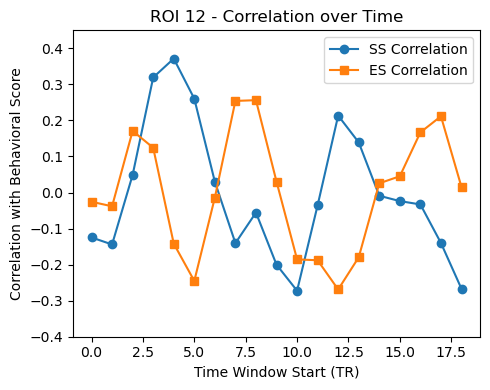


ROI 26 Analysis:


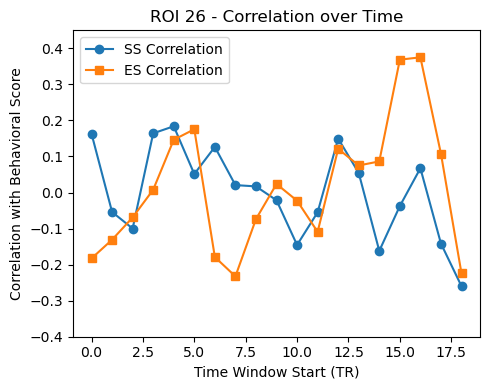

In [587]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Function to remove outliers: removes participants with outliers in both SS and ES
def remove_outliers(x, y, threshold=4):
    mean_x, std_x = np.mean(x), np.std(x)
    mean_y, std_y = np.mean(y), np.std(y)
    
    # Keep only participants without outliers in x and y
    valid_indices = (np.abs(x - mean_x) < threshold * std_x) & (np.abs(y - mean_y) < threshold * std_y)
    return x[valid_indices], y[valid_indices], valid_indices

# Define Bonferroni correction value
bon_p = 0.05 / 1  # Adjust if needed

# Loop through each ROI to perform analysis
for roi in [3, 11, 12, 26]:
    print(f"\nROI {roi} Analysis:")

    # Total timepoints and window size for sliding (2-TR window)
    total_timepoints = 20 # Assuming a maximum of 12 timepoints as in the example
    window_size = 2

    # Arrays to store correlation values for each timepoint
    corr_ss_values = []
    corr_es_values = []

    # Perform sliding window analysis
    for start in range(total_timepoints - window_size + 1):
        end = start + window_size

        # Calculate mean activation for each window
        mean_ss_window = ss_story_series_mean[roi, 0, :30, 1, start:end].mean(axis=1)
        mean_es_window = es_story_series_mean[roi, 0, :30, 1, start:end].mean(axis=1)

        # Remove outliers in SS and ES windows
        mean_ss_window_clean, mean_retrieval_clean_ss, _ = remove_outliers(mean_ss_window, mean_retrieval_va)
        mean_es_window_clean, mean_retrieval_clean_es, _ = remove_outliers(mean_es_window, mean_retrieval_va)

        # Calculate correlation for SS and ES and store them
        corr_ss, _ = pearsonr(mean_ss_window_clean, mean_retrieval_clean_ss)
        corr_es, _ = pearsonr(mean_es_window_clean, mean_retrieval_clean_es)

        # Append correlation values
        corr_ss_values.append(corr_ss)
        corr_es_values.append(corr_es)

    # Plot correlations over time for SS and ES
    plt.figure(figsize=(5, 4))
    plt.plot(range(total_timepoints - window_size + 1), corr_ss_values, label="SS Correlation", marker='o')
    plt.plot(range(total_timepoints - window_size + 1), corr_es_values, label="ES Correlation", marker='s')
    
    plt.title(f'ROI {roi} - Correlation over Time')
    plt.xlabel('Time Window Start (TR)')
    plt.ylabel('Correlation with Behavioral Score')
    plt.legend()
    plt.ylim([-0.4,0.45])
    plt.grid(False)
    plt.tight_layout()
    plt.show()



ROI 3 Analysis:


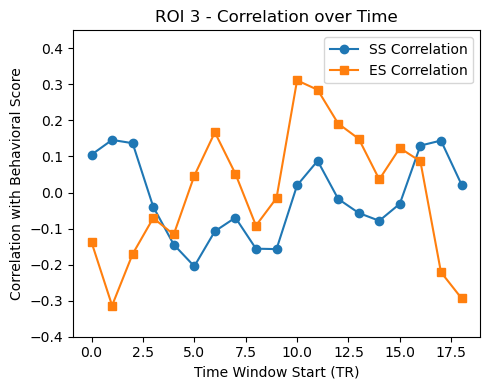


ROI 11 Analysis:


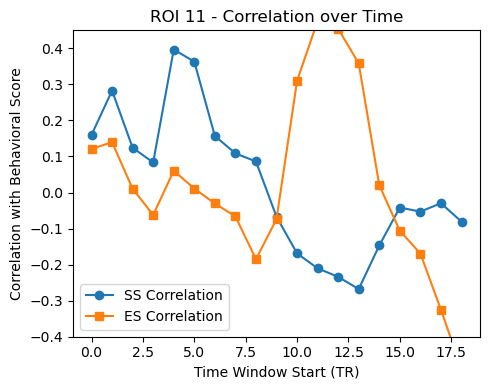


ROI 12 Analysis:


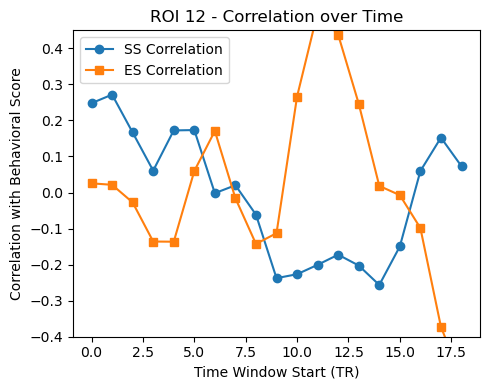


ROI 26 Analysis:


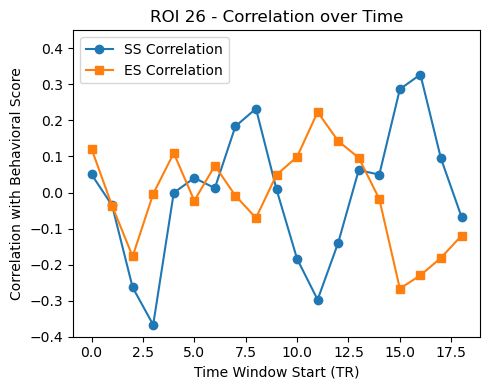

In [586]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Function to remove outliers: removes participants with outliers in both SS and ES
def remove_outliers(x, y, threshold=4):
    mean_x, std_x = np.mean(x), np.std(x)
    mean_y, std_y = np.mean(y), np.std(y)
    
    # Keep only participants without outliers in x and y
    valid_indices = (np.abs(x - mean_x) < threshold * std_x) & (np.abs(y - mean_y) < threshold * std_y)
    return x[valid_indices], y[valid_indices], valid_indices

# Define Bonferroni correction value
bon_p = 0.05 / 1  # Adjust if needed

# Loop through each ROI to perform analysis
for roi in [3, 11, 12, 26]:
    print(f"\nROI {roi} Analysis:")

    # Total timepoints and window size for sliding (2-TR window)
    total_timepoints = 20 # Assuming a maximum of 12 timepoints as in the example
    window_size = 2

    # Arrays to store correlation values for each timepoint
    corr_ss_values = []
    corr_es_values = []

    # Perform sliding window analysis
    for start in range(total_timepoints - window_size + 1):
        end = start + window_size

        # Calculate mean activation for each window
        mean_ss_window = ss_story_series_mean[roi, 1,:31, 0, start:end].mean(axis=1)
        mean_es_window = es_story_series_mean[roi, 1,:31, 0, start:end].mean(axis=1)

        # Remove outliers in SS and ES windows
        mean_ss_window_clean, mean_retrieval_clean_ss, _ = remove_outliers(mean_ss_window, mean_retrieval_av)
        mean_es_window_clean, mean_retrieval_clean_es, _ = remove_outliers(mean_es_window, mean_retrieval_av)

        # Calculate correlation for SS and ES and store them
        corr_ss, _ = pearsonr(mean_ss_window_clean, mean_retrieval_clean_ss)
        corr_es, _ = pearsonr(mean_es_window_clean, mean_retrieval_clean_es)

        # Append correlation values
        corr_ss_values.append(corr_ss)
        corr_es_values.append(corr_es)

    # Plot correlations over time for SS and ES
    plt.figure(figsize=(5, 4))
    plt.plot(range(total_timepoints - window_size + 1), corr_ss_values, label="SS Correlation", marker='o')
    plt.plot(range(total_timepoints - window_size + 1), corr_es_values, label="ES Correlation", marker='s')
    
    plt.title(f'ROI {roi} - Correlation over Time')
    plt.xlabel('Time Window Start (TR)')
    plt.ylabel('Correlation with Behavioral Score')
    plt.legend()
    plt.ylim([-0.4,0.45])
    plt.grid(False)
    plt.tight_layout()
    plt.show()



ROI 11 Analysis:


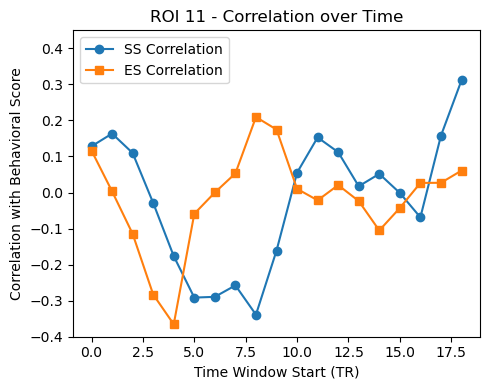


ROI 12 Analysis:


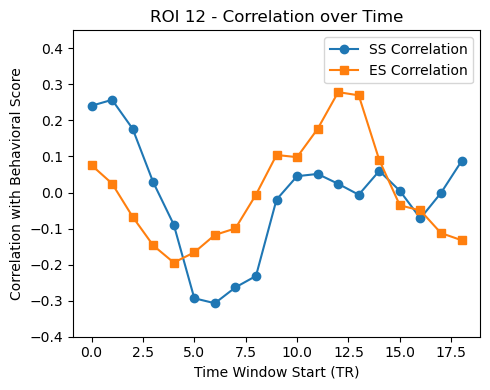


ROI 26 Analysis:


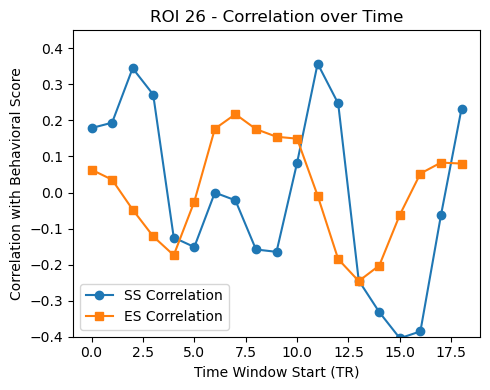

In [595]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Function to remove outliers: removes participants with outliers in both SS and ES
def remove_outliers(x, y, threshold=4):
    mean_x, std_x = np.mean(x), np.std(x)
    mean_y, std_y = np.mean(y), np.std(y)
    
    # Keep only participants without outliers in x and y
    valid_indices = (np.abs(x - mean_x) < threshold * std_x) & (np.abs(y - mean_y) < threshold * std_y)
    return x[valid_indices], y[valid_indices], valid_indices

# Define Bonferroni correction value
bon_p = 0.05 / 1  # Adjust if needed

# Loop through each ROI to perform analysis
for roi in [11, 12, 26]:
    print(f"\nROI {roi} Analysis:")

    # Total timepoints and window size for sliding (2-TR window)
    total_timepoints = 20 # Assuming a maximum of 12 timepoints as in the example
    window_size = 2

    # Arrays to store correlation values for each timepoint
    corr_ss_values = []
    corr_es_values = []

    # Perform sliding window analysis
    for start in range(total_timepoints - window_size + 1):
        end = start + window_size

        # Calculate mean activation for each window
        story_ss_mean_series = np.concatenate((ss_story_series_mean[roi, 0, :30, 1, start:end], ss_story_series_mean[roi, 1, :31, 0, start:end]))
        story_es_mean_series = np.concatenate((es_story_series_mean[roi, 0, :30, 1, start:end], es_story_series_mean[roi, 1, :31, 0, start:end]))
        mean_ss_window = story_ss_mean_series.mean(axis=1)
        mean_es_window = story_es_mean_series.mean(axis=1)

        # Remove outliers in SS and ES windows
        mean_ss_window_clean, mean_retrieval_clean_ss, _ = remove_outliers(mean_ss_window, mean_content)
        mean_es_window_clean, mean_retrieval_clean_es, _ = remove_outliers(mean_es_window, mean_content)

        # Calculate correlation for SS and ES and store them
        corr_ss, _ = pearsonr(mean_ss_window_clean, mean_retrieval_clean_ss)
        corr_es, _ = pearsonr(mean_es_window_clean, mean_retrieval_clean_es)

        # Append correlation values
        corr_ss_values.append(corr_ss)
        corr_es_values.append(corr_es)

    # Plot correlations over time for SS and ES
    plt.figure(figsize=(5, 4))
    plt.plot(range(total_timepoints - window_size + 1), corr_ss_values, label="SS Correlation", marker='o')
    plt.plot(range(total_timepoints - window_size + 1), corr_es_values, label="ES Correlation", marker='s')
    
    plt.title(f'ROI {roi} - Correlation over Time')
    plt.xlabel('Time Window Start (TR)')
    plt.ylabel('Correlation with Behavioral Score')
    plt.legend()
    plt.ylim([-0.4,0.45])
    plt.grid(False)
    plt.tight_layout()
    plt.show()



ROI 11 Analysis:


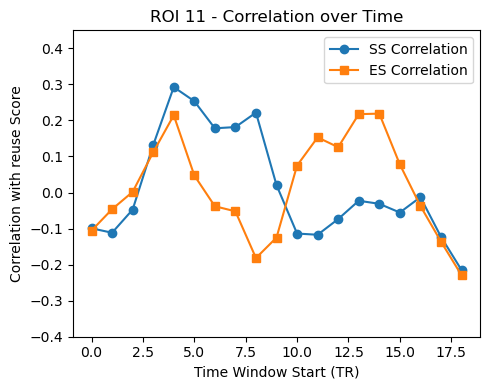


ROI 12 Analysis:


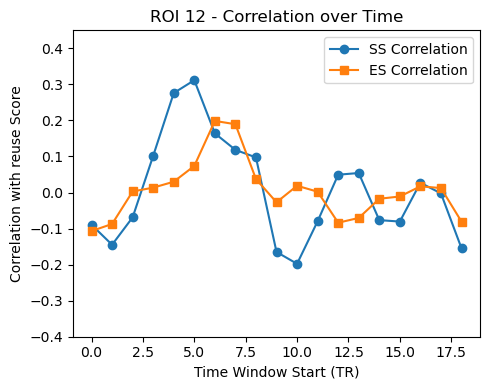


ROI 26 Analysis:


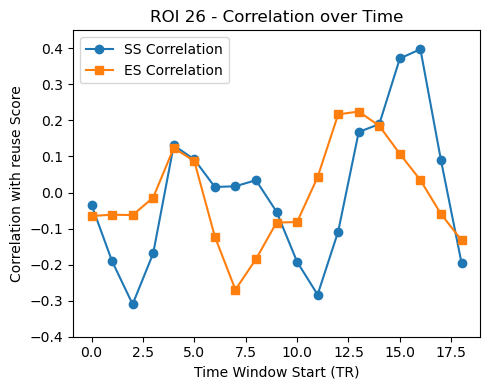

In [594]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Function to remove outliers: removes participants with outliers in both SS and ES
def remove_outliers(x, y, threshold=4):
    mean_x, std_x = np.mean(x), np.std(x)
    mean_y, std_y = np.mean(y), np.std(y)
    
    # Keep only participants without outliers in x and y
    valid_indices = (np.abs(x - mean_x) < threshold * std_x) & (np.abs(y - mean_y) < threshold * std_y)
    return x[valid_indices], y[valid_indices], valid_indices

# Define Bonferroni correction value
bon_p = 0.05 / 1  # Adjust if needed

# Loop through each ROI to perform analysis
for roi in [11, 12, 26]:
    print(f"\nROI {roi} Analysis:")

    # Total timepoints and window size for sliding (2-TR window)
    total_timepoints = 20 # Assuming a maximum of 12 timepoints as in the example
    window_size = 2

    # Arrays to store correlation values for each timepoint
    corr_ss_values = []
    corr_es_values = []

    # Perform sliding window analysis
    for start in range(total_timepoints - window_size + 1):
        end = start + window_size

        # Calculate mean activation for each window
        story_ss_mean_series = np.concatenate((ss_story_series_mean[roi, 0, :30, 1, start:end], ss_story_series_mean[roi, 1, :31, 0, start:end]))
        story_es_mean_series = np.concatenate((es_story_series_mean[roi, 0, :30, 1, start:end], es_story_series_mean[roi, 1, :31, 0, start:end]))
        mean_ss_window = story_ss_mean_series.mean(axis=1)
        mean_es_window = story_es_mean_series.mean(axis=1)

        # Remove outliers in SS and ES windows
        mean_ss_window_clean, mean_retrieval_clean_ss, _ = remove_outliers(mean_ss_window, mean_retrieval)
        mean_es_window_clean, mean_retrieval_clean_es, _ = remove_outliers(mean_es_window, mean_retrieval)

        # Calculate correlation for SS and ES and store them
        corr_ss, _ = pearsonr(mean_ss_window_clean, mean_retrieval_clean_ss)
        corr_es, _ = pearsonr(mean_es_window_clean, mean_retrieval_clean_es)

        # Append correlation values
        corr_ss_values.append(corr_ss)
        corr_es_values.append(corr_es)

    # Plot correlations over time for SS and ES
    plt.figure(figsize=(5, 4))
    plt.plot(range(total_timepoints - window_size + 1), corr_ss_values, label="SS Correlation", marker='o')
    plt.plot(range(total_timepoints - window_size + 1), corr_es_values, label="ES Correlation", marker='s')
    
    plt.title(f'ROI {roi} - Correlation over Time')
    plt.xlabel('Time Window Start (TR)')
    plt.ylabel('Correlation with reuse Score')
    plt.ylim([-0.4,0.45])
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()


In [556]:
story_ss_mean_series.shape

(61, 20)